# 0️⃣ InteractivePipelineLoadFromPickle (Independent Load-only Visualization Notebook) - Imports

In [ ]:
%config IPCompleter.use_jedi = False
# %xmode Verbose
# %xmode context
%pdb off
%load_ext autoreload
%autoreload 3

import sys
from pathlib import Path

# required to enable non-blocking interaction:
%gui qt5

import importlib
from copy import deepcopy
from numba import jit
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
# pd.options.mode.dtype_backend = 'pyarrow' # use new pyarrow backend instead of numpy
from attrs import define, field, fields, Factory, make_class
import tables as tb
from datetime import datetime, timedelta

# Pho's Formatting Preferences
import builtins

import IPython
from IPython.core.formatters import PlainTextFormatter
from IPython import get_ipython

from pyphocorehelpers.preferences_helpers import set_pho_preferences, set_pho_preferences_concise, set_pho_preferences_verbose
set_pho_preferences_concise()
# Jupyter-lab enable printing for any line on its own (instead of just the last one in the cell)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from pyphocorehelpers.gui.Jupyter.AsyncExecutionHelper import run_async

# BEGIN PPRINT CUSTOMIZATION ___________________________________________________________________________________________ #

## IPython pprint
from pyphocorehelpers.pprint import wide_pprint, wide_pprint_ipython, wide_pprint_jupyter, MAX_LINE_LENGTH
# Override default pprint
builtins.pprint = wide_pprint

ip = get_ipython()

from pyphocorehelpers.ipython_helpers import CustomFormatterMagics

# Register the magic
get_ipython().register_magics(CustomFormatterMagics)

text_formatter: PlainTextFormatter = ip.display_formatter.formatters['text/plain']
text_formatter.max_width = MAX_LINE_LENGTH
text_formatter.for_type(object, wide_pprint_jupyter)


# END PPRINT CUSTOMIZATION ___________________________________________________________________________________________ #

from pyphocorehelpers.print_helpers import get_now_time_str, get_now_day_str
from pyphocorehelpers.indexing_helpers import get_dict_subset

## Pho's Custom Libraries:
from pyphocorehelpers.Filesystem.path_helpers import find_first_extant_path, file_uri_from_path
from pyphocorehelpers.Filesystem.open_in_system_file_manager import reveal_in_system_file_manager
import pyphocorehelpers.programming_helpers as programming_helpers

# NeuroPy (Diba Lab Python Repo) Loading
# from neuropy import core
from typing import Dict, List, Tuple, Optional, Callable, Union, Any
from typing_extensions import TypeAlias
from nptyping import NDArray
import neuropy.utils.type_aliases as types

from neuropy.analyses.placefields import PlacefieldComputationParameters
from neuropy.core.epoch import NamedTimerange, Epoch
from neuropy.core.ratemap import Ratemap
from neuropy.core.session.Formats.BaseDataSessionFormats import DataSessionFormatRegistryHolder, DataSessionFormatBaseRegisteredClass
from neuropy.core.session.Formats.BaseDataSessionFormats import HardcodedProcessingParameters
# from neuropy.core.session.Formats.Specific.KDibaOldDataSessionFormat import KDibaOldDataSessionFormatRegisteredClass
# from neuropy.core.session.Formats.Specific.BapunDataSessionFormat import BapunDataSessionFormatRegisteredClass
# from neuropy.core.session.Formats.Specific.RachelDataSessionFormat import RachelDataSessionFormat
from neuropy.core.session.Formats.Specific.BapunDataSessionFormat import BapunDataSessionFormatRegisteredClass

from neuropy.utils.matplotlib_helpers import matplotlib_file_only, matplotlib_configuration, matplotlib_configuration_update
from neuropy.core.neuron_identities import NeuronIdentityTable, neuronTypesList, neuronTypesEnum
from neuropy.utils.mixins.AttrsClassHelpers import AttrsBasedClassHelperMixin, serialized_field, serialized_attribute_field, non_serialized_field, custom_define
from neuropy.utils.mixins.HDF5_representable import HDF_DeserializationMixin, post_deserialize, HDF_SerializationMixin, HDFMixin, HDF_Converter

## For computation parameters:
from neuropy.analyses.placefields import PlacefieldComputationParameters
from neuropy.utils.dynamic_container import DynamicContainer
from neuropy.utils.result_context import IdentifyingContext
from neuropy.core.session.Formats.BaseDataSessionFormats import find_local_session_paths
from neuropy.core.user_annotations import UserAnnotationsManager

from pyphocorehelpers.print_helpers import print_object_memory_usage, print_dataframe_memory_usage, print_value_overview_only, DocumentationFilePrinter, print_keys_if_possible, generate_html_string, document_active_variables
from pyphocorehelpers.programming_helpers import metadata_attributes
from pyphocorehelpers.function_helpers import function_attributes
## Pho Programming Helpers:
from pyphocorehelpers.print_helpers import DocumentationFilePrinter, TypePrintMode, print_keys_if_possible, debug_dump_object_member_shapes, print_value_overview_only, document_active_variables
from pyphocorehelpers.programming_helpers import IPythonHelpers, PythonDictionaryDefinitionFormat, MemoryManagement, inspect_callable_arguments, get_arguments_as_optional_dict, GeneratedClassDefinitionType, CodeConversion
from pyphocorehelpers.notebook_helpers import NotebookCellExecutionLogger
from pyphocorehelpers.gui.Qt.TopLevelWindowHelper import TopLevelWindowHelper, print_widget_hierarchy
from pyphocorehelpers.indexing_helpers import reorder_columns, reorder_columns_relative, dict_to_full_array
from pyphocorehelpers.DataStructure.RenderPlots.MatplotLibRenderPlots import MatplotlibRenderPlots

doc_output_parent_folder: Path = Path('EXTERNAL/DEVELOPER_NOTES/DataStructureDocumentation').resolve() # ../.
print(f"doc_output_parent_folder: {doc_output_parent_folder}")
assert doc_output_parent_folder.exists()

_notebook_path:Path = Path(IPythonHelpers.try_find_notebook_filepath(IPython.extract_module_locals())).resolve() # Finds the path of THIS notebook
# _notebook_execution_logger: NotebookCellExecutionLogger = NotebookCellExecutionLogger(notebook_path=_notebook_path, enable_logging_to_file=False) # Builds a logger that records info about this notebook

# pyPhoPlaceCellAnalysis:
from pyphoplacecellanalysis.General.Pipeline.NeuropyPipeline import NeuropyPipeline # get_neuron_identities
from pyphoplacecellanalysis.General.Mixins.ExportHelpers import export_pyqtgraph_plot
from pyphoplacecellanalysis.General.Batch.NonInteractiveProcessing import batch_load_session, batch_extended_computations, batch_evaluate_required_computations
from pyphoplacecellanalysis.General.Pipeline.NeuropyPipeline import PipelineSavingScheme # used in perform_pipeline_save
from pyphoplacecellanalysis.GUI.IPyWidgets.pipeline_ipywidgets import PipelineJupyterHelpers, CustomProcessingPhases
from pyphocorehelpers.assertion_helpers import Assert

import pyphoplacecellanalysis.External.pyqtgraph as pg

from pyphocorehelpers.exception_helpers import ExceptionPrintingContext, CapturedException
from pyphoplacecellanalysis.General.Batch.NonInteractiveProcessing import batch_perform_all_plots
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.LongShortTrackComputations import JonathanFiringRateAnalysisResult
from pyphoplacecellanalysis.General.Mixins.CrossComputationComparisonHelpers import _find_any_context_neurons
from pyphoplacecellanalysis.General.Batch.runBatch import BatchSessionCompletionHandler # for `post_compute_validate(...)`
from pyphoplacecellanalysis.Analysis.Decoder.reconstruction import BasePositionDecoder
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import AcrossSessionsResults
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.SpikeAnalysis import SpikeRateTrends # for `_perform_long_short_instantaneous_spike_rate_groups_analysis`
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.LongShortTrackComputations import SingleBarResult, InstantaneousSpikeRateGroupsComputation, TruncationCheckingResults # for `BatchSessionCompletionHandler`, `AcrossSessionsAggregator`
from pyphoplacecellanalysis.General.Mixins.CrossComputationComparisonHelpers import SplitPartitionMembership
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import DirectionalPlacefieldGlobalComputationFunctions, DirectionalLapsResult, TrackTemplates, DecoderDecodedEpochsResult
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.RankOrderComputations import RankOrderGlobalComputationFunctions,  RankOrderComputationsContainer, RankOrderResult, RankOrderAnalyses
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import TrackTemplates
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.ComputationFunctionRegistryHolder import ComputationFunctionRegistryHolder, computation_precidence_specifying_function, global_function
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.SequenceBasedComputations import WCorrShuffle, SequenceBasedComputationsContainer
from neuropy.utils.mixins.binning_helpers import transition_matrix
from pyphoplacecellanalysis.Analysis.Decoder.transition_matrix import TransitionMatrixComputations
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import TrackTemplates, get_proper_global_spikes_df
from pyphocorehelpers.Filesystem.path_helpers import set_posix_windows
from pyphoplacecellanalysis.Analysis.Decoder.reconstruction import BasePositionDecoder, DecodedFilterEpochsResult, SingleEpochDecodedResult

from pyphocorehelpers.assertion_helpers import Assert

# Plotting
# import pylustrator # customization of figures
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
_bak_rcParams = mpl.rcParams.copy()

matplotlib.use('Qt5Agg')
# %matplotlib inline
# %matplotlib auto

# _restore_previous_matplotlib_settings_callback = matplotlib_configuration_update(is_interactive=True, backend='Qt5Agg')
_restore_previous_matplotlib_settings_callback = matplotlib_configuration_update(is_interactive=True, backend='Qt5Agg')

import seaborn as sns

# import pylustrator # call `pylustrator.start()` before creating your first figure in code.
from pyphoplacecellanalysis.Pho2D.matplotlib.visualize_heatmap import visualize_heatmap, visualize_heatmap_pyqtgraph # used in `plot_kourosh_activity_style_figure`
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.SpikeRasters import plot_multiple_raster_plot, plot_raster_plot
from pyphoplacecellanalysis.General.Mixins.DataSeriesColorHelpers import UnitColoringMode, DataSeriesColorHelpers
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.SpikeRasters import _build_default_tick, build_scatter_plot_kwargs
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.Mixins.Render2DScrollWindowPlot import Render2DScrollWindowPlotMixin, ScatterItemData
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.SpikeAnalysis import SpikeRateTrends
from pyphoplacecellanalysis.General.Mixins.SpikesRenderingBaseMixin import SpikeEmphasisState
from pyphoplacecellanalysis.General.Model.SpecificComputationParameterTypes import ComputationKWargParameters
from pyphoplacecellanalysis.SpecificResults.PhoDiba2023Paper import PAPER_FIGURE_figure_1_add_replay_epoch_rasters, PAPER_FIGURE_figure_1_full, PAPER_FIGURE_figure_3, main_complete_figure_generations
# from pyphoplacecellanalysis.SpecificResults.fourthYearPresentation import *

# Jupyter Widget Interactive
import ipywidgets as widgets
from IPython.display import display, HTML
from pyphocorehelpers.Filesystem.open_in_system_file_manager import reveal_in_system_file_manager
from pyphoplacecellanalysis.GUI.IPyWidgets.pipeline_ipywidgets import interactive_pipeline_widget, interactive_pipeline_files
from pyphocorehelpers.gui.Jupyter.simple_widgets import fullwidth_path_widget, render_colors

from datetime import datetime, date, timedelta
from pyphocorehelpers.print_helpers import get_now_day_str, get_now_rounded_time_str


known_data_session_type_properties_dict = DataSessionFormatRegistryHolder.get_registry_known_data_session_type_dict()
active_data_session_types_registered_classes_dict = DataSessionFormatRegistryHolder.get_registry_data_session_type_class_name_dict()

DAY_DATE_STR: str = date.today().strftime("%Y-%m-%d")
DAY_DATE_TO_USE = f'{DAY_DATE_STR}' # used for filenames throught the notebook
print(f'DAY_DATE_STR: {DAY_DATE_STR}, DAY_DATE_TO_USE: {DAY_DATE_TO_USE}')

NOW_DATETIME: str = get_now_rounded_time_str()
NOW_DATETIME_TO_USE = f'{NOW_DATETIME}' # used for filenames throught the notebook
print(f'NOW_DATETIME: {NOW_DATETIME}, NOW_DATETIME_TO_USE: {NOW_DATETIME_TO_USE}')

def get_global_variable(var_name):
    """ used by `PipelineJupyterHelpers._build_pipeline_custom_processing_mode_selector_widget(...)` to update the notebook's variables """
    return globals()[var_name]
    
def update_global_variable(var_name, value):
    """ used by `PipelineJupyterHelpers._build_pipeline_custom_processing_mode_selector_widget(...)` to update the notebook's variables """
    globals()[var_name] = value

from pyphocorehelpers.gui.Jupyter.simple_widgets import build_global_data_root_parent_path_selection_widget
all_paths = [Path(r'/home/halechr/FastData'), Path('/Volumes/SwapSSD/Data'), Path('/Users/pho/data'), Path(r'/media/halechr/MAX/Data'), Path(r'H:\Data'), Path(r'W:\Data'), Path(r'/home/halechr/cloud/turbo/Data'), Path(r'/Volumes/MoverNew/data'), Path(r'/home/halechr/turbo/Data'), Path(r'/Users/pho/cloud/turbo/Data')] # Path('/Volumes/FedoraSSD/FastData'), 
global_data_root_parent_path = None
def on_user_update_path_selection(new_path: Path):
    global global_data_root_parent_path
    new_global_data_root_parent_path = new_path.resolve()
    global_data_root_parent_path = new_global_data_root_parent_path
    print(f'global_data_root_parent_path changed to {global_data_root_parent_path}')
    assert global_data_root_parent_path.exists(), f"global_data_root_parent_path: {global_data_root_parent_path} does not exist! Is the right computer's config commented out above?"
            
global_data_root_parent_path_widget = build_global_data_root_parent_path_selection_widget(all_paths, on_user_update_path_selection)
global_data_root_parent_path_widget

Automatic pdb calling has been turned OFF
doc_output_parent_folder: H:\TEMP\Spike3DEnv_ExploreUpgrade\Spike3DWorkEnv\Spike3D\EXTERNAL\DEVELOPER_NOTES\DataStructureDocumentation


h:\TEMP\Spike3DEnv_ExploreUpgrade\Spike3DWorkEnv\Spike3D\.venv\lib\site-packages\hdf5storage\utilities.py:44: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version


field.name: "merged_directional_placefields", variable_name: "merged_directional_placefields"
field.name: "rank_order_shuffle_analysis", variable_name: "rank_order_shuffle_analysis"
field.name: "directional_decoders_decode_continuous", variable_name: "directional_decoders_decode_continuous"
field.name: "directional_decoders_evaluate_epochs", variable_name: "directional_decoders_evaluate_epochs"
field.name: "directional_decoders_epoch_heuristic_scoring", variable_name: "directional_decoders_epoch_heuristic_scoring"
field.name: "directional_train_test_split", variable_name: "directional_train_test_split"
field.name: "long_short_decoding_analyses", variable_name: "long_short_decoding_analyses"
field.name: "long_short_rate_remapping", variable_name: "long_short_rate_remapping"
field.name: "long_short_inst_spike_rate_groups", variable_name: "long_short_inst_spike_rate_groups"
field.name: "wcorr_shuffle_analysis", variable_name: "wcorr_shuffle_analysis"
field.name: "non_pbe_epochs_results", 

ToggleButtons(description='Data Root:', layout=Layout(width='auto'), options=(WindowsPath('H:/Data'), WindowsPath('W:/Data')), style=ToggleButtonsStyle(button_width='max-content'), tooltip='global_data_root_parent_path', value=WindowsPath('H:/Data'))

# 0️⃣ Load Pipeline

In [2]:
# ==================================================================================================================== #
# Load Data                                                                                                            #
# ==================================================================================================================== #

# ==================================================================================================================== #
# BAPUN data format                                                                                                    #
# ==================================================================================================================== #
active_data_mode_name = 'bapun'
local_session_root_parent_context = IdentifyingContext(format_name=active_data_mode_name) # , animal_name='', configuration_name='one', session_name=a_sess.session_name
local_session_root_parent_path = global_data_root_parent_path.joinpath('Bapun')

# [*] - indicates bad or session with a problem
# 0, 1, 2, 3, 4, 5, 6, 7, [8], [9], 10, 11, [12], 13, 14, [15], [16], 17, 
# curr_context = IdentifyingContext(format_name='bapun',animal='RatN', session_name='Day4OpenField') # ,exper_name='one' -- This is the one with the 2 behaviors ('roam', 'sprinkle') in the same open field box
curr_context = IdentifyingContext(format_name='bapun',animal='RatS', session_name='Day5TwoNovel') # ,exper_name='one' -- this one has the 2 maze shapes: ["N", "U"]
# Create a dictionary with the parameters to override
override_parameters = {
    'preprocessing.epoch_estimation_parameters.laps.use_direction_dependent_laps': False,
	'rank_order_shuffle_analysis.minimum_inclusion_fr_Hz': 1.0,
}

local_session_parent_path: Path = local_session_root_parent_path.joinpath(curr_context.animal) # 'gor01', 'one' - probably not needed anymore
basedir: Path = local_session_parent_path.joinpath(curr_context.session_name) #.resolve()

# basedir: Path = Path('/media/halechr/MAX/Data/Rachel/cho/cho_241117_2_merged') # DO NOT `.resolve()``
# basedir: Path = Path(r'H:\Data\Bapun\RatS\Day5TwoNovel')
print(f'basedir: {str(basedir)}')
Assert.path_exists(basedir)

epoch_name_includelist = None
active_computation_functions_name_includelist = ['pf_computation', 'pfdt_computation', 'position_decoding']

# Read if possible:
saving_mode = PipelineSavingScheme.SKIP_SAVING
force_reload = False

# # Force write:
# saving_mode = PipelineSavingScheme.TEMP_THEN_OVERWRITE
# saving_mode = PipelineSavingScheme.OVERWRITE_IN_PLACE
# force_reload = True

selector, on_value_change = PipelineJupyterHelpers._build_pipeline_custom_processing_mode_selector_widget(update_global_variable_fn=update_global_variable, debug_print=False, enable_full_view=True)
# selector.value = 'clean_run'
selector.value = 'continued_run'
# selector.value = 'final_run'
on_value_change(dict(new=selector.value)) ## do update manually so the workspace variables reflect the set values
## TODO: if loading is not possible, we need to change the `saving_mode` so that the new results are properly saved.
print(f"saving_mode: {saving_mode}, force_reload: {force_reload}")

basedir: H:\Data\Bapun\RatS\Day5TwoNovel


saving_mode: PipelineSavingScheme.SKIP_SAVING, force_reload: False


# Resume

In [ ]:
from pyphoplacecellanalysis.GUI.IPyWidgets.pipeline_ipywidgets import PipelineJupyterHelpers, CustomProcessingPhases, PipelinePickleFileSelectorWidget

# ## INPUTS: basedir
# active_session_pickle_file_widget = PipelinePickleFileSelectorWidget(directory=basedir)

extended_computations_include_includelist_phase_dict: Dict[str, CustomProcessingPhases] = CustomProcessingPhases.get_extended_computations_include_includelist_phase_dict()

current_phase: CustomProcessingPhases = CustomProcessingPhases[selector.value]  # Assuming selector.value is an instance of CustomProcessingPhases
extended_computations_include_includelist: List[str] = [key for key, value in extended_computations_include_includelist_phase_dict.items() if value <= current_phase]
display(extended_computations_include_includelist)
force_recompute_override_computations_includelist = None
# force_recompute_override_computations_includelist = ['split_to_directional_laps', 'merged_directional_placefields', 'rank_order_shuffle_analysis', 'directional_decoders_decode_continuous'] # 

# ## INPUTS: basedir
active_session_pickle_file_widget = PipelinePickleFileSelectorWidget(directory=basedir, on_update_global_variable_callback=update_global_variable, on_get_global_variable_callback=get_global_variable)

_subfn_load, _subfn_save, _subfn_compute, _subfn_compute_new = active_session_pickle_file_widget._build_load_save_callbacks(global_data_root_parent_path=global_data_root_parent_path, active_data_mode_name=active_data_mode_name, basedir=basedir, saving_mode=saving_mode, force_reload=force_reload,
                                                             extended_computations_include_includelist=extended_computations_include_includelist, force_recompute_override_computations_includelist=force_recompute_override_computations_includelist)


# Display the widget
display(active_session_pickle_file_widget.servable())

# OUTPUTS: active_session_pickle_file_widget, widget.active_local_pkl, widget.active_global_pkl

if selector.value == 'clean_run':
    ## handle a clean run specially, this will create the pkls and not load them
    print(f'clean run!')
    default_selected_local_file_name: str = 'loadedSessPickle.pkl'
    default_selected_global_file_name: str = 'global_computation_results.pkl'
    # active_session_pickle_file_widget.is_compute_button_disabled = False # enable the compute button always during a clean run
    # active_session_pickle_file_widget.is_load_button_disabled = True
    
    new_default_local_pkl_file: Path = active_session_pickle_file_widget.directory.joinpath(default_selected_local_file_name).resolve()
    print(f'new_default_local_pkl_file: {new_default_local_pkl_file}')

    active_session_pickle_file_widget.selected_local_pkl_files = [new_default_local_pkl_file]
    active_session_pickle_file_widget.selected_global_pkl_files = []
    active_session_pickle_file_widget._update_load_save_button_disabled_state()
    print(f'active_session_pickle_file_widget.is_load_button_disabled: {active_session_pickle_file_widget.is_load_button_disabled}')
    print(f'active_session_pickle_file_widget.is_compute_button_disabled: {active_session_pickle_file_widget.is_compute_button_disabled}')
    print(f'active_local_pkl: "{active_session_pickle_file_widget.active_local_pkl}"')
    print(f'active_global_pkl: "{active_session_pickle_file_widget.active_global_pkl}"')
    active_session_pickle_file_widget.load_button.disabled = False
    active_session_pickle_file_widget.compute_button.disabled = False
else:
    # not `clean_run` mode, continuing processing which might include loading from pickles
    ## try selecting the first
    did_find_valid_selection: bool = active_session_pickle_file_widget.try_select_first_valid_files()

    ## Set default local comp pkl:
    default_selected_local_file_name: str = 'loadedSessPickle.pkl'
    if not active_session_pickle_file_widget.is_local_file_names_list_empty:
        default_local_section_indicies = [active_session_pickle_file_widget.local_file_browser_widget._data['File Name'].tolist().index(default_selected_local_file_name)]
        active_session_pickle_file_widget.local_file_browser_widget.selection = default_local_section_indicies

    ## Set default global computation pkl:
    default_selected_global_file_name: str = 'global_computation_results.pkl'
    if not active_session_pickle_file_widget.is_global_file_names_list_empty:
        default_global_section_indicies = [active_session_pickle_file_widget.global_file_browser_widget._data['File Name'].tolist().index(default_selected_global_file_name)]
        active_session_pickle_file_widget.global_file_browser_widget.selection = default_global_section_indicies



['lap_direction_determination',
 'pf_computation',
 'pfdt_computation',
 'position_decoding',
 'firing_rate_trends',
 'extended_stats',
 'long_short_decoding_analyses',
 'jonathan_firing_rate_analysis',
 'long_short_fr_indicies_analyses',
 'long_short_post_decoding',
 'long_short_inst_spike_rate_groups',
 'long_short_endcap_analysis',
 'split_to_directional_laps',
 'merged_directional_placefields',
 'directional_decoders_decode_continuous',
 'directional_decoders_evaluate_epochs',
 'directional_decoders_epoch_heuristic_scoring',
 'non_PBE_epochs_results',
 'generalized_specific_epochs_decoding']

Column
    [0] Tabulator(disabled=True, height=400, page_size=10, pagination='local', show_index=False, sorters=[{'field': 'Modification D...], value=              ...)
    [1] Tabulator(disabled=True, height=400, page_size=10, pagination='local', show_index=False, sorters=[{'field': 'Modification D...], value=              ...)
    [2] Column(margin=(10, 0))
        [0] HTML(str)
        [1] Row
            [0] IntInput(end=100, name='Min FR (Hz)', start=0, value=2, width=150)
            [1] TextInput(name='QClu Values', placeholder='Enter as list: [1, ..., value='[1, 2, 4, 6, 7, 8, 9]')
    [3] Row
        [0] Button(button_type='success', name='Save')
        [1] Button(button_type='primary', disabled=True, name='Load')
        [2] Button(button_type='warning', name='Compute')
        [3] Button(button_type='primary', name='Compute New')

In [4]:
did_find_valid_selection: bool = active_session_pickle_file_widget.try_select_first_valid_files()
did_find_valid_selection


True

In [ ]:
did_find_valid_selection = True

In [ ]:
if did_find_valid_selection:
    _subfn_load()
    


In [5]:
if did_find_valid_selection:
    curr_active_pipeline, custom_suffix, proposed_load_pkl_path = active_session_pickle_file_widget.on_load_local(global_data_root_parent_path=global_data_root_parent_path, active_data_mode_name=active_data_mode_name, basedir=basedir, saving_mode=saving_mode, force_reload=force_reload)
    print(f'on_load_local(...) complete. workspace variables updated: curr_active_pipeline, custom_suffix, proposed_load_pkl_path')
    

custom_suffix: ""
Computing loaded session pickle file results : "H:/Data/Bapun/RatS/Day5TwoNovel/loadedSessPickle.pkl"... 	done.
	done.
	done.
	done.
	done.
	done.
	done.
	done.
	done.
	done.
	done.
	done.
	done.
	done.
	done.
	added_keys: ['merged_directional_placefields', 'rank_order_shuffle_analysis', 'directional_decoders_decode_continuous', 'directional_decoders_evaluate_epochs', 'directional_decoders_epoch_heuristic_scoring', 'directional_train_test_split', 'long_short_decoding_analyses', 'long_short_rate_remapping', 'long_short_inst_spike_rate_groups', 'wcorr_shuffle_analysis', 'non_pbe_epochs_results', 'position_decoding', 'perform_specific_epochs_decoding', 'DEP_ratemap_peaks', 'ratemap_peaks_prominence2d']
		adding key: merged_directional_placefields
		adding key: rank_order_shuffle_analysis
		adding key: directional_decoders_decode_continuous
		adding key: directional_decoders_evaluate_epochs
		adding key: directional_decoders_epoch_heuristic_scoring
		adding key: direction

	 time variable changed from 't_rel_seconds' to 't_seconds'.


	 time variable changed!
properties already present in pickled version. No need to save.
pipeline load success!
using provided computation_functions_name_includelist: ['lap_direction_determination', 'pf_computation', 'firing_rate_trends', 'position_decoding']
not using direction-dependent laps.
	 TODO: this will prevent recomputation even when the excludelist/includelist or computation function definitions change. Rework so that this is smarter.
	 TODO: this will prevent recomputation even when the excludelist/includelist or computation function definitions change. Rework so that this is smarter.
	 TODO: this will prevent recomputation even when the excludelist/includelist or computation function definitions change. Rework so that this is smarter.


saving_mode.shouldSave == False, so not saving at the end of batch_load_session
WARN: `_update_pipeline_missing_preprocessing_parameters(...): non-KDIBA format curr_active_pipeline.active_sess_config.format_name "bapun" is not currently fully implemented/checked for all parameters. Filtered sessions might ahve wrong params.
trying to process for maze_GLOBAL..
trying to process for maze1..
trying to process for maze2..
were pipeline preprocessing parameters missing and updated?: False
Pipeline loaded from custom pickle!!
# ==================================================================================================================== #
        # on_load_local -- COMPLETE -- 
        # ==================================================================================================================== #
on_load_local(...) complete. workspace variables updated: curr_active_pipeline, custom_suffix, proposed_load_pkl_path


In [ ]:
if did_find_valid_selection:
    skip_global_load = False
    curr_active_pipeline = active_session_pickle_file_widget.on_load_global(curr_active_pipeline=curr_active_pipeline, basedir=basedir, extended_computations_include_includelist=extended_computations_include_includelist, force_recompute_override_computations_includelist=force_recompute_override_computations_includelist,
                                skip_global_load=skip_global_load, force_reload=False, override_global_computation_results_pickle_path=active_session_pickle_file_widget.active_global_pkl)
    # Update the global variable after loading global
    print(f'on_load_global(...) complete. workspace variables updated: curr_active_pipeline, custom_suffix, proposed_load_pkl_path')


## Manual Recomputations:

In [ ]:
### Bapun Open-Field Experiment (2022-08-09 Analysis)
from neuropy.core.session.SessionSelectionAndFiltering import build_custom_epochs_filters # used particularly to build Bapun-style filters

active_data_mode_name = 'bapun'
# active_data_mode_name = 'rachel'
print(f'active_data_session_types_registered_classes_dict: {active_data_session_types_registered_classes_dict}')
active_data_mode_registered_class = active_data_session_types_registered_classes_dict[active_data_mode_name]
active_data_mode_type_properties = known_data_session_type_properties_dict[active_data_mode_name]


# basedir = Path('/media/halechr/MAX/Data/Rachel/Cho_241117_Session2').resolve()
## INPUTS: basedir 

force_reload = force_reload #True
print(f'force_reload: {force_reload}')
curr_active_pipeline = NeuropyPipeline.try_init_from_saved_pickle_or_reload_if_needed(active_data_mode_name, active_data_mode_type_properties, override_basepath=Path(basedir), force_reload=force_reload,
                                        override_parameters_flat_keypaths_dict=override_parameters,
) # 

# _test_session = RachelDataSessionFormat.build_session(Path(r'R:\data\Rachel\merged_M1_20211123_raw_phy'))
# _test_session, loaded_file_record_list = RachelDataSessionFormat.load_session(_test_session)
# _test_session

## ~20m

##### Old not needed anymore manual comps

In [ ]:
curr_epoch_names: List[str] = curr_active_pipeline.sess.epochs.to_dataframe()['label'].to_list()
print(f'curr_epoch_names: {curr_epoch_names}')

In [ ]:
from neuropy.core.session.SessionSelectionAndFiltering import build_custom_epochs_filters

# epoch_name_includelist = ['pre', 'maze1', 'post1', 'maze2', 'post2']
# epoch_name_includelist = ['pre', 'roam', 'sprinkle', 'post']
# epoch_name_includelist = ['roam', 'sprinkle']

# active_session_filter_configurations = build_custom_epochs_filters(curr_active_pipeline.sess, epoch_name_includelist=['pre', 'maze1', 'post1', 'maze2', 'post2']) ## ALL possible epochs

# active_session_filter_configurations = build_custom_epochs_filters(curr_active_pipeline.sess, epoch_name_includelist=['maze1', 'maze2', 'maze_GLOBAL']) ## ALL possible epochs
active_session_filter_configurations = build_custom_epochs_filters(curr_active_pipeline.sess, epoch_name_includelist=['maze1', 'maze2', 'maze_GLOBAL']) ## ALL possible epochs

# active_session_filter_configurations = active_data_mode_registered_class.build_default_filter_functions(sess=curr_active_pipeline.sess)
# active_session_filter_configurations = build_custom_epochs_filters(curr_active_pipeline.sess, epoch_name_includelist=['pre', 'roam', 'maze', 'sprinkle', 'post']) ## ALL possible epochs
# active_session_filter_configurations = build_custom_epochs_filters(curr_active_pipeline.sess, epoch_name_includelist=['pre', 'roam', 'sprinkle', 'post']) ## ALL possible epochs

# active_session_filter_configurations = active_data_mode_registered_class.build_default_filter_functions(sess=curr_active_pipeline.sess, epoch_name_includelist=epoch_name_includelist) # build_filters_pyramidal_epochs(sess=curr_kdiba_pipeline.sess)
# active_session_filter_configurations = build_custom_epochs_filters(curr_active_pipeline.sess, epoch_name_includelist=['maze','sprinkle'])
# active_session_filter_configurations = build_custom_epochs_filters(curr_active_pipeline.sess, epoch_name_includelist=['maze', 'sprinkle'])
# active_session_filter_configurations = build_custom_epochs_filters(curr_active_pipeline.sess, epoch_name_includelist=['roam', 'sprinkle']) # , 'maze'

# active_session_filter_configurations = active_data_mode_registered_class.build_filters_pyramidal_epochs(curr_active_pipeline.sess, epoch_name_includelist=['maze','sprinkle'])
# active_session_filter_configurations


In [ ]:
# curr_active_pipeline.sess.spikes_df

# curr_active_pipeline.sess.neurons

curr_active_pipeline.sess


In [ ]:
curr_active_pipeline.filter_sessions(active_session_filter_configurations)


In [ ]:
active_session_computation_configs = active_data_mode_registered_class.build_active_computation_configs(sess=curr_active_pipeline.sess, time_bin_size=0.5) # pf_params.frate_thresh
active_session_computation_configs

In [ ]:
active_session_computation_configs[0].pf_params.computation_epochs

In [ ]:
# grid_bin_bounds=(((-83.33747881216672, 110.15967332926644), (-94.89955475226206, 97.07387994733473)))


bapun_open_field_grid_bin_bounds = (((-120.0, 120.0), (-120.0, 120.0)))
curr_active_pipeline.get_all_parameters()
# curr_active_pipeline.update_parameters(grid_bin_bounds = (((-120.0, 120.0), (-120.0, 120.0))))
curr_active_pipeline.sess.config.grid_bin_bounds = (((-120.0, 120.0), (-120.0, 120.0)))


# rank_order_shuffle_analysis.minimum_inclusion_fr_Hz
# override_parameters_flat_keypaths_dict = {'grid_bin_bounds': (((-120.0, 120.0), (-120.0, 120.0))), # 'rank_order_shuffle_analysis.minimum_inclusion_fr_Hz': minimum_inclusion_fr_Hz,
# 										#   'sess.config.preprocessing_parameters.laps.use_direction_dependent_laps': False, # lap_estimation_parameters
#                                         }

# curr_active_pipeline.update_parameters(override_parameters_flat_keypaths_dict=override_parameters_flat_keypaths_dict) # should already be updated, but try it again anyway.


In [ ]:
all_params_dict = curr_active_pipeline.get_all_parameters()
all_params_dict['preprocessing']
all_params_dict['rank_order_shuffle_analysis']['minimum_inclusion_fr_Hz']

In [ ]:
override_parameters
curr_active_pipeline.update_parameters(override_parameters_flat_keypaths_dict=override_parameters) # should already be updated, but try it again anyway.

In [ ]:
from neuropy.core.epoch import Epoch, EpochsAccessor, ensure_dataframe, ensure_Epoch


# ==================================================================================================================================================================================================================================================================================== #
# Update computation_epochs to be only the maze ones                                                                                                                                                                                                                                   #
# ==================================================================================================================================================================================================================================================================================== #

## activity_only_epochs_df:
epochs_df = ensure_dataframe(deepcopy(curr_active_pipeline.sess.epochs))
# activity_only_epochs_df: pd.DataFrame = epochs_df[epochs_df['label'].isin(['maze1', 'maze2', 'maze_GLOBAL'])]

activity_only_epochs_df: pd.DataFrame = epochs_df[epochs_df['label'].isin(['maze1', 'maze2'])].epochs.get_non_overlapping_df()
activity_only_epochs: Epoch = ensure_Epoch(activity_only_epochs_df, metadata=curr_active_pipeline.sess.epochs.metadata)

## GLobal only ('maze_GLOBAL')
epochs_df = ensure_dataframe(deepcopy(curr_active_pipeline.sess.epochs))
global_activity_only_epochs_df: pd.DataFrame = epochs_df[epochs_df['label'].isin(['maze_GLOBAL'])].epochs.get_non_overlapping_df()
global_activity_only_epoch: Epoch = ensure_Epoch(global_activity_only_epochs_df, metadata=curr_active_pipeline.sess.epochs.metadata)

## OUTPUTS: activity_only_epochs, global_activity_only_epoch

## OUTPUTS: activity_only_epoch


# active_session_computation_configs[0].pf_params.computation_epochs = deepcopy(curr_active_pipeline.filtered_sessions['maze'].epochs)
# active_session_computation_configs[0].pf_params.computation_epochs = deepcopy(curr_active_pipeline.sess.epochs)
# active_session_computation_configs[0].pf_params.computation_epochs = deepcopy(curr_active_pipeline.sess.epochs) ## prev
active_session_computation_configs[0].pf_params.computation_epochs = deepcopy(activity_only_epochs)

global_only_sess_comp_config = deepcopy(active_session_computation_configs[0])
global_only_sess_comp_config.pf_params.computation_epochs = deepcopy(global_activity_only_epoch)
if len(active_session_computation_configs) < 2:
    active_session_computation_configs.append(global_only_sess_comp_config)
else:
    active_session_computation_configs[1] = global_only_sess_comp_config

# active_session_computation_configs[0].pf_params.computation_epochs = deepcopy(bapun_epochs)
# active_session_computation_configs[1].pf_params.computation_epochs = deepcopy(curr_active_pipeline.filtered_sessions['maze'].epochs.to_dataframe())
active_session_computation_configs
# active_session_computation_configs[0].pf_params.computation_epochs

#    start   stop     label  duration
# 0      0   7407       pre      7407
# 1   7423  11483      maze      4060
# 3  10186  11483  sprinkle      1297
# 2  11497  25987      post     14490

# [4 rows x 4 columns]

## UPDATES: active_session_computation_configs


In [ ]:
# pf_computation_config
for k, v in curr_active_pipeline.active_configs.items():
    # v.computation_config.pf_params.speed_thresh = 12.0
    v.computation_config.pf_params

In [ ]:
# active_session_computation_configs[0].pf_params.linearization_method = "umap"

a_pos_df_dict = {}
for an_epoch_name, a_sess in curr_active_pipeline.filtered_sessions.items():
    ## forcibly compute the linearized position so it doesn't fallback to "isomap" method which eats all the memory
    a_pos_df: pd.DataFrame = a_sess.position.compute_linearized_position(method='umap')
    a_pos_df_dict[an_epoch_name] = deepcopy(a_pos_df)


In [ ]:
a_pos_df_dict['maze1']

In [ ]:
for an_epoch_name, a_pos_df in a_pos_df_dict.items():
    a_pos_df = a_pos_df.compute_speed_info()
    a_pos_df.to_csv(f'{an_epoch_name}_pos_df.csv')


In [ ]:
## check umap


In [ ]:
# activity_only_epoch_names: List[str] = ['maze1', 'maze2', 'maze_GLOBAL']
# active_computation_functions_name_includelist
activity_only_epoch_names: List[str] = active_session_computation_configs[0].pf_params.computation_epochs.labels.tolist() ## should be same as config
activity_only_epoch_names

# # Create non-overlapping version
# non_overlapping_epochs = ensure_Epoch(active_session_computation_configs[0].pf_params.computation_epochs.epochs.get_non_overlapping_df())
# active_session_computation_configs[0].pf_params.computation_epochs = non_overlapping_epochs


In [ ]:
from pyphoplacecellanalysis.General.Pipeline.NeuropyPipeline import NeuropyPipeline
from pyphoplacecellanalysis.General.Batch.NonInteractiveProcessing import batch_extended_computations

curr_active_pipeline.reload_default_computation_functions()
    
active_computation_functions_name_includelist = ['pf_computation',
                                                'pfdt_computation',
                                                'position_decoding',
                                                #  'position_decoding_two_step',
                                                #  'extended_pf_peak_information',
                                                ] # 'ratemap_peaks_prominence2d'


## Loops through all configs
for i, a_config in enumerate(active_session_computation_configs):
    active_epoch_names: List[str] = a_config.pf_params.computation_epochs.labels.tolist() ## should be same as config
    print(f'i: {i}, active_epoch_names: {active_epoch_names}') # (activity_only_epoch_names)

    # curr_active_pipeline.perform_computations(active_session_computation_configs[0], computation_functions_name_excludelist=['_perform_spike_burst_detection_computation', '_perform_velocity_vs_pf_density_computation', '_perform_velocity_vs_pf_simplified_count_density_computation']) # SpikeAnalysisComputations._perform_spike_burst_detection_computation
    # curr_active_pipeline.perform_computations(active_session_computation_configs[0], computation_functions_name_includelist=active_computation_functions_name_includelist, enabled_filter_names=activity_only_epoch_names, overwrite_extant_results=True, fail_on_exception=False, debug_print=True) # SpikeAnalysisComputations._perform_spike_burst_detection_computation
    curr_active_pipeline.perform_computations(a_config, computation_functions_name_includelist=active_computation_functions_name_includelist, enabled_filter_names=active_epoch_names, overwrite_extant_results=False, fail_on_exception=False, debug_print=True) # SpikeAnalysisComputations._perform_spike_burst_detection_computation



In [ ]:
curr_active_pipeline.active_completed_computation_result_names

In [ ]:
# curr_active_pipeline.perform_computations(active_session_computation_configs[0], computation_functions_name_includelist=active_computation_functions_name_includelist, enabled_filter_names=['maze1', 'maze2'], overwrite_extant_results=False, fail_on_exception=False, debug_print=True)

In [ ]:
# curr_active_pipeline.computation_results['maze'].accumulated_errors
curr_active_pipeline.clear_all_failed_computations()

In [ ]:
curr_active_pipeline.prepare_for_display(root_output_dir=r'Output', should_smooth_maze=True) # TODO: pass a display config
# curr_active_pipeline.prepare_for_display(root_output_dir=r'W:\Data\Output', should_smooth_maze=True) # TODO: pass a display config

In [ ]:
curr_active_pipeline.pickle_path
curr_active_pipeline.global_computation_results_pickle_path
curr_active_pipeline.get_output_path()

In [ ]:
_out = curr_active_pipeline.save_pipeline(saving_mode=PipelineSavingScheme.TEMP_THEN_OVERWRITE)
# _out = curr_active_pipeline.save_pipeline(saving_mode=PipelineSavingScheme.OVERWRITE_IN_PLACE)
# _out = curr_active_pipeline.save_pipeline(saving_mode=PipelineSavingScheme.TEMP_THEN_OVERWRITE, active_pickle_filename='loadedSessPickle_2025-02-26.pkl')


In [ ]:
_out = curr_active_pipeline.save_global_computation_results()#save_pipeline(saving_mode=PipelineSavingScheme.TEMP_THEN_OVERWRITE, active_pickle_filename='loadedSessPickle_2025-02-27.pkl')

In [ ]:
# include_includelist = ['pre', 'maze1', 'post1', 'maze2', 'post2', 'maze',]
include_includelist = ['roam', 'sprinkle']
# include_includelist = curr_active_pipeline.filtered_session_names
include_includelist

In [ ]:
curr_active_pipeline.filtered_session_names

In [ ]:
include_includelist = curr_active_pipeline.filtered_session_names
print(f'include_includelist: {include_includelist}')

In [ ]:
## Setup Computation Functions to be executed:
# includelist Mode:
computation_functions_name_includelist=['_perform_baseline_placefield_computation', '_perform_time_dependent_placefield_computation', '_perform_extended_statistics_computation',
                                '_perform_position_decoding_computation', 
                                '_perform_firing_rate_trends_computation',
                                '_perform_pf_find_ratemap_peaks_computation',
                                # '_perform_time_dependent_pf_sequential_surprise_computation'
                                '_perform_two_step_position_decoding_computation',
                                # '_perform_recursive_latent_placefield_decoding'
                            ]  # '_perform_pf_find_ratemap_peaks_peak_prominence2d_computation'
computation_functions_name_excludelist=None

batch_extended_computations(curr_active_pipeline, included_computation_filter_names=computation_functions_name_includelist, include_includelist=include_includelist,
                            include_global_functions=True, fail_on_exception=False, progress_print=True, debug_print=False)


## NEW BATCH COMPUTE ALL

In [ ]:
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import final_process_bapun_all_comps

# try:
curr_active_pipeline = final_process_bapun_all_comps(curr_active_pipeline=curr_active_pipeline, posthoc_save=False, active_data_mode_name='bapun', time_bin_size=0.1)
# except Exception as e:
#     print(f'exception: {e}')
#     # raise e
#     pass    

## 9m


In [ ]:
curr_active_pipeline.rerun_failed_computations()
curr_active_pipeline.get_failed_computations()

# 2025-09-08 - Concatenate Movement Sessions

## Decode across both movement sessions

In [ ]:
list(curr_active_pipeline.filtered_sessions.keys())


In [ ]:
from neuropy.core.session.Formats.Specific.BapunDataSessionFormat import BapunDataSessionFormatRegisteredClass
from neuropy.core.epoch import Epoch, ensure_dataframe, ensure_Epoch, EpochsAccessor
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import build_contextual_pf2D_decoder, decode_using_contextual_pf2D_decoder
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import decode_using_contextual_pf2D_decoder
from pyphoplacecellanalysis.Analysis.Decoder.reconstruction import DecodedFilterEpochsResult, SingleEpochDecodedResult
from pyphoplacecellanalysis.Analysis.Decoder.context_dependent import GenericDecoderDictDecodedEpochsDictResult
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import build_non_kdiba_directional_decoders
""
## Build the merged decoder `contextual_pf2D`
# ACTUALLY BUILD THE PSEUDO 2D: ______________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________ #
hardcoded_params: HardcodedProcessingParameters = BapunDataSessionFormatRegisteredClass._get_session_specific_parameters(session_context=curr_active_pipeline.get_session_context())
epochs_to_create_global_from_names = hardcoded_params.non_global_activity_session_names # ['maze1', 'maze2'] or ['roam', 'sprinkle']
pf2D_Decoder_dict, contextual_pf2D, contextual_pf2D_Decoder = build_contextual_pf2D_decoder(curr_active_pipeline, epochs_to_create_global_from_names=epochs_to_create_global_from_names)


In [ ]:
pf2D_Decoder_dict = {k:deepcopy(curr_active_pipeline.computation_results[k].computed_data.pf2D_Decoder) for k in epochs_to_create_global_from_names}
a_decoder = None
for k, v in pf2D_Decoder_dict.items():
    if a_decoder is None:
        a_decoder = v
    else:
        v, did_update_bins = v.conform_to_position_bins(a_decoder)
        print(f'k: {k}: did_update_bins: {did_update_bins}')
        


In [ ]:

# epochs_to_decode_names = ['maze_any']
# epochs_df = ensure_dataframe(curr_active_pipeline.sess.epochs)
# epochs_df = epochs_df.epochs.adding_concatenated_epoch(epochs_to_create_global_from_names=['pre', 'roam', 'sprinkle', 'post'], created_epoch_name='maze_any')
# global_only_epoch: Epoch = ensure_Epoch(epochs_df[(epochs_df['label'] == 'maze_any')])
# global_only_epoch

## Combine the non-directional PDFs and renormalize to get the directional PDF:
# Inputs: long_LR_pf1D, long_RL_pf1D
# long_directional_decoder_dict = dict(zip(long_directional_decoder_names, [deepcopy(long_LR_pf1D), deepcopy(long_RL_pf1D)]))
## INPUTS: pf2D_Decoder_dict
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.EpochComputationFunctions import PfND


contextual_pf2D_dict = {k:deepcopy(v.pf) for k, v in pf2D_Decoder_dict.items()}
a_pf = None
for k, v in contextual_pf2D_dict.items():
    if a_pf is None:
        a_pf = v
    else:
        v, did_update_bins = v.conform_to_position_bins(a_pf)
        print(f'k: {k}: did_update_bins: {did_update_bins}')

contextual_pf2D: PfND = PfND.build_merged_directional_placefields(contextual_pf2D_dict, debug_print=False)
contextual_pf2D_Decoder: BasePositionDecoder = BasePositionDecoder(contextual_pf2D, setup_on_init=True, post_load_on_init=True, debug_print=False)
# return (contextual_pf2D_dict, contextual_pf2D, contextual_pf2D_Decoder)
## OUTPUTS: contextual_pf2D_dict, contextual_pf2D, contextual_pf2D_Decoder

# 2m 35.5s

In [ ]:
epochs_decoding_time_bin_size = 1.0
new_decoder_dict, continuous_specific_decoded_results_dict, (contextual_pf2D_Decoder, contextual_pf2D_dict) = build_non_kdiba_directional_decoders(curr_active_pipeline, epochs_decoding_time_bin_size=epochs_decoding_time_bin_size)

In [ ]:
pf2D_Decoder_dict

In [ ]:
new_decoder_dict, continuous_specific_decoded_results_dict, contextual_pf2D_Decoder, contextual_pf2D_dict

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.Loading import PipelineWithInputStage, PipelineWithLoadableStage, loadData, saveData

## Custom Save
# curr_active_pipeline.get_output_path()
curr_sess_pkl_path = basedir.joinpath('build_non_kdiba_directional_decoders_2025-12-02.pkl')
print(f'saving out to modern pickle: "{curr_sess_pkl_path}"')
saveData(curr_sess_pkl_path, db=(new_decoder_dict, continuous_specific_decoded_results_dict, contextual_pf2D_Decoder, contextual_pf2D_dict, epochs_decoding_time_bin_size), safe_save=True) # (v_dict, str(curr_item_type.__module__), str(curr_item_type.__name__))


In [ ]:
# curr_active_pipeline.preprocessing_parameters
preprocessing_parameters = curr_active_pipeline.sess.config.preprocessing_parameters
preprocessing_parameters
lap_estimation_parameters = preprocessing_parameters.epoch_estimation_parameters.laps
lap_estimation_parameters.global_session_name = deepcopy(hardcoded_params.global_session_name)
lap_estimation_parameters.non_global_activity_session_names = deepcopy(hardcoded_params.non_global_activity_session_names)
lap_estimation_parameters.use_direction_dependent_laps = True


In [ ]:
# active_laps_decoding_time_bin_size: float = 0.25
active_laps_decoding_time_bin_size: float = 1.0

all_context_filter_epochs_decoder_result, global_only_epoch = decode_using_contextual_pf2D_decoder(curr_active_pipeline, contextual_pf2D_Decoder=contextual_pf2D_Decoder, active_laps_decoding_time_bin_size=active_laps_decoding_time_bin_size)
# 10m 2s

## 32m at 0.25

#### Build `DirectionalDecodersContinuouslyDecodedResult` object to hold all the decoded epochs/decoders/etc:

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import DirectionalDecodersContinuouslyDecodedResult

global_spikes_df: pd.DataFrame = deepcopy(curr_active_pipeline.sess.spikes_df)
directional_decoders_decode_result: DirectionalDecodersContinuouslyDecodedResult = DirectionalDecodersContinuouslyDecodedResult(pf1D_Decoder_dict=pf2D_Decoder_dict, pseudo2D_decoder=contextual_pf2D_Decoder, spikes_df=global_spikes_df, continuously_decoded_result_cache_dict={
        active_laps_decoding_time_bin_size: dict(pseudo2D = all_context_filter_epochs_decoder_result,
                                        #     **individual_decoder_decoding_results,
                                            ),
	})
curr_active_pipeline.global_computation_results.computed_data['DirectionalDecodersDecoded'] = directional_decoders_decode_result

In [ ]:
directional_decoders_decode_result_pkl_output_path: Path = curr_active_pipeline.get_output_path().joinpath('2025-09-23_directional_decoders_decode_result.pkl')


In [16]:
## Load from pickle
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import DirectionalDecodersContinuouslyDecodedResult

directional_decoders_decode_result_pkl_output_path: Path = curr_active_pipeline.get_output_path().joinpath('2025-12-03_directional_decoders_decode_result.pkl')
directional_decoders_decode_result: DirectionalDecodersContinuouslyDecodedResult = DirectionalDecodersContinuouslyDecodedResult.from_file(pkl_path=directional_decoders_decode_result_pkl_output_path)
curr_active_pipeline.global_computation_results.computed_data['DirectionalDecodersDecoded'] = directional_decoders_decode_result ## assign to curr_active_pipeline's global result
directional_decoders_decode_result



Computing loaded session pickle file results : "H:/Data/Bapun/RatS/Day5TwoNovel/output/2025-12-03_directional_decoders_decode_result.pkl"... done.


DirectionalDecodersContinuouslyDecodedResult(is_global: bool,
	result_version: str,
	_VersionedResultMixin_version: str,
	pf1D_Decoder_dict: dict,
	pseudo2D_decoder: pyphoplacecellanalysis.Analysis.Decoder.reconstruction.BasePositionDecoder,
	spikes_df: pandas.core.frame.DataFrame,
	continuously_decoded_result_cache_dict: dict
)

In [ ]:
directional_decoders_decode_result_pkl_output_path: Path = curr_active_pipeline.get_output_path().joinpath('2025-12-03_directional_decoders_decode_result.pkl')
directional_decoders_decode_result.save(pkl_output_path=directional_decoders_decode_result_pkl_output_path)
print(f'directional_decoders_decode_result_pkl_output_path: "{directional_decoders_decode_result_pkl_output_path.as_posix()}"')

In [ ]:
# directional_decoders_decode_result.continuously_decoded_pseudo2D_decoder_dict

# directional_decoders_decode_result.split_pseudo2D_continuous_result_to_1D_continuous_result()
directional_decoders_decode_result

## UNUSED - PENDING: Detection of laps/run sprints from position data

In [ ]:
from neuropy.analyses.placefields import Position
import ruptures as rpt  # our package

def lap_detect(lin_pos, sigma = 5, jump=10, model = "l2"):
    """ 
        jump=10 # speeds things up at the cost of quality
        sigma = 5 # standard dev.
    """
    # change point detection
    model = "l2"  # "l1", "rbf", "linear", "normal", "ar",...
    algo = rpt.Binseg(model=model, jump=jump).fit(lin_pos)
    # algo = rpt.Dynp(model="l2").fit(lin_pos)
    num_samples: int = len(lin_pos)

    n_dim: int = np.ndim(lin_pos)
    pen: float = np.log(num_samples) * n_dim * sigma**2 # In the situation in which the number of change points is unknown, one can specify a penalty
    my_bkps = algo.predict(pen=pen)
    return my_bkps



a_sess = curr_active_pipeline.filtered_sessions['maze1']
a_pos: Position = a_sess.position
a_pos_df: pd.DataFrame = a_pos.adding_approx_head_dir_columns()
a_pos_df

In [ ]:
lap_detection_columns_list = [
    ['lin_pos', 'speed'],
    ['lin_pos', 'approx_head_dir_degrees'],
    ['lin_pos', 'speed', 'approx_head_dir_degrees'],
    ['x', 'y', 'velocity_x_smooth', 'velocity_y_smooth', 'approx_head_dir_degrees'],
    ['x_smooth', 'y_smooth', 'velocity_x_smooth', 'velocity_y_smooth', 'approx_head_dir_degrees'],
]

lap_detection_dict = {
	
}




In [ ]:
pos_columns = lap_detection_columns_list[-1]

pos_arr = a_pos_df[pos_columns].to_numpy()
bkpts = lap_detect(pos_arr)


In [ ]:
lap_detection_dict[tuple(pos_columns)] = bkpts

In [ ]:
# show results
rpt.show.display(pos_arr, bkpts, figsize=(10, 6))
plt.show()

In [ ]:
lin_pos = (a_pos_df['lin_pos', 'approx_head_dir_degrees'].to_numpy())
lap_detection_1D = lap_detect(lin_pos)
lap_detection_1D

In [ ]:

lin_pos = (a_pos_df['lin_pos'].to_numpy())
lap_detection_1D = lap_detect(lin_pos)
lap_detection_1D

In [ ]:
pos_xy = (a_pos_df[['x', 'y', 'velocity_x_smooth', 'velocity_y_smooth', 'approx_head_dir_degrees']].to_numpy())
lap_detection_2D = lap_detect(pos_xy)
lap_detection_2D
# 38 sec
# 2m 30s

In [ ]:
# show results
rpt.show.display(pos_xy, lap_detection_2D, figsize=(10, 6))
plt.show()

## STEP 2025-09-23 - Add detected laps, and re-run main computations. Many things that failed before occured due to lack of laps

In [17]:
sess = curr_active_pipeline.filtered_sessions['maze1']
laps_df: pd.DataFrame = sess.laps
laps_df
pos_df: pd.DataFrame = deepcopy(sess.position.to_dataframe())
# pos_df
## Get just the positions that are during a lap:
lap_only_pos_df = pos_df.dropna(subset=['lap_dir_1D', 'lap'], how='any', inplace=False)
# lap_only_pos_df
## determine the start/end of the laps as an Epoch:
new_lap_epochs_df = lap_only_pos_df.groupby(['lap']).agg(t_first=('t', 'first'), t_last=('t', 'last'), lap_dir_mode=('lap_dir', lambda s: s.value_counts().index[0]), approx_head_dir_degrees_mean=('approx_head_dir_degrees', 'mean'), speed_mean=('speed', 'mean')).reset_index()
new_lap_epochs_df['lap'] = new_lap_epochs_df['lap'].astype(int)
new_lap_epochs_df = new_lap_epochs_df.rename(columns=dict(zip(['t_first', 't_last'], ['start', 'end'])))
new_lap_epochs_df['duration'] = new_lap_epochs_df['end'] - new_lap_epochs_df['start']
new_lap_epochs_df # 2025-12-03 - HOORAY, existing laps look right

            start          stop  start_position_index  stop_position_index label  duration  end_position_index  lap_id  start_spike_index  end_spike_index  num_spikes    lap  is_LR_dir  lap_dir
0    11072.371029  11073.571029                   123                  195     1  1.200000                 195       1            4832233          4832632         399    1.0       True        0
1    11078.221031  11080.104365                   474                  587     2  1.883334                 587       2            4835288          4835566         278    2.0      False        1
2    11084.604367  11086.104367                   857                  947     3  1.500001                 947       3            4837777          4838526         749    3.0       True        0
3    11097.587705  11099.021039                  1636                 1722     4  1.433334                1722       4            4844747          4845491         744    4.0      False        1
4    11123.087715  11124.08771

,lap,start,end,lap_dir_mode,approx_head_dir_degrees_mean,speed_mean,duration
0,1,11072.371029,11073.571029,0.0,48.601322,7.832482,1.200000
1,2,11078.221031,11080.104365,1.0,229.544924,12.298408,1.883334
2,3,11084.604367,11086.104367,0.0,268.574953,11.920130,1.500001
3,4,11097.587705,11099.021039,1.0,107.740679,14.753845,1.433334
4,5,11123.087715,11124.087716,1.0,253.769398,8.111007,1.000000
5,6,11129.987718,11131.004385,1.0,154.058745,15.787957,1.016667
...,...,...,...,...,...,...,...
123,124,13797.422102,13800.972104,1.0,87.135651,38.636977,3.550001
124,125,13917.222149,13918.988817,0.0,251.004031,1.881850,1.766667
125,126,13919.238817,13920.722151,1.0,78.693075,1.648774,1.483334


In [23]:
new_lap_epochs_df

,lap,start,end,lap_dir_mode,approx_head_dir_degrees_mean,speed_mean,duration
0,1,11072.371029,11073.571029,0.0,48.601322,7.832482,1.200000
1,2,11078.221031,11080.104365,1.0,229.544924,12.298408,1.883334
2,3,11084.604367,11086.104367,0.0,268.574953,11.920130,1.500001
3,4,11097.587705,11099.021039,1.0,107.740679,14.753845,1.433334
4,5,11123.087715,11124.087716,1.0,253.769398,8.111007,1.000000
5,6,11129.987718,11131.004385,1.0,154.058745,15.787957,1.016667
...,...,...,...,...,...,...,...
123,124,13797.422102,13800.972104,1.0,87.135651,38.636977,3.550001
124,125,13917.222149,13918.988817,0.0,251.004031,1.881850,1.766667
125,126,13919.238817,13920.722151,1.0,78.693075,1.648774,1.483334


In [ ]:
new_lap

In [ ]:
from neuropy.analyses.laps import estimate_session_laps

## Build umap position so it will go to filtered
hardcoded_params: HardcodedProcessingParameters = BapunDataSessionFormatRegisteredClass._get_session_specific_parameters(session_context=curr_active_pipeline.get_session_context())
active_maze_epoch_names = deepcopy(hardcoded_params.non_global_activity_session_names) # ['maze1', 'maze2'] or ['roam', 'sprinkle']
active_maze_epochs_df: pd.DataFrame = curr_active_pipeline.sess.paradigm.to_dataframe() # ['label']
active_maze_epochs_df = active_maze_epochs_df[active_maze_epochs_df['label'].isin(active_maze_epoch_names)]

sess = curr_active_pipeline.sess.position.compute_linearized_position(method='umap')
sess = estimate_session_laps(curr_active_pipeline.sess, should_plot_laps_2d=False) ## unfiltered session 
laps_obj = curr_active_pipeline.sess.laps # Laps
laps_df: pd.DataFrame = laps_obj.to_dataframe()
# laps_df = laps_df.epochs.adding_maze_id_if_needed(t_start=t_start, t_delta=t_delta, t_end=t_end)
laps_df = laps_df.epochs.adding_maze_id_if_needed(active_maze_epochs_df=active_maze_epochs_df)
curr_active_pipeline.sess.laps._df = laps_df


In [ ]:
from neuropy.analyses.laps import estimate_session_laps

for k, a_sess in curr_active_pipeline.filtered_sessions.items():
    a_sess = estimate_session_laps(a_sess, should_plot_laps_2d=False)

In [ ]:
def non_kdiba_laps_determine_directions(sess, lap_dir_neg_one_to_one: bool=False):
    """ 
    adds ['lap_dir_2D', 'lap_dir_1D', 'lap_dir']
    
    """
    def no_op(v):
        return v
    
    def to_zero_or_one(v):
        if v >= 1.0:
            return 1
        elif (v == 0.0) or (np.isclose(v, 0)):
            return np.nan
        else:
            return 0
        
    if lap_dir_neg_one_to_one:
        active_fn = no_op
    else:
        # add_const = lambda v: 1 if (v > 0) else 0
        # add_const = {-1: 0, 0: np.nan, 1: 1}
        active_fn = to_zero_or_one
        
        
    laps = sess.laps
    laps_df: pd.DataFrame = laps.to_dataframe()
    
    pos = sess.position
    linear_pos = pos.linear_pos_obj
    
    linear_pos_df = linear_pos.to_dataframe()
    pos_df = pos.to_dataframe()
    extra_col_names = ['lap', 'lap_dir', 'lin_pos_smooth']
    extra_col_names = [v for v in extra_col_names if v in pos_df.columns]
    if len(extra_col_names) > 0:
        linear_pos_df[extra_col_names] = deepcopy(pos_df[extra_col_names])

    lap_only_pos_df = pos_df[np.logical_not(pos_df['lap'].isna())].dropna(subset=['x_smooth'])
    lap_only_pos_df['lap'] = lap_only_pos_df['lap'].astype(int)


    lap_only_linear_pos_df = linear_pos_df[np.logical_not(linear_pos_df['lap'].isna())]
    if len(extra_col_names) > 0:
        lap_only_linear_pos_df = lap_only_linear_pos_df.dropna(subset=extra_col_names)
    lap_only_linear_pos_df['lap'] = lap_only_linear_pos_df['lap'].astype(int)

    # pos_df = pos.compute_smoothed_position_info(non_smoothed_column_labels=['lin_pos']).drop
    
    ## process: lap_only_linear_pos_df
    lin_pos_col_name: str = 'x_smooth'
    lin_pos_velocity_col_name: str = 'velocity_x_smooth'
    lap_only_linear_pos_agg_df = lap_only_linear_pos_df.groupby(['lap']).agg(lin_pos_mean=(lin_pos_col_name, 'mean'), lin_pos_min=(lin_pos_col_name, 'min'), lin_pos_max=(lin_pos_col_name, 'max'), lin_pos_velocity_mean=(lin_pos_velocity_col_name, 'mean'), lin_pos_velocity_sum=(lin_pos_velocity_col_name, 'sum')).reset_index().set_index('lap')

    # lap_only_linear_pos_df['lap_dir'] = np.sign(lap_only_linear_pos_agg_df['lin_pos_velocity_mean']).astype(float)
    lap_dir_1D_dict = np.sign(lap_only_linear_pos_agg_df['lin_pos_velocity_mean']).astype(int).to_dict()
    lap_only_linear_pos_df['lap_dir'] = lap_only_linear_pos_df['lap'].map(lambda a_lap: active_fn(lap_dir_1D_dict.get(a_lap, 0)))
    lap_only_linear_pos_df = lap_only_linear_pos_df.convert_dtypes({'lap_dir': int})
    
    ## process: lap_only_pos_df
    # Performed 4 aggregations grouped on column: 'lap'
    lap_only_pos_agg_df = lap_only_pos_df.groupby(['lap']).agg(approx_head_dir_degrees_mean=('approx_head_dir_degrees', 'mean'), head_dir_angle_binned_mean=('head_dir_angle_binned', 'mean'), velocity_x_smooth_mean=('velocity_x_smooth', 'mean'), velocity_y_smooth_mean=('velocity_y_smooth', 'mean')).reset_index().set_index('lap')
    lap_dir_2D_dict = np.sign(lap_only_pos_agg_df['velocity_x_smooth_mean']).astype(int).to_dict()
    # lap_only_pos_df['lap_dir'] = lap_only_pos_df['lap'].map(lambda a_lap: lap_dir_2D_dict.get(int(a_lap), np.nan))
    
    lap_only_pos_df['lap_dir'] = lap_only_pos_df['lap'].map(lambda a_lap: active_fn(lap_dir_2D_dict.get(a_lap, 0)))
    lap_only_pos_df = lap_only_pos_df.convert_dtypes({'lap_dir': int})

    # sess.position.df['lap_dir'] = sess.position.df['lap'].map(lambda a_lap: lap_dir_2D_dict.get(int(a_lap), np.nan))
    sess.position.df['lap_dir_2D'] = sess.position.df['lap'].map(lambda a_lap: active_fn(lap_dir_2D_dict.get(a_lap, 0)))
    sess.position.df['lap_dir_1D'] = sess.position.df['lap'].map(lambda a_lap: active_fn(lap_dir_1D_dict.get(a_lap, 0)))
    sess.position.df['lap_dir'] = sess.position.df['lap_dir_1D'].copy()
    # sess.position.df = sess.position.df.convert_dtypes({'lap_dir_1D': int, 'lap_dir_2D': int, 'lap_dir': int})
    lap_dir_1D_dict = {k:active_fn(v) for k, v in lap_dir_1D_dict.items()}
    lap_dir_2D_dict = {k:active_fn(v) for k, v in lap_dir_2D_dict.items()}
    

    ## Update the laps_df: ['lap_dir', 'is_LR_dir'] columns:
    bak_lap_dir_col_dict = {'lap_dir': '_bak_lap_dir', 'is_LR_dir': '_bak_is_LR_dir'}
    for a_col, a_bak_Col in bak_lap_dir_col_dict.items():
        # laps_df['_bak_lap_dir'] = deepcopy(laps_df['lap_dir'])
        if a_bak_Col not in laps_df.columns:
            laps_df[a_bak_Col] = deepcopy(laps_df[a_col])

    laps_df['lap_dir'] = laps_df['lap'].astype(int).map(lambda a_lap: lap_dir_1D_dict.get(a_lap, 0))
    laps_df['is_LR_dir'] = deepcopy(laps_df['lap_dir']).astype(bool)
    
    ## Update the laps object in-place:
    sess.laps._df['lap_dir'] = sess.laps._df['lap'].astype(int).map(lambda a_lap: lap_dir_1D_dict.get(a_lap, 0))
    sess.laps._df['is_LR_dir'] = deepcopy(sess.laps._df['lap_dir']).astype(bool)


    return lap_only_linear_pos_df, lap_only_pos_df, (lap_dir_2D_dict, lap_dir_1D_dict)


lap_only_linear_pos_df, lap_only_pos_df, (lap_dir_2D_dict, lap_dir_1D_dict) = non_kdiba_laps_determine_directions(sess=curr_active_pipeline.sess)



In [ ]:
laps = deepcopy(curr_active_pipeline.sess.laps)
laps_df: pd.DataFrame = deepcopy(laps.to_dataframe())
laps_df


In [ ]:
global_epoch_name = curr_active_pipeline.find_Global_epoch_name()
## GLobal only ('maze_GLOBAL')
epochs_df = ensure_dataframe(deepcopy(curr_active_pipeline.sess.epochs))
global_activity_only_epochs_df: pd.DataFrame = epochs_df[epochs_df['label'].isin([global_epoch_name])].epochs.get_non_overlapping_df()
global_activity_only_epoch: Epoch = ensure_Epoch(global_activity_only_epochs_df, metadata=curr_active_pipeline.sess.epochs.metadata)
curr_active_pipeline.sess.global_activity_only_epoch = deepcopy(global_activity_only_epoch)


In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import BaseDirectionalLapsResult
from neuropy.analyses.placefields import PfND
# from neuropy.analyses.time_dependent_placefields import PfND_TimeDependent
from pyphoplacecellanalysis.Analysis.Decoder.reconstruction import BasePositionDecoder, DecodedFilterEpochsResult, SingleEpochDecodedResult
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import decode_using_contextual_pf2D_decoder
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import DirectionalDecodersContinuouslyDecodedResult
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import build_non_kdiba_directional_decoders

# ## Build the merged decoder `contextual_pf2D`
# contextual_pf2D_dict, contextual_pf2D, contextual_pf2D_Decoder = build_contextual_pf2D_decoder(curr_active_pipeline, epochs_to_create_global_from_names = ['roam', 'sprinkle'])
# ## Use `contextual_pf2D` to decode specific epochs:
# all_context_filter_epochs_decoder_result, global_only_epoch = decode_using_contextual_pf2D_decoder(curr_active_pipeline, contextual_pf2D_Decoder=contextual_pf2D_Decoder, active_laps_decoding_time_bin_size=0.75)


# single_global_epoch
## INPUTS: epochs_decoding_time_bin_size, pfND_ndim
epochs_decoding_time_bin_size = 0.100
new_decoder_dict, continuous_specific_decoded_results_dict, (contextual_pf2D_Decoder, contextual_pf2D_dict) = build_non_kdiba_directional_decoders(curr_active_pipeline, epochs_decoding_time_bin_size=epochs_decoding_time_bin_size)

In [ ]:
## Save: new_decoder_dict, continuous_specific_decoded_results_dict, (contextual_pf2D_Decoder, contextual_pf2D_dict)

from pyphoplacecellanalysis.General.Pipeline.Stages.Loading import saveData

a_pkl_output_path: Path = curr_active_pipeline.get_output_path().joinpath('2025-11-17_saved_decoder_state.pkl')
saveData(a_pkl_output_path, (new_decoder_dict, continuous_specific_decoded_results_dict, contextual_pf2D_Decoder, contextual_pf2D_dict))
a_pkl_output_path


In [ ]:
curr_active_pipeline.output
# curr_active_pipeline.to_hdf(
	

In [ ]:
## Build a `DirectionalLapsResult` (a `ComputedResult`) container object to hold the result:
directional_laps_result = BaseDirectionalLapsResult.init_from_pipeline_natural_epochs(is_global=True, result_version=DirectionalLapsResult._VersionedResultMixin_version)
# directional_laps_result.directional_lap_specific_configs = {an_epoch_name:curr_active_pipeline.computation_results[an_epoch_name].computation_config for an_epoch_name in (long_LR_name, long_RL_name, short_LR_name, short_RL_name)} # directional_lap_specific_configs
# directional_laps_result.split_directional_laps_dict = {an_epoch_name:curr_active_pipeline.computation_results[an_epoch_name].computation_config.pf_params.computation_epochs for an_epoch_name in (long_LR_name, long_RL_name, short_LR_name, short_RL_name)}  # split_directional_laps_dict
# directional_laps_result.split_directional_laps_contexts_dict = {a_name:curr_active_pipeline.filtered_contexts[a_name] for a_name in (long_LR_name, long_RL_name, short_LR_name, short_RL_name)} # split_directional_laps_contexts_dict
# # directional_laps_result.split_directional_laps_config_names = [long_LR_name, long_RL_name, short_LR_name, short_RL_name] # split_directional_laps_config_names


In [ ]:
# sess.position.df['lap_dir_2D'] = sess.position.df['lap'].map(lambda a_lap: lap_dir_2D_dict.get(a_lap, np.nan))
# sess.position.df['lap_dir_1D'] = sess.position.df['lap'].map(lambda a_lap: lap_dir_1D_dict.get(a_lap, np.nan))
# sess.position.df['lap_dir'] = sess.position.df['lap_dir_1D'].copy()

# sess.position.df


In [ ]:

for k, a_sess in curr_active_pipeline.filtered_sessions.items():
	a_sess.laps

## PENDING: Proper, fully general result saving

In [ ]:
from neuropy.core.session.dataSession import Laps
from neuropy.core.epoch import EpochsAccessor, Epoch
from neuropy.core.epoch import EpochsAccessor, Epoch, ensure_dataframe, ensure_Epoch
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.EpochComputationFunctions import EpochComputationFunctions, EpochComputationsComputationsContainer, DecodingResultND, Compute_NonPBE_Epochs, KnownFilterEpochs
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.EpochComputationFunctions import GeneralDecoderDictDecodedEpochsDictResult, GenericResultTupleIndexType, KnownNamedDecodingEpochsType, MaskedTimeBinFillType
from neuropy.analyses.time_dependent_placefields import PfND_TimeDependent

# curr_active_pipeline.perform_computation('perform_generalized_specific_epochs_decoding')	 


In [ ]:
## Assign new empty computation result:
# curr_active_pipeline.global_computation_results.computed_data['EpochComputations'] = EpochComputationsComputationsContainer(training_data_portion=None, epochs_decoding_time_bin_size=None, frame_divide_bin_size=None,
#                                                                                                     a_new_NonPBE_Epochs_obj=None, results1D=None, results2D=None, is_global=True)

epoch_computations_result: EpochComputationsComputationsContainer = curr_active_pipeline.global_computation_results.computed_data['EpochComputations']
epoch_computations_result
# epoch_computations_result.a_new_NonPBE_Epochs_obj

results1D: DecodingResultND = epoch_computations_result.results1D
results2D: DecodingResultND = epoch_computations_result.results2D
a_general_decoder_dict_decoded_epochs_dict_result: GeneralDecoderDictDecodedEpochsDictResult = epoch_computations_result.a_general_decoder_dict_decoded_epochs_dict_result

In [ ]:
a_general_decoder_dict_decoded_epochs_dict_result

In [ ]:
curr_active_pipeline.reload_default_computation_functions()

In [ ]:

active_maze_epoch_names = deepcopy(hardcoded_params.non_global_activity_session_names)
active_maze_epochs_df: pd.DataFrame = curr_active_pipeline.sess.paradigm.to_dataframe() # ['label']
active_maze_epochs_df = active_maze_epochs_df[active_maze_epochs_df['label'].isin(active_maze_epoch_names)]
active_maze_epochs_df

curr_active_pipeline.sess.active_maze_epochs_df = ensure_Epoch(deepcopy(active_maze_epochs_df))
curr_active_pipeline.sess.active_maze_epochs_df

In [ ]:

# t_start, t_delta, t_end = owning_pipeline_reference.find_LongShortDelta_times()
laps_obj: Laps = curr_active_pipeline.sess.laps
laps_df: pd.DataFrame = laps_obj.to_dataframe()
# laps_df = laps_df.epochs.adding_maze_id_if_needed(t_start=t_start, t_delta=t_delta, t_end=t_end)
laps_df.epochs.adding_maze_id_if_needed()


In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.EpochComputationFunctions import EpochComputationsComputationsContainer

curr_active_pipeline.reload_default_computation_functions()

In [ ]:
force_recompute_global = False
extended_computations_include_includelist=[
	'lap_direction_determination',
	'split_to_directional_laps',
	#  'pf_computation', 'firing_rate_trends', 'pfdt_computation',
    # 'pf_dt_sequential_surprise',
    #  'ratemap_peaks_prominence2d',
    # 'extended_stats',
    # 'spike_burst_detection',
    # 'split_to_directional_laps',
    # 'merged_directional_placefields',
    # 'rank_order_shuffle_analysis',
    # 'directional_decoders_decode_continuous',
    # 'directional_decoders_evaluate_epochs',
    # 'directional_decoders_epoch_heuristic_scoring',
	# 'non_PBE_epochs_results',
	# 'perform_generalized_specific_epochs_decoding',
] # do only specified

# ['split_to_directional_laps', 'merged_directional_placefields', 'rank_order_shuffle_analysis', 'directional_decoders_decode_continuous']

# force_recompute_override_computations_includelist = [
#     'directional_decoders_evaluate_epochs', 'directional_decoders_epoch_heuristic_scoring',
#     'split_to_directional_laps', 'lap_direction_determination', 'DirectionalLaps',
#     'merged_directional_placefields',
#     'directional_decoders_decode_continuous',
# ]
force_recompute_override_computations_includelist = None

epochs_decoding_time_bin_size = 1.0
computation_kwargs_dict = {
	# 'merged_directional_placefields': {'ripple_decoding_time_bin_size': time_bin_size, 'laps_decoding_time_bin_size': time_bin_size}, 
	'directional_decoders_decode_continuous': {'time_bin_size': epochs_decoding_time_bin_size},
	'directional_decoders_evaluate_epochs': {'should_skip_radon_transform': True},
	'non_PBE_epochs_results': dict(epochs_decoding_time_bin_size=epochs_decoding_time_bin_size, drop_previous_result_and_compute_fresh=False, compute_2D=False, IGNORE_MEMORY_ERROR_FOR_DEBUGGING = True),
	'perform_generalized_specific_epochs_decoding': dict(),
}


# computation_kwargs_dict = {'non_PBE_epochs_results': dict(epochs_decoding_time_bin_size=epochs_decoding_time_bin_size, drop_previous_result_and_compute_fresh=False, compute_2D=False, IGNORE_MEMORY_ERROR_FOR_DEBUGGING=True), }
newly_computed_values = batch_extended_computations(curr_active_pipeline, include_includelist=extended_computations_include_includelist, include_global_functions=True, fail_on_exception=True, progress_print=True,
                                                    force_recompute=force_recompute_global, force_recompute_override_computations_includelist=force_recompute_override_computations_includelist, computation_kwargs_dict=computation_kwargs_dict, debug_print=False)
newly_computed_values



In [ ]:
force_recompute_global = False
extended_computations_include_includelist=[
	# 'lap_direction_determination',
	#  'pf_computation', 'firing_rate_trends', 'pfdt_computation',
    # 'pf_dt_sequential_surprise',
    #  'ratemap_peaks_prominence2d',
    # 'extended_stats',
    # 'spike_burst_detection',
    # 'split_to_directional_laps',
    # 'merged_directional_placefields',
    # 'rank_order_shuffle_analysis',
    # 'directional_decoders_decode_continuous',
    # 'directional_decoders_evaluate_epochs',
    # 'directional_decoders_epoch_heuristic_scoring',
	# 'non_PBE_epochs_results',
	'perform_generalized_specific_epochs_decoding',
] # do only specified

# ['split_to_directional_laps', 'merged_directional_placefields', 'rank_order_shuffle_analysis', 'directional_decoders_decode_continuous']

# force_recompute_override_computations_includelist = [
#     'directional_decoders_evaluate_epochs', 'directional_decoders_epoch_heuristic_scoring',
#     'split_to_directional_laps', 'lap_direction_determination', 'DirectionalLaps',
#     'merged_directional_placefields',
#     'directional_decoders_decode_continuous',
# ]
force_recompute_override_computations_includelist = None

epochs_decoding_time_bin_size = 1.0
computation_kwargs_dict = {
	# 'non_PBE_epochs_results': dict(epochs_decoding_time_bin_size=epochs_decoding_time_bin_size, drop_previous_result_and_compute_fresh=False, compute_2D=False, IGNORE_MEMORY_ERROR_FOR_DEBUGGING = True),
	'perform_generalized_specific_epochs_decoding': dict(),
}


# computation_kwargs_dict = {'non_PBE_epochs_results': dict(epochs_decoding_time_bin_size=epochs_decoding_time_bin_size, drop_previous_result_and_compute_fresh=False, compute_2D=False, IGNORE_MEMORY_ERROR_FOR_DEBUGGING=True), }
newly_computed_values = batch_extended_computations(curr_active_pipeline, include_includelist=extended_computations_include_includelist, include_global_functions=True, fail_on_exception=True, progress_print=True,
                                                    force_recompute=force_recompute_global, force_recompute_override_computations_includelist=force_recompute_override_computations_includelist, computation_kwargs_dict=computation_kwargs_dict, debug_print=False)
newly_computed_values



In [ ]:

# extended_computations_include_includelist=['ratemap_peaks_prominence2d', 'rank_order_shuffle_analysis', 'directional_decoders_decode_continuous', 'directional_decoders_evaluate_epochs', 'directional_decoders_epoch_heuristic_scoring',] # do only specified
extended_computations_include_includelist=['rank_order_shuffle_analysis', 'directional_decoders_decode_continuous', 'directional_decoders_evaluate_epochs' ] # do only specified
needs_computation_output_dict, valid_computed_results_output_list, remaining_include_function_names = batch_evaluate_required_computations(curr_active_pipeline, include_includelist=extended_computations_include_includelist, include_global_functions=True, fail_on_exception=False, progress_print=True,
                                                    force_recompute=force_recompute_global, force_recompute_override_computations_includelist=force_recompute_override_computations_includelist, debug_print=False)
print(f'Post-load global computations: needs_computation_output_dict: {[k for k,v in needs_computation_output_dict.items() if (v is not None)]}')

In [ ]:
# Post-hoc verification that the computations worked and that the validators reflect that. The list should be empty now.
newly_computed_values = curr_active_pipeline.batch_extended_computations(include_includelist=extended_computations_include_includelist, include_global_functions=True, fail_on_exception=False, progress_print=True,
                                                    force_recompute=force_recompute_global, force_recompute_override_computations_includelist=force_recompute_override_computations_includelist, debug_print=False)
needs_computation_output_dict, valid_computed_results_output_list, remaining_include_function_names = curr_active_pipeline.batch_evaluate_required_computations(include_includelist=extended_computations_include_includelist, include_global_functions=True, fail_on_exception=False, progress_print=True,
                                                    force_recompute=force_recompute_global, force_recompute_override_computations_includelist=force_recompute_override_computations_includelist, debug_print=False)
print(f'Post-load global computations: needs_computation_output_dict: {[k for k,v in needs_computation_output_dict.items() if (v is not None)]}')

In [ ]:
# Post-hoc verification that the computations worked and that the validators reflect that. The list should be empty now.
newly_computed_values = curr_active_pipeline.batch_extended_computations(include_includelist=extended_computations_include_includelist, include_global_functions=True, fail_on_exception=False, progress_print=True,
                                                    force_recompute=force_recompute_global, force_recompute_override_computations_includelist=force_recompute_override_computations_includelist, debug_print=False)


In [ ]:
needs_computation_output_dict, valid_computed_results_output_list, remaining_include_function_names = curr_active_pipeline.batch_evaluate_required_computations(include_includelist=extended_computations_include_includelist, include_global_functions=True, fail_on_exception=False, progress_print=True,
                                                    force_recompute=force_recompute_global, force_recompute_override_computations_includelist=force_recompute_override_computations_includelist, debug_print=False)
print(f'Post-load global computations: needs_computation_output_dict: {[k for k,v in needs_computation_output_dict.items() if (v is not None)]}')

## Pickle the decoded PBEs output too!

In [ ]:
## OUTPUTS: pbes, global_spikes_df, pbe_decoder_result
pbes

### OLD

#### Don't need this in the end

In [ ]:

# from pyphoplacecellanalysis.Analysis.Decoder.reconstruction import BayesianPlacemapPositionDecoder
# active_laps_decoding_time_bin_size = 1.0

## INPUTS: pf2D_Decoder_dict, 
desired_global_created_epoch_name: str = 'maze_GLOBAL'
epochs_to_decode_dict = {desired_global_created_epoch_name: deepcopy(global_only_epoch)}
individual_decoder_decoding_results: Dict[str, SingleEpochDecodedResult] = {}

for a_decoder_name, a_decoder in pf2D_Decoder_dict.items():    
    global_spikes_df: pd.DataFrame = deepcopy(curr_active_pipeline.sess.spikes_df)
    individual_decoder_decoding_results[a_decoder_name] = a_decoder.decode_specific_epochs(spikes_df=deepcopy(global_spikes_df), filter_epochs=ensure_dataframe(epochs_to_decode_dict[desired_global_created_epoch_name]), decoding_time_bin_size=active_laps_decoding_time_bin_size, debug_print=False)    
    individual_decoder_decoding_results[a_decoder_name].marginal_z_list = [None]
    
    # ## ASSIGN IT to .marginal_z
    # individual_decoder_decoding_results[a_decoder_name].marginal_z_list = [] ## empty
    # for p_x_given_n in individual_decoder_decoding_results[a_decoder_name].p_x_given_n_list:
    #     n_x_bins, n_y_bins, n_contexts, n_t_bins = np.shape(p_x_given_n) # (41, 63, 2, 51974)
    #     marginal_z = np.nansum(p_x_given_n, axis=(0, 1)) 
    #     marginal_z = marginal_z / np.sum(marginal_z, axis=0, keepdims=True) # sum over all directions for each time_bin (so there's a normalized distribution at each timestep)
    #     individual_decoder_decoding_results[a_decoder_name].marginal_z_list.append(DynamicContainer(p_x_given_n=marginal_z, most_likely_positions_2D=None))

    # try:
    #     individual_decoder_decoding_results[a_decoder_name] = individual_decoder_decoding_results[a_decoder_name].get_result_for_epoch(0)
    # except Exception as e:
    #     print(f'encountered exception: {e}')
    #     pass
    #     # raise e

#.get_result_for_epoch(0)
    
## 4m
    

In [ ]:
## Post-hoc (one time hopefully) fixup:
for a_decoder_name, a_decoder_result in individual_decoder_decoding_results.items():    

    ## ASSIGN IT to .marginal_z
    a_decoder_result.marginal_z_list = [] ## empty
    for p_x_given_n in a_decoder_result.p_x_given_n_list:
        n_x_bins, n_y_bins, n_contexts, n_t_bins = np.shape(p_x_given_n) # (41, 63, 2, 51974)
        marginal_z = np.nansum(p_x_given_n, axis=(0, 1)) 
        marginal_z = marginal_z / np.sum(marginal_z, axis=0, keepdims=True) # sum over all directions for each time_bin (so there's a normalized distribution at each timestep)
        a_decoder_result.marginal_z_list.append(DynamicContainer(p_x_given_n=marginal_z, most_likely_positions_2D=None))

    individual_decoder_decoding_results[a_decoder_name] = a_decoder_result.get_result_for_epoch(0)

In [ ]:
from pyphoplacecellanalysis.Analysis.Decoder.reconstruction import DecodedFilterEpochsResult, SingleEpochDecodedResult

In [ ]:
## ADD CORRECT CONTEXT DECODING MARGINALS:

## INPUTS: all_context_filter_epochs_decoder_result
# all_context_filter_epochs_decoder_result.marginal_z
p_x_given_n = all_context_filter_epochs_decoder_result.p_x_given_n
n_x_bins, n_y_bins, n_contexts, n_t_bins = np.shape(p_x_given_n) # (41, 63, 2, 51974)

marginal_z = np.nansum(p_x_given_n, axis=(0, 1)) 
marginal_z = marginal_z / np.sum(marginal_z, axis=0, keepdims=True) # sum over all directions for each time_bin (so there's a normalized distribution at each timestep)
# marginal_z
print(f'marginal_z.shape: {np.shape(marginal_z)}')

# most_likely_context_idx = np.argmax(marginal_z, axis=0)
# n_x_bins, n_y_bins, n_contexts, n_t_bins = np.shape(p_x_given_n) # (41, 63, 2, 51974)

# most_liekly_context_only_p_x_given_n = np.array([np.squeeze(p_x_given_n[:, :, a_most_likely_ctxt, t]) for t, a_most_likely_ctxt in enumerate(most_likely_context_idx)])
# np.shape(most_liekly_context_only_p_x_given_n)
# most_liekly_context_only_p_x_given_n = np.where(most_likely_context_idx, np.squeeze(p_x_given_n[:, :, 1, :]), np.squeeze(p_x_given_n[:, :, 0, :]))
# np.shape(most_liekly_context_only_p_x_given_n) # (41, 63, 51974)

## ASSIGN IT to .marginal_z
all_context_filter_epochs_decoder_result.marginal_z = DynamicContainer(p_x_given_n=marginal_z, most_likely_positions_2D=None)
# all_context_filter_epochs_decoder_result.marginal_x

In [ ]:
marginal_z: NDArray = all_context_filter_epochs_decoder_result.marginal_z.p_x_given_n


### Unpacking a result:

In [ ]:
from pyphoplacecellanalysis.Analysis.Decoder.reconstruction import BasePositionDecoder, DecodedFilterEpochsResult, SingleEpochDecodedResult
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import DirectionalDecodersContinuouslyDecodedResult

## Uses the `global_computation_results.computed_data['DirectionalDecodersDecoded']`
directional_decoders_decode_result: DirectionalDecodersContinuouslyDecodedResult = curr_active_pipeline.global_computation_results.computed_data['DirectionalDecodersDecoded']
# all_directional_pf1D_Decoder_dict: Dict[str, BasePositionDecoder] = directional_decoders_decode_result.pf1D_Decoder_dict
pseudo3D_decoder: BasePositionDecoder = directional_decoders_decode_result.pseudo2D_decoder
all_directional_pf1D_Decoder_dict: Dict[str, BasePositionDecoder] = directional_decoders_decode_result.pf1D_Decoder_dict
continuously_decoded_result_cache_dict = directional_decoders_decode_result.continuously_decoded_result_cache_dict
continuously_decoded_pseudo2D_decoder_dict = directional_decoders_decode_result.continuously_decoded_pseudo2D_decoder_dict
# continuously_decoded_result_cache_dict

## Unpacking a result:
all_context_filter_epochs_decoder_result: SingleEpochDecodedResult = list(continuously_decoded_pseudo2D_decoder_dict.values())[-1]
marginal_z: NDArray = all_context_filter_epochs_decoder_result.marginal_z.p_x_given_n

time_bin_size: float = list(directional_decoders_decode_result.continuously_decoded_result_cache_dict.keys())[0] ## get the first 
print(f'time_bin_size: {time_bin_size}')
a_continuously_decoded_dict = directional_decoders_decode_result.continuously_decoded_result_cache_dict.get(time_bin_size, None)
info_string: str = f" - t_bin_size: {time_bin_size}"


In [ ]:
## NOT goinng to work at all for this
# epochs_decoding_time_bin_size: float = 0.50 # half second
# a_new_fully_generic_result: GenericDecoderDictDecodedEpochsDictResult = GenericDecoderDictDecodedEpochsDictResult.batch_user_compute_fn(curr_active_pipeline=curr_active_pipeline, force_recompute=True, time_bin_size=epochs_decoding_time_bin_size, debug_print=True)
# # valid_EpochComputations_result.a_generic_decoder_dict_decoded_epochs_dict_result = a_new_fully_generic_result

## OUTPUTS: contextual_pf2D_dict, contextual_pf2D, contextual_pf2D_Decoder, all_context_filter_epochs_decoder_result, global_only_epoch
all_context_filter_epochs_decoder_result.marginal_x = 


In [ ]:
_out = dict()
_out['_display_spike_rasters_window'] = curr_active_pipeline.display(display_function='_display_spike_rasters_window', active_session_configuration_context=curr_active_pipeline.get_session_context().adding_context_if_missing(filter_name='maze_GLOBAL')) # _display_spike_rasters_window


In [ ]:
## For Day4OpenField type sessions
epochs_df = ensure_dataframe(curr_active_pipeline.sess.epochs)
epochs_df = epochs_df.epochs.adding_concatenated_epoch(epochs_to_create_global_from_names=['pre', 'roam', 'sprinkle', 'post'], created_epoch_name='maze_any')
global_only_epoch: Epoch = ensure_Epoch(epochs_df[(epochs_df['label'] == 'maze_any')])
# global_only_epoch


active_laps_decoding_time_bin_size = 0.250
contextual_pf2D_dict, contextual_pf2D, contextual_pf2D_Decoder, all_context_filter_epochs_decoder_result = build_contextual_pf2D_decoder(curr_active_pipeline, epochs_to_create_global_from_names = ['roam', 'sprinkle'], active_laps_decoding_time_bin_size=0.75)
## OUTPUTS: contextual_pf2D_Decoder


In [ ]:
## INPUTS: contextual_pf2D_Decoder
global_decoded_cache = {}
# active_laps_decoding_time_bin_sizes = [0.050, 0.1, 0.25, 1.0]
# active_laps_decoding_time_bin_sizes = [0.1, 1.0]
active_laps_decoding_time_bin_sizes = [0.1,]
for active_time_bin_size in active_laps_decoding_time_bin_sizes:
    an_all_context_filter_epochs_decoder_result, global_only_epoch = decode_using_contextual_pf2D_decoder(curr_active_pipeline, contextual_pf2D_Decoder=contextual_pf2D_Decoder, active_laps_decoding_time_bin_size=active_time_bin_size)	
    global_decoded_cache[active_time_bin_size] = deepcopy(an_all_context_filter_epochs_decoder_result)

## OUTPUTS: global_only_epoch


In [ ]:
from pyphoplacecellanalysis.Analysis.Decoder.reconstruction import DecodedFilterEpochsResult, SingleEpochDecodedResult
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import DecodeSpecificEpochsResultWithDecodingInfo

## INPUTS: contextual_pf2D_Decoder, curr_active_pipeline
## Decode PBEs please
pbes = deepcopy(curr_active_pipeline.sess.pbe)
# ripple_decoding_time_bin_size: float = 0.025 # 25ms
ripple_decoding_time_bin_size: float = 0.060 # 25ms
global_spikes_df: pd.DataFrame = deepcopy(curr_active_pipeline.sess.spikes_df)
pbes_full_result: DecodeSpecificEpochsResultWithDecodingInfo = DecodeSpecificEpochsResultWithDecodingInfo.init_by_decoding(decoding_context=IdentifyingContext(epoch_name='pbe'),
																														   decoder=contextual_pf2D_Decoder, spikes_df=deepcopy(global_spikes_df), filter_epochs=ensure_dataframe(pbes), decoding_time_bin_size=ripple_decoding_time_bin_size)


## 18m at 60ms

## OUTPUTS: pbes, ripple_decoding_time_bin_size,  global_spikes_df, pbe_decoder_result

In [ ]:
pbes_full_result_pkl_output_path: Path = curr_active_pipeline.get_output_path().joinpath('2025-09-23_pbes_full_result.pkl')
pbes_full_result.save(pkl_output_path=pbes_full_result_pkl_output_path)
print(f'pbes_full_result_pkl_output_path: "{pbes_full_result_pkl_output_path.as_posix()}"')



In [ ]:
# pbes_full_result_h5_output_path: Path = curr_active_pipeline.get_output_path().joinpath('2025-09-23_pbes_full_result.h5')
# pbes_full_result.to_hdf(file_path=pbes_full_result_h5_output_path, key='pbes_full_result') # , enable_hdf_testing_mode=True, OVERRIDE_ALLOW_GLOBAL_NESTED_EXPANSION=True
# print(f'pbes_full_result_h5_output_path: "{pbes_full_result_h5_output_path.as_posix()}"')
# # _ALLOW_GLOBAL_NESTED_EXPANSION



# 💾 Save Export Pipeline


In [ ]:
curr_active_pipeline.get_complete_session_context()
custom_save_filepaths, custom_save_filenames, custom_suffix = curr_active_pipeline.get_custom_pipeline_filenames_from_parameters()
custom_save_filenames

In [ ]:
custom_save_filenames['pipeline_pkl']
custom_save_filenames['global_computation_pkl']

pickle_path = 'loadedSessPickle_withNormalComputedReplays-qclu_[1, 2, 4, 6, 7, 9]-frateThresh_5.0_2025-01-20.pkl'
global_computation_pkl = 'global_computation_results_withNormalComputedReplays-qclu_[1, 2, 4, 6, 7, 9]-frateThresh_5.0_2025-01-20.pkl'

In [ ]:
pipeline_h5_output_path: Path = curr_active_pipeline.get_output_path().joinpath('2025-09-29_pipeline.h5')
curr_active_pipeline.to_hdf(pipeline_h5_output_path, key='pipeline')
# pbes_full_result.to_hdf(file_path=pipeline_h5_output_path, key='pbes_full_result') # , enable_hdf_testing_mode=True, OVERRIDE_ALLOW_GLOBAL_NESTED_EXPANSION=True
print(f'pipeline_h5_output_path: "{pipeline_h5_output_path.as_posix()}"')
# _ALLOW_GLOBAL_NESTED_EXPANSION


In [ ]:
## indicate that it was loaded with a custom suffix
curr_active_pipeline.pickle_path ## correct
curr_active_pipeline.global_computation_results_pickle_path ## correct

# curr_active_pipeline.save_pipeline(saving_mode=PipelineSavingScheme.TEMP_THEN_OVERWRITE, override_pickle_path=curr_active_pipeline.pickle_path, active_pickle_filename=curr_active_pipeline.pickle_path.name) #active_pickle_filename=
# curr_active_pipeline.save_global_computation_results(override_global_pickle_path=curr_active_pipeline.global_computation_results_pickle_path)

In [ ]:
## indicate that it was loaded with a custom suffix
curr_active_pipeline.pickle_path ## correct
curr_active_pipeline.global_computation_results_pickle_path ## correct

if curr_active_pipeline.pickle_path is None:
    active_pickle_filename = 'loadedSessPickle.pkl'
else:
    active_pickle_filename = curr_active_pipeline.pickle_path.name
    
print(f'active_pickle_filename: {active_pickle_filename}')
curr_active_pipeline.save_pipeline(saving_mode=PipelineSavingScheme.TEMP_THEN_OVERWRITE, override_pickle_path=curr_active_pipeline.pickle_path, active_pickle_filename=active_pickle_filename) #active_pickle_filename=


In [ ]:
curr_active_pipeline.save_global_computation_results(override_global_pickle_path=curr_active_pipeline.global_computation_results_pickle_path)

#### Manual Pickling

In [ ]:
# curr_active_pipeline.save_pipeline(saving_mode=PipelineSavingScheme.TEMP_THEN_OVERWRITE, override_pickle_path=curr_active_pipeline.pickle_path, active_pickle_filename='loadedSessPickle_withNormalComputedReplays-qclu_[1, 2, 4, 6, 7, 9]-frateThresh_5.0_2025-01-20.pkl') #active_pickle_filename=
curr_active_pipeline.save_pipeline(saving_mode=PipelineSavingScheme.TEMP_THEN_OVERWRITE, active_pickle_filename='loadedSessPickle_withNormalComputedReplays-qclu_[1, 2, 4, 6, 7, 9]-frateThresh_1.0_2025-12-01.pkl') #active_pickle_filename=

In [ ]:
curr_active_pipeline.save_global_computation_results(override_global_pickle_filename='global_computation_results_withNormalComputedReplays-qclu_[1, 2, 4, 6, 7, 9]-frateThresh_1.0_2025-12-01.pkl')

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.Loading import PipelineWithInputStage, PipelineWithLoadableStage, loadData, saveData

## Custom Save
curr_sess_pkl_path = basedir.joinpath('loadedSessPickle_2025-09-08.pkl')
print(f'saving out to modern pickle: "{curr_sess_pkl_path}"')
saveData(curr_sess_pkl_path, db=curr_active_pipeline, safe_save=True) # (v_dict, str(curr_item_type.__module__), str(curr_item_type.__name__)))


### 2024-06-25 - Load from saved custom

In [ ]:
from pyphocorehelpers.Filesystem.path_helpers import set_posix_windows

# Loads custom pipeline pickles that were saved out via `custom_save_filepaths['pipeline_pkl'] = curr_active_pipeline.save_pipeline(saving_mode=PipelineSavingScheme.TEMP_THEN_OVERWRITE, active_pickle_filename=custom_save_filenames['pipeline_pkl'])`

## INPUTS: global_data_root_parent_path, active_data_mode_name, basedir, saving_mode, force_reload, custom_save_filenames
# custom_suffix: str = '_withNewKamranExportedReplays'

# custom_suffix: str = '_withNewComputedReplays'
# custom_suffix: str = '_withNewComputedReplays-qclu_[1, 2]-frateThresh_5.0'

# custom_save_filenames = {
#     'pipeline_pkl':f'loadedSessPickle{custom_suffix}.pkl',
#     'global_computation_pkl':f"global_computation_results{custom_suffix}.pkl",
#     'pipeline_h5':f'pipeline{custom_suffix}.h5',
# }
# print(f'custom_save_filenames: {custom_save_filenames}')
# custom_save_filepaths = {k:v for k, v in custom_save_filenames.items()}

# # ==================================================================================================================== #
# # PIPELINE LOADING                                                                                                     #
# # ==================================================================================================================== #
# # load the custom saved outputs
# active_pickle_filename = custom_save_filenames['pipeline_pkl'] # 'loadedSessPickle_withParameters.pkl'
# print(f'active_pickle_filename: "{active_pickle_filename}"')
# # assert active_pickle_filename.exists()
# active_session_h5_filename = custom_save_filenames['pipeline_h5'] # 'pipeline_withParameters.h5'
# print(f'active_session_h5_filename: "{active_session_h5_filename}"')

# ==================================================================================================================== #
# Load Pipeline                                                                                                        #
# ==================================================================================================================== #
## DO NOT allow recompute if the file doesn't exist!!
# Computing loaded session pickle file results : "W:/Data/KDIBA/gor01/two/2006-6-07_16-40-19/loadedSessPickle_withNewComputedReplays.pkl"... done.
# Failure loading W:\Data\KDIBA\gor01\two\2006-6-07_16-40-19\loadedSessPickle_withNewComputedReplays.pkl.
# proposed_load_pkl_path = basedir.joinpath(active_pickle_filename).resolve()

## INPUTS: widget.active_global_pkl, widget.active_global_pkl

if active_session_pickle_file_widget.active_global_pkl is None:
    skip_global_load: bool = True
    override_global_computation_results_pickle_path = None
    print(f'skip_global_load: {skip_global_load}')
else:
    skip_global_load: bool = False
    override_global_computation_results_pickle_path = active_session_pickle_file_widget.active_global_pkl.resolve()
    Assert.path_exists(override_global_computation_results_pickle_path)
    print(f'override_global_computation_results_pickle_path: "{override_global_computation_results_pickle_path}"')

proposed_load_pkl_path = active_session_pickle_file_widget.active_local_pkl.resolve()
Assert.path_exists(proposed_load_pkl_path)
proposed_load_pkl_path

custom_suffix: str = active_session_pickle_file_widget.try_extract_custom_suffix()
print(f'custom_suffix: "{custom_suffix}"')

## OUTPUTS: custom_suffix, proposed_load_pkl_path, (override_global_computation_results_pickle_path, skip_global_load)

In [ ]:
epoch_name_includelist

In [ ]:

## INPUTS: proposed_load_pkl_path
# assert proposed_load_pkl_path.exists(), f"for a saved custom the file must exist, but proposed_load_pkl_path: '{proposed_load_pkl_path}' does not!"

epoch_name_includelist=None
# active_computation_functions_name_includelist=['lap_direction_determination', 'pf_computation','firing_rate_trends', 'position_decoding']
active_computation_functions_name_includelist=[]

with set_posix_windows():
    curr_active_pipeline: NeuropyPipeline = batch_load_session(global_data_root_parent_path, active_data_mode_name, basedir, epoch_name_includelist=epoch_name_includelist,
                                            computation_functions_name_includelist=active_computation_functions_name_includelist,
                                            saving_mode=saving_mode, force_reload=force_reload,
                                            skip_extended_batch_computations=True, debug_print=False, fail_on_exception=False, active_pickle_filename=proposed_load_pkl_path, 
                                            override_parameters_flat_keypaths_dict=override_parameters) # , active_pickle_filename = 'loadedSessPickle_withParameters.pkl'

## Post Compute Validate 2023-05-16:
was_updated = BatchSessionCompletionHandler.post_compute_validate(curr_active_pipeline) ## TODO: need to potentially re-save if was_updated. This will fail because constained versions not ran yet.
print(f'Pipeline loaded from custom pickle!!')
## OUTPUT: curr_active_pipeline


In [ ]:
curr_active_pipeline.get_session_context()


In [ ]:
active_data_mode_name = 'bapun'

# curr_active_pipeline.get_session_additional_parameters_context()
# curr_active_pipeline.session_data_type

DataSessionFormatRegistryHolder.get_registry_known_data_session_type_dict()[active_data_mode_name]
DataSessionFormatRegistryHolder.get_registry_data_session_type_class_name_dict()[active_data_mode_name]




In [6]:
from neuropy.core.session.Formats.BaseDataSessionFormats import HardcodedProcessingParameters
from neuropy.core.session.Formats.Specific.BapunDataSessionFormat import BapunDataSessionFormatRegisteredClass

hardcoded_params: HardcodedProcessingParameters = BapunDataSessionFormatRegisteredClass._get_session_specific_parameters(session_context=curr_active_pipeline.get_session_context())
hardcoded_params

hardcoded_params.decoder_building_session_names
hardcoded_params.non_global_activity_session_names

HardcodedProcessingParameters(decoder_building_session_names: list,
	global_session_name: str,
	non_global_activity_session_names: list,
	grid_bin_bounds: tuple,
	lap_estimation_parameters: dict
)

['maze1', 'maze2', 'maze_GLOBAL']

['maze1', 'maze2']

In [ ]:

@define(slots=False, eq=False, repr=False)
class position_decoding_Parameters(HDF_SerializationMixin, AttrsBasedClassHelperMixin, BaseGlobalComputationParameters):
    """ Docstring for position_decoding_Parameters. 
    """
    override_decoding_time_bin_size: Optional[float] = serialized_attribute_field(default=None)
    ## PARAMS - these are class properties
    override_decoding_time_bin_size_PARAM = param.Number(default=None, doc='override_decoding_time_bin_size param', label='override_decoding_time_bin_size')
    # HDFMixin Conformances ______________________________________________________________________________________________ #
    def to_hdf(self, file_path, key: str, **kwargs):
        """ Saves the object to key in the hdf5 file specified by file_path"""
        super().to_hdf(file_path, key=key, **kwargs)
        



session_specific_parameters: Dict[IdentifyingContext, HardcodedProcessingParameters] = {

    IdentifyingContext(format_name= 'bapun', animal= 'RatN', session_name= 'Day4OpenField'): HardcodedProcessingParameters(decoder_building_session_names=['roam', 'sprinkle', 'maze_GLOBAL'],
																														   ),
																														
    IdentifyingContext(format_name= 'bapun', animal= 'RatN', session_name= 'Day5TwoNovel'): HardcodedProcessingParameters(decoder_building_session_names=['maze1', 'maze2', 'maze_GLOBAL'],
																														   ),
																													
}


In [ ]:
from pyphoplacecellanalysis.General.PipelineParameterClassTemplating import GlobalComputationParametersAttrsClassTemplating

registered_merged_computation_function_default_kwargs_dict, code_str, nested_classes_dict, (imports_dict, imports_list, imports_string) = GlobalComputationParametersAttrsClassTemplating.main_generate_params_classes(curr_active_pipeline=curr_active_pipeline)

code_str

## from `batch_load_session`

In [ ]:
## From `pyphoplacecellanalysis.General.Batch.NonInteractiveProcessing.batch_load_session` 2025-02-26 09:09 
kwargs = {}
epoch_name_includelist=None
# active_computation_functions_name_includelist=['lap_direction_determination', 'pf_computation','firing_rate_trends', 'position_decoding']
active_computation_functions_name_includelist=[]
override_parameters_flat_keypaths_dict = override_parameters
active_pickle_filename = proposed_load_pkl_path
active_session_computation_configs = None
fail_on_exception: bool = False

saving_mode = PipelineSavingScheme.init(saving_mode)
epoch_name_includelist = kwargs.get('epoch_name_includelist', ['maze1','maze2','maze'])
# epoch_name_includelist = ['maze', 'sprinkle']
# epoch_name_includelist = ['pre', 'maze', 'sprinkle', 'post']


debug_print = kwargs.get('debug_print', False)
assert 'skip_save' not in kwargs, f"use saving_mode=PipelineSavingScheme.SKIP_SAVING instead"
# skip_save = kwargs.get('skip_save', False)
# active_pickle_filename = kwargs.get('active_pickle_filename', 'loadedSessPickle.pkl')

# active_session_computation_configs = kwargs.get('active_session_computation_configs', None)
# computation_functions_name_includelist = kwargs.get('computation_functions_name_includelist', None)

known_data_session_type_properties_dict = DataSessionFormatRegistryHolder.get_registry_known_data_session_type_dict(override_parameters_flat_keypaths_dict=override_parameters_flat_keypaths_dict)
active_data_session_types_registered_classes_dict = DataSessionFormatRegistryHolder.get_registry_data_session_type_class_name_dict()

active_data_mode_registered_class = active_data_session_types_registered_classes_dict[active_data_mode_name]
active_data_mode_type_properties = known_data_session_type_properties_dict[active_data_mode_name]

## Begin main run of the pipeline (load or execute):
curr_active_pipeline = NeuropyPipeline.try_init_from_saved_pickle_or_reload_if_needed(active_data_mode_name, active_data_mode_type_properties,
    override_basepath=Path(basedir), force_reload=force_reload, active_pickle_filename=active_pickle_filename, skip_save_on_initial_load=True, override_parameters_flat_keypaths_dict=override_parameters_flat_keypaths_dict)

curr_active_pipeline.update_parameters(override_parameters_flat_keypaths_dict=override_parameters_flat_keypaths_dict) # should already be updated, but try it again anyway.

was_loaded_from_file: bool =  curr_active_pipeline.has_associated_pickle # True if pipeline was loaded from an existing file, False if it was created fresh

# Get the previous configs:
# curr_active_pipeline.filtered_sessions
# ['filtered_session_names', 'filtered_contexts', 'filtered_epochs', 'filtered_sessions']
# loaded_session_filter_configurations = {k:v.filter_config['filter_function'] for k,v in curr_active_pipeline.active_configs.items()}
# loaded_pipeline_computation_configs = {k:v.computation_config for k,v in curr_active_pipeline.active_configs.items()}


## Build updated ones from the current configs:
active_session_filter_configurations = active_data_mode_registered_class.build_default_filter_functions(sess=curr_active_pipeline.sess, epoch_name_includelist=epoch_name_includelist) # build_filters_pyramidal_epochs(sess=curr_kdiba_pipeline.sess)
if debug_print:
    print(f'active_session_filter_configurations: {active_session_filter_configurations}')

## Skip the filtering, it used to be performed bere but NOT NOW

## TODO 2023-05-16 - set `curr_active_pipeline.active_configs[a_name].computation_config.pf_params.computation_epochs = curr_laps_obj` equivalent
## TODO 2023-05-16 - determine appropriate binning from `compute_short_long_constrained_decoders` so it's automatically from the long


In [ ]:
curr_active_pipeline.filtered_session_names

In [ ]:
# epoch_name_includelist = kwargs.get('epoch_name_includelist', ['maze1','maze2','maze'])
# epoch_name_includelist = ['roam', 'sprinkle']
epoch_name_includelist = ['pre', 'roam', 'sprinkle', 'post']
active_session_filter_configurations = active_data_mode_registered_class.build_default_filter_functions(sess=curr_active_pipeline.sess, epoch_name_includelist=epoch_name_includelist) # build_filters_pyramidal_epochs(sess=curr_kdiba_pipeline.sess)


In [ ]:
fail_on_exception: bool = False

In [ ]:
try:
    curr_active_pipeline.save_pipeline(saving_mode=saving_mode, active_pickle_filename=active_pickle_filename, override_pickle_path=kwargs.get('override_pickle_path', None))
except Exception as e:
    exception_info = sys.exc_info()
    an_error = CapturedException(e, exception_info, curr_active_pipeline)
    print(f'WARNING: Failed to save pipeline via `curr_active_pipeline.save_pipeline(...)` with error: {an_error}')
    if fail_on_exception:
        raise

In [ ]:

if active_session_computation_configs is None:
    """
    If there are is provided computation config, get the default:
    """
    # ## Compute shared grid_bin_bounds for all epochs from the global positions:
    # global_unfiltered_session = curr_active_pipeline.sess
    # # ((22.736279243974774, 261.696733348342), (49.989466271998936, 151.2870218547401))
    # first_filtered_session = curr_active_pipeline.filtered_sessions[curr_active_pipeline.filtered_session_names[0]]
    # # ((22.736279243974774, 261.696733348342), (125.5644705153173, 151.21507349463707))
    # second_filtered_session = curr_active_pipeline.filtered_sessions[curr_active_pipeline.filtered_session_names[1]]
    # # ((71.67666779621361, 224.37820920766043), (110.51617463644946, 151.2870218547401))

    # grid_bin_bounding_session = first_filtered_session
    # grid_bin_bounds = PlacefieldComputationParameters.compute_grid_bin_bounds(grid_bin_bounding_session.position.x, grid_bin_bounding_session.position.y)

    ## OR use no grid_bin_bounds meaning they will be determined dynamically for each epoch:
    # grid_bin_bounds = None
    # time_bin_size = 0.03333 #1.0/30.0 # decode at 30fps to match the position sampling frequency
    # time_bin_size = 0.1 # 10 fps
    time_bin_size = kwargs.get('time_bin_size', 0.03333) # 0.03333 = 1.0/30.0 # decode at 30fps to match the position sampling frequency
    # time_bin_size = kwargs.get('time_bin_size', 0.1) # 10 fps

    # lap_estimation_parameters = curr_active_pipeline.sess.config.preprocessing_parameters.epoch_estimation_parameters.laps
    # assert lap_estimation_parameters is not None
    active_session_computation_configs: List[DynamicContainer] = active_data_mode_registered_class.build_active_computation_configs(sess=curr_active_pipeline.sess, time_bin_size=time_bin_size, override_parameters_flat_keypaths_dict=override_parameters_flat_keypaths_dict) # , grid_bin_bounds=grid_bin_bounds

else:
    # Use the provided `active_session_computation_configs`:
    assert 'time_bin_size' not in kwargs, f"time_bin_size kwarg provided but will not be used because a custom active_session_computation_configs was provided as well."

active_session_computation_configs


In [ ]:
# computation_functions_name_includelist = []
computation_functions_name_includelist = ['pf_computation','firing_rate_trends', 'position_decoding']

In [ ]:

## Setup Computation Functions to be executed:
if computation_functions_name_includelist is None:
    # includelist Mode:
    computation_functions_name_includelist=['_perform_baseline_placefield_computation', '_perform_time_dependent_placefield_computation', '_perform_extended_statistics_computation',
                                        '_perform_position_decoding_computation', 
                                        '_perform_firing_rate_trends_computation',
                                        '_perform_pf_find_ratemap_peaks_computation',
                                        # '_perform_time_dependent_pf_sequential_surprise_computation'
                                        # '_perform_two_step_position_decoding_computation',
                                        # '_perform_recursive_latent_placefield_decoding'
                                    ]  # '_perform_pf_find_ratemap_peaks_peak_prominence2d_computation'
    computation_functions_name_excludelist=None
else:
    print(f'using provided computation_functions_name_includelist: {computation_functions_name_includelist}')
    computation_functions_name_excludelist=None

## For every computation config we build a fake (duplicate) filter config).
# OVERRIDE WITH TRUE:
# curr_active_pipeline.sess.config.preprocessing_parameters.epoch_estimation_parameters.laps['use_direction_dependent_laps'] = True # override with True
lap_estimation_parameters = curr_active_pipeline.sess.config.preprocessing_parameters.epoch_estimation_parameters.laps
assert lap_estimation_parameters is not None
use_direction_dependent_laps: bool = lap_estimation_parameters.get('use_direction_dependent_laps', False) # whether to split the laps into left and right directions
# use_direction_dependent_laps: bool = lap_estimation_parameters.get('use_direction_dependent_laps', True) # whether to split the laps into left and right directions

if (use_direction_dependent_laps or (len(active_session_computation_configs) > 3)):
    lap_direction_suffix_list = ['_odd', '_even', '_any'] # ['maze1_odd', 'maze1_even', 'maze1_any', 'maze2_odd', 'maze2_even', 'maze2_any', 'maze_odd', 'maze_even', 'maze_any']
    # lap_direction_suffix_list = ['_odd', '_even', ''] # no '_any' prefix, instead reuses the existing names
    # assert len(lap_direction_suffix_list) == len(active_session_computation_configs), f"len(lap_direction_suffix_list): {len(lap_direction_suffix_list)}, len(active_session_computation_configs): {len(active_session_computation_configs)}, "
else:
    print(f'not using direction-dependent laps.')
    lap_direction_suffix_list = ['']

# active_session_computation_configs: this should contain three configs, one for each Epoch    
active_session_computation_configs = [deepcopy(a_config) for a_config in active_session_computation_configs]

#TODO 2024-10-30 13:22: - [ ] This is where we should override the params using `override_parameters_flat_keypaths_dict`
# if override_parameters_flat_keypaths_dict is not None:
# 	for a_config in active_session_computation_configs:
# 		for k, v in override_parameters_flat_keypaths_dict.items():
# 			try:
# 				a_config.set_by_keypath(k, deepcopy(v))
# 			except Exception as e:
# 				# raise e
# 				print(f'cannot set_by_keypath: {k} -- error: {e}. Skipping for now.')

assert len(lap_direction_suffix_list) == len(active_session_computation_configs)
updated_active_session_pseudo_filter_configs = {} # empty list, woot!


for a_computation_suffix_name, a_computation_config in zip(lap_direction_suffix_list, active_session_computation_configs): # these should NOT be the same length: lap_direction_suffix_list: ['_odd', '_even', '_any']
    # We need to filter and then compute with the appropriate config iteratively.
    for a_filter_config_name, a_filter_config_fn in active_session_filter_configurations.items():
        # TODO: Build a context:
        a_combined_name: str = f'{a_filter_config_name}{a_computation_suffix_name}'
        # if a_computation_suffix_name != '':
        updated_active_session_pseudo_filter_configs[a_combined_name] = deepcopy(a_filter_config_fn) # this copy is just so that the values are recomputed with the appropriate config. This is a HACK
    # end for filter_configs

    ## Actually do the filtering now. We have 
    curr_active_pipeline.filter_sessions(updated_active_session_pseudo_filter_configs, changed_filters_ignore_list=['maze1','maze2','maze'], debug_print=False)

    ## TODO 2023-01-15 - perform_computations for all configs!!
    #TODO 2024-10-30 13:22: - [ ] This is where we should override the params
    # if override_parameters_flat_keypaths_dict is not None:
    # 	for k, v in override_parameters_flat_keypaths_dict.items():
    # 		a_filter_config_fn.set_by_keypath(k, deepcopy(v))

    # if override_parameters_flat_keypaths_dict is not None:
    # 	curr_active_pipeline.update_parameters(override_parameters_flat_keypaths_dict=override_parameters_flat_keypaths_dict) 


    #TODO 2023-10-31 14:58: - [ ] This is where the computations are being done multiple times!
    #TODO 2023-11-13 14:23: - [ ] With this approach, we can't actually properly filter the computation_configs for the relevant sessions ahead of time because they are calculated for a single computation config but across all sessions at once.
    curr_active_pipeline.perform_computations(a_computation_config, computation_functions_name_includelist=computation_functions_name_includelist, computation_functions_name_excludelist=computation_functions_name_excludelist, fail_on_exception=fail_on_exception, debug_print=debug_print) #, overwrite_extant_results=False  ], fail_on_exception=True, debug_print=False)

    if override_parameters_flat_keypaths_dict is not None:
        curr_active_pipeline.update_parameters(override_parameters_flat_keypaths_dict=override_parameters_flat_keypaths_dict) 




In [ ]:
skip_extended_batch_computations = False
fail_on_exception = True
if not skip_extended_batch_computations:
    batch_extended_computations(curr_active_pipeline, include_global_functions=False, fail_on_exception=fail_on_exception, progress_print=True, debug_print=False)
# curr_active_pipeline.perform_computations(active_session_computation_configs[0], computation_functions_name_excludelist=['_perform_spike_burst_detection_computation'], debug_print=False, fail_on_exception=False) # includelist: ['_perform_baseline_placefield_computation']


try:
    curr_active_pipeline.prepare_for_display(root_output_dir=global_data_root_parent_path.joinpath('Output'), should_smooth_maze=True) # TODO: pass a display config
except Exception as e:
    exception_info = sys.exc_info()
    an_error = CapturedException(e, exception_info, curr_active_pipeline)
    print(f'WARNING: Failed to do `curr_active_pipeline.prepare_for_display(...)` with error: {an_error}')
    if fail_on_exception:
        raise

try:
    curr_active_pipeline.save_pipeline(saving_mode=saving_mode, active_pickle_filename=active_pickle_filename, override_pickle_path=kwargs.get('override_pickle_path', None))
except Exception as e:
    exception_info = sys.exc_info()
    an_error = CapturedException(e, exception_info, curr_active_pipeline)
    print(f'WARNING: Failed to save pipeline via `curr_active_pipeline.save_pipeline(...)` with error: {an_error}')
    if fail_on_exception:
        raise

if not saving_mode.shouldSave:
    print(f'saving_mode.shouldSave == False, so not saving at the end of batch_load_session')

## Load pickled global computations:
# If previously pickled global results were saved, they will typically no longer be relevent if the pipeline was recomputed. We need a system of invalidating/versioning the global results when the other computations they depend on change.
# Maybe move into `batch_extended_computations(...)` or integrate with that somehow
# curr_active_pipeline.load_pickled_global_computation_results()


In [ ]:
from pyphoplacecellanalysis.General.Batch.NonInteractiveProcessing import batch_evaluate_required_computations

skip_global_load = True

In [ ]:
# ==================================================================================================================== #
# Global computations loading:                                                                                            #
# ==================================================================================================================== #
# Loads saved global computations that were saved out via: `custom_save_filepaths['global_computation_pkl'] = curr_active_pipeline.save_global_computation_results(override_global_pickle_filename=custom_save_filenames['global_computation_pkl'])`
## INPUTS: custom_save_filenames
## INPUTS: curr_active_pipeline, (override_global_computation_results_pickle_path, skip_global_load), extended_computations_include_includelist

if skip_global_load:
    override_global_computation_results_pickle_path = None
    print(f'skipping global load because skip_global_load==True')
else:
    # override_global_computation_results_pickle_path = custom_save_filenames['global_computation_pkl']
    print(f'override_global_computation_results_pickle_path: "{override_global_computation_results_pickle_path}"')

# Pre-load ___________________________________________________________________________________________________________ #
force_recompute_global = force_reload
needs_computation_output_dict, valid_computed_results_output_list, remaining_include_function_names = batch_evaluate_required_computations(curr_active_pipeline, include_includelist=extended_computations_include_includelist, include_global_functions=True, fail_on_exception=False, progress_print=True,
                                                    force_recompute=force_recompute_global, force_recompute_override_computations_includelist=force_recompute_override_computations_includelist, debug_print=False)
print(f'Pre-load global computations: needs_computation_output_dict: {[k for k,v in needs_computation_output_dict.items() if (v is not None)]}')
# valid_computed_results_output_list

# Try Unpickling Global Computations to update pipeline ______________________________________________________________ #
if (not force_reload) and (not skip_global_load): # not just force_reload, needs to recompute whenever the computation fails.
    try:
        # INPUTS: override_global_computation_results_pickle_path
        with set_posix_windows():
            sucessfully_updated_keys, successfully_loaded_keys = curr_active_pipeline.load_pickled_global_computation_results(override_global_computation_results_pickle_path=override_global_computation_results_pickle_path,
                                                                                            allow_overwrite_existing=True, allow_overwrite_existing_allow_keys=extended_computations_include_includelist, ) # is new
            print(f'sucessfully_updated_keys: {sucessfully_updated_keys}\nsuccessfully_loaded_keys: {successfully_loaded_keys}')
            did_any_paths_change: bool = curr_active_pipeline.post_load_fixup_sess_basedirs(updated_session_basepath=deepcopy(basedir)) ## use INPUT: basedir
            
    except FileNotFoundError as e:
        exception_info = sys.exc_info()
        e = CapturedException(e, exception_info)
        print(f'cannot load global results because pickle file does not exist! Maybe it has never been created? {e}')
    except Exception as e:
        exception_info = sys.exc_info()
        e = CapturedException(e, exception_info)
        print(f'Unhandled exception: cannot load global results: {e}')
        raise



In [ ]:
print(f'force_reload: {force_reload}, saving_mode: {saving_mode}')
force_reload
saving_mode

In [ ]:
## INPUTS: curr_active_pipeline.global_computation_results_pickle_path, skip_global_load
## indicate that it was loaded with a custom suffix
curr_active_pipeline.pickle_path ## correct
curr_active_pipeline.global_computation_results_pickle_path ## correct

print(f'override_pickle_path = "{curr_active_pipeline.pickle_path}",\nactive_pickle_filename = "{curr_active_pipeline.pickle_path.name}"')
print(f'override_global_pickle_path = "{curr_active_pipeline.global_computation_results_pickle_path}")')

## OUTPUTS: `curr_active_pipeline`  0️⃣ 0️⃣ 0️⃣ 0️⃣ 0️⃣ 0️⃣ 0️⃣ 0️⃣ 0️⃣ 0️⃣ 0️⃣ 0️⃣ 0️⃣ 0️⃣ 0️⃣ 0️⃣ 0️⃣ 0️⃣ 0️⃣ 0️⃣ 0️⃣0️⃣ RESUME Normal Pipeline Load

## 0️⃣ Shared Post-Pipeline load stuff

In [8]:
# BATCH_DATE_TO_USE: str = f'{DAY_DATE_TO_USE}_GL'
# BATCH_DATE_TO_USE: str = f'{DAY_DATE_TO_USE}_rMBP' # TODO: Change this as needed, templating isn't actually doing anything rn.
BATCH_DATE_TO_USE: str = f'{DAY_DATE_TO_USE}_Apogee'
# BATCH_DATE_TO_USE: str = f'{DAY_DATE_TO_USE}_Lab'
 
try:
    if custom_suffix is not None:
        BATCH_DATE_TO_USE = f'{BATCH_DATE_TO_USE}{custom_suffix}'
        print(f'Adding custom suffix: "{custom_suffix}" - BATCH_DATE_TO_USE: "{BATCH_DATE_TO_USE}"')
except NameError as err:
    custom_suffix = None
    print(f'NO CUSTOM SUFFIX.')

known_collected_output_paths = [Path(v).resolve() for v in ['/nfs/turbo/umms-kdiba/Data/Output/collected_outputs', '/home/halechr/FastData/collected_outputs/',
                                                           '/home/halechr/cloud/turbo/Data/Output/collected_outputs',
                                                           r'C:\Users\pho\repos\Spike3DWorkEnv\Spike3D\output\collected_outputs',
                                                           r"K:\scratch\collected_outputs",
                                                           '/Users/pho/data/collected_outputs',
                                                          'output/gen_scripts/']]
collected_outputs_path = find_first_extant_path(known_collected_output_paths)
assert collected_outputs_path.exists(), f"collected_outputs_path: {collected_outputs_path} does not exist! Is the right computer's config commented out above?"
# fullwidth_path_widget(scripts_output_path, file_name_label='Scripts Output Path:')
print(f'collected_outputs_path: {collected_outputs_path}')
# collected_outputs_path.mkdir(exist_ok=True)
# assert collected_outputs_path.exists()

## Build the output prefix from the session context:
active_context = curr_active_pipeline.get_session_context()
curr_session_name: str = curr_active_pipeline.session_name # '2006-6-08_14-26-15'
CURR_BATCH_OUTPUT_PREFIX: str = f"{BATCH_DATE_TO_USE}-{curr_session_name}"
print(f'CURR_BATCH_OUTPUT_PREFIX: "{CURR_BATCH_OUTPUT_PREFIX}"')

Adding custom suffix: "" - BATCH_DATE_TO_USE: "2025-12-04_Apogee"
collected_outputs_path: L:\repos\Spike3DWorkEnv\Spike3D\output\collected_outputs
CURR_BATCH_OUTPUT_PREFIX: "2025-12-04_Apogee-RatS-Day5TwoNovel-2020-12-04_07-55-09"


# 0️⃣ Pho Interactive Pipeline Jupyter Widget

In [9]:
import ipywidgets as widgets
from IPython.display import display
from pyphocorehelpers.Filesystem.open_in_system_file_manager import reveal_in_system_file_manager
from pyphoplacecellanalysis.GUI.IPyWidgets.pipeline_ipywidgets import interactive_pipeline_widget, interactive_pipeline_files

_pipeline_jupyter_widget = interactive_pipeline_widget(curr_active_pipeline=curr_active_pipeline)
# display(_pipeline_jupyter_widget)
_pipeline_jupyter_widget

# / 🛑 End Run Section 🛑
-------

# 🎨 2024-02-06 - Other Plotting

In [27]:
from pyphoplacecellanalysis.Pho2D.PyQtPlots.TimeSynchronizedPlotters.TimeSynchronizedPlacefieldsPlotter import TimeSynchronizedPlacefieldsPlotter

_restore_previous_matplotlib_settings_callback = matplotlib_configuration_update(is_interactive=True, backend='Qt5Agg')

#  Create a new `SpikeRaster2D` instance using `_display_spike_raster_pyqtplot_2D` and capture its outputs:
curr_active_pipeline.reload_default_display_functions()
curr_active_pipeline.prepare_for_display()

## `LauncherWidget`: GUI

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.Display import DisplayFunctionItem
from pyphocorehelpers.gui.Qt.tree_helpers import find_tree_item_by_text
from pyphoplacecellanalysis.GUI.Qt.MainApplicationWindows.LauncherWidget.LauncherWidget import LauncherWidget

widget = LauncherWidget()
treeWidget = widget.mainTreeWidget # QTreeWidget
widget.build_for_pipeline(curr_active_pipeline=curr_active_pipeline)
widget.show()

In [ ]:
session_id_str: str = curr_active_pipeline.get_complete_session_identifier_string()
widget.setWindowTitle(f'Spike3D Launcher: {session_id_str}')
treeWidget.root
# curr_active_pipeline.get_session_additional_parameters_context()
# curr_active_pipeline.get_complete_session_context()

## ✅ 2025-09-19 - Clean programmmatic figure outputs 

In [25]:
from pyphocorehelpers.plotting.figure_management import PhoActiveFigureManager2D, capture_new_figures_decorator
fig_man = PhoActiveFigureManager2D(name=f'fig_man') # Initialize a new figure manager
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.DockAreaWrapper import DockAreaWrapper
from pyphoplacecellanalysis.General.Mixins.ExportHelpers import programmatic_render_to_file, programmatic_display_to_PDF, extract_figures_from_display_function_output

fig_man.close_all()

# subset_includelist = ['maze1', 'maze2', 'maze_GLOBAL'] # Day5TwoNovel
# subset_includelist = ['roam', 'sprinkle'] # Day4

subset_includelist = hardcoded_params.decoder_building_session_names
print(f'subset_includelist: {subset_includelist}')

subset_includelist: ['maze1', 'maze2', 'maze_GLOBAL']


In [26]:
# display_fn_kwargs = dict(subplots=(None, 9))
display_fn_kwargs = dict(subplots=(None, 5))

# _out = dict()
# _out['_display_2d_placefield_result_plot_ratemaps_2D'] = curr_active_pipeline.display(display_function='_display_2d_placefield_result_plot_ratemaps_2D', active_session_configuration_context=IdentifyingContext(format_name='bapun',animal='RatS',session_name='Day5TwoNovel',filter_name='maze1'), **display_fn_kwargs) # _display_2d_placefield_result_plot_ratemaps_2D
# _out['_display_2d_placefield_result_plot_ratemaps_2D'] = curr_active_pipeline.display(display_function='_display_2d_placefield_result_plot_ratemaps_2D', active_session_configuration_context=IdentifyingContext(format_name='bapun',animal='RatS',session_name='Day5TwoNovel',filter_name='maze2'), **display_fn_kwargs) # _display_2d_placefield_result_plot_ratemaps_2D


In [ ]:
_out_list = programmatic_render_to_file(curr_active_pipeline=curr_active_pipeline, curr_display_function_name='_display_2d_placefield_result_plot_ratemaps_2D', subset_includelist=subset_includelist, 
                                        write_vector_format=True, write_png=True, debug_print=True, **display_fn_kwargs)


collected_outputs_directory: "K:\scratch\collected_outputs"
	collected_figures_folder: "K:\scratch\collected_figures"
filter_name: maze_GLOBAL: "bapun_RatS_Day5TwoNovel_maze_GLOBAL"
extracted_context: bapun_RatS_Day5TwoNovel_maze_GLOBAL__display_2d_placefield_result_plot_ratemaps_2D


H:\TEMP\Spike3DEnv_ExploreUpgrade\Spike3DWorkEnv\pyPhoPlaceCellAnalysis\src\pyphoplacecellanalysis\General\Mixins\ExportHelpers.py:1295: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  pdf.savefig(a_fig, **kwargs)


	 saved "file:///K:/scratch/collected_figures/bapun_RatS_Day5TwoNovel_maze_GLOBAL__display_2d_placefield_result_plot_ratemaps_2D.pdf"


H:\TEMP\Spike3DEnv_ExploreUpgrade\Spike3DWorkEnv\pyPhoPlaceCellAnalysis\src\pyphoplacecellanalysis\General\Mixins\ExportHelpers.py:1335: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  a_fig.savefig(fig_png_out_path, **kwargs) ## pass kwargs so things like dpi and etc can be passed.


	 saved "file:///K:/scratch/collected_figures/bapun_RatS_Day5TwoNovel_maze_GLOBAL__display_2d_placefield_result_plot_ratemaps_2D.png"
filter_name: maze1: "bapun_RatS_Day5TwoNovel_maze1"
extracted_context: bapun_RatS_Day5TwoNovel_maze1__display_2d_placefield_result_plot_ratemaps_2D
	 saved "file:///K:/scratch/collected_figures/bapun_RatS_Day5TwoNovel_maze1__display_2d_placefield_result_plot_ratemaps_2D.pdf"


H:\TEMP\Spike3DEnv_ExploreUpgrade\Spike3DWorkEnv\pyPhoPlaceCellAnalysis\src\pyphoplacecellanalysis\General\Mixins\ExportHelpers.py:1335: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  a_fig.savefig(fig_png_out_path, **kwargs) ## pass kwargs so things like dpi and etc can be passed.


	 saved "file:///K:/scratch/collected_figures/bapun_RatS_Day5TwoNovel_maze1__display_2d_placefield_result_plot_ratemaps_2D.png"
filter_name: maze2: "bapun_RatS_Day5TwoNovel_maze2"
extracted_context: bapun_RatS_Day5TwoNovel_maze2__display_2d_placefield_result_plot_ratemaps_2D
	 saved "file:///K:/scratch/collected_figures/bapun_RatS_Day5TwoNovel_maze2__display_2d_placefield_result_plot_ratemaps_2D.pdf"


H:\TEMP\Spike3DEnv_ExploreUpgrade\Spike3DWorkEnv\pyPhoPlaceCellAnalysis\src\pyphoplacecellanalysis\General\Mixins\ExportHelpers.py:1335: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  a_fig.savefig(fig_png_out_path, **kwargs) ## pass kwargs so things like dpi and etc can be passed.


	 saved "file:///K:/scratch/collected_figures/bapun_RatS_Day5TwoNovel_maze2__display_2d_placefield_result_plot_ratemaps_2D.png"


h:\TEMP\Spike3DEnv_ExploreUpgrade\Spike3DWorkEnv\Spike3D\.venv\lib\site-packages\ipykernel\eventloops.py:145: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  el.exec() if hasattr(el, "exec") else el.exec_()


In [28]:
_out_list = programmatic_render_to_file(curr_active_pipeline=curr_active_pipeline, curr_display_function_name='_display_2d_placefield_occupancy', subset_includelist=subset_includelist, 
                                        write_vector_format=True, write_png=True, debug_print=True)


filter_name: maze_GLOBAL: "bapun_RatS_Day5TwoNovel_maze_GLOBAL"
extracted_context: bapun_RatS_Day5TwoNovel_maze_GLOBAL_plot_occupancy_OCCUPANCY
	 saved "file:///K:/scratch/collected_figures/bapun_RatS_Day5TwoNovel_maze_GLOBAL_plot_occupancy_OCCUPANCY.pdf"
	 saved "file:///K:/scratch/collected_figures/bapun_RatS_Day5TwoNovel_maze_GLOBAL_plot_occupancy_OCCUPANCY.png"
filter_name: maze1: "bapun_RatS_Day5TwoNovel_maze1"
extracted_context: bapun_RatS_Day5TwoNovel_maze1_plot_occupancy_OCCUPANCY
	 saved "file:///K:/scratch/collected_figures/bapun_RatS_Day5TwoNovel_maze1_plot_occupancy_OCCUPANCY.pdf"
	 saved "file:///K:/scratch/collected_figures/bapun_RatS_Day5TwoNovel_maze1_plot_occupancy_OCCUPANCY.png"
filter_name: maze2: "bapun_RatS_Day5TwoNovel_maze2"
extracted_context: bapun_RatS_Day5TwoNovel_maze2_plot_occupancy_OCCUPANCY
	 saved "file:///K:/scratch/collected_figures/bapun_RatS_Day5TwoNovel_maze2_plot_occupancy_OCCUPANCY.pdf"
	 saved "file:///K:/scratch/collected_figures/bapun_RatS_Day5T

In [29]:
_out_list = programmatic_render_to_file(curr_active_pipeline=curr_active_pipeline, curr_display_function_name='_display_1d_placefields', subset_includelist=subset_includelist, 
                                        write_vector_format=True, write_png=True, debug_print=True, **display_fn_kwargs)


filter_name: maze_GLOBAL: "bapun_RatS_Day5TwoNovel_maze_GLOBAL"


extracted_context: bapun_RatS_Day5TwoNovel_maze_GLOBAL_1d_placefields
	 saved "file:///K:/scratch/collected_figures/bapun_RatS_Day5TwoNovel_maze_GLOBAL_1d_placefields.pdf"
	 saved "file:///K:/scratch/collected_figures/bapun_RatS_Day5TwoNovel_maze_GLOBAL_1d_placefields.png"
filter_name: maze1: "bapun_RatS_Day5TwoNovel_maze1"


extracted_context: bapun_RatS_Day5TwoNovel_maze1_1d_placefields
	 saved "file:///K:/scratch/collected_figures/bapun_RatS_Day5TwoNovel_maze1_1d_placefields.pdf"
	 saved "file:///K:/scratch/collected_figures/bapun_RatS_Day5TwoNovel_maze1_1d_placefields.png"
filter_name: maze2: "bapun_RatS_Day5TwoNovel_maze2"


extracted_context: bapun_RatS_Day5TwoNovel_maze2_1d_placefields
	 saved "file:///K:/scratch/collected_figures/bapun_RatS_Day5TwoNovel_maze2_1d_placefields.pdf"
	 saved "file:///K:/scratch/collected_figures/bapun_RatS_Day5TwoNovel_maze2_1d_placefields.png"


In [30]:
_out_list = programmatic_render_to_file(curr_active_pipeline=curr_active_pipeline, curr_display_function_name='_display_1d_placefield_validations', subset_includelist=subset_includelist, 
                                        write_vector_format=True, write_png=True, debug_print=True, **display_fn_kwargs)

filter_name: maze_GLOBAL: "bapun_RatS_Day5TwoNovel_maze_GLOBAL"
extracted_context: bapun_RatS_Day5TwoNovel_maze_GLOBAL__display_1d_placefield_validations
	 saved "file:///K:/scratch/collected_figures/bapun_RatS_Day5TwoNovel_maze_GLOBAL__display_1d_placefield_validations.pdf"
	 saved "file:///K:/scratch/collected_figures/bapun_RatS_Day5TwoNovel_maze_GLOBAL__display_1d_placefield_validations.png"
	 saved "file:///K:/scratch/collected_figures/bapun_RatS_Day5TwoNovel_maze_GLOBAL__display_1d_placefield_validations.pdf"
	 saved "file:///K:/scratch/collected_figures/bapun_RatS_Day5TwoNovel_maze_GLOBAL__display_1d_placefield_validations.png"
	 saved "file:///K:/scratch/collected_figures/bapun_RatS_Day5TwoNovel_maze_GLOBAL__display_1d_placefield_validations.pdf"
	 saved "file:///K:/scratch/collected_figures/bapun_RatS_Day5TwoNovel_maze_GLOBAL__display_1d_placefield_validations.png"
	 saved "file:///K:/scratch/collected_figures/bapun_RatS_Day5TwoNovel_maze_GLOBAL__display_1d_placefield_validatio

# 3D Behavior Vis

In [31]:
curr_active_pipeline.reload_default_display_functions()

In [33]:
_out = dict()
_out['_display_3d_interactive_spike_and_behavior_browser'] = curr_active_pipeline.display(display_function='_display_3d_interactive_spike_and_behavior_browser', active_session_configuration_context=IdentifyingContext(format_name='bapun',animal='RatS',session_name='Day5TwoNovel',filter_name='maze1')) # _display_3d_interactive_spike_and_behavior_browser


computation_result.sess: bapun_RatS_Day5TwoNovel_sess
active_epoch_pos.sampling_rate (Hz): 59.99997636256983
longer_spikes_window - curr_view_window_length_samples - 61439
recent_spikes_window - curr_view_window_length_samples - 599
Applying custom Pyvista theme.
done.
No extant BackgroundPlotter
Creating a new BackgroundPlotter


h:\TEMP\Spike3DEnv_ExploreUpgrade\Spike3DWorkEnv\Spike3D\.venv\lib\site-packages\pyvista\core\filters\data_set.py:2037: UserWarning: No vector-like data to use for orient. orient will be set to False.
  warnings.warn("No vector-like data to use for orient. orient will be set to False.")


[f] - Focus and zoom in on the last clicked point
shift+click - Drag to pan the rendering scene
ctrl+click - Rotate the scene in 2D
failed to plot linear track with error object of type 'NoneType' has no len(). Setting `self.params.should_use_linear_track_geometry = False` and skipping this form of maze plotting.
driver with key CellSpikePositionDataExplorer already exists and is a different object. Disambiguating name...
	 proposed_driver_name is now CellSpikePositionDataExplorer_1


In [31]:
_out['_display_3d_interactive_spike_and_behavior_browser_maze2'] = curr_active_pipeline.display(display_function='_display_3d_interactive_spike_and_behavior_browser', active_session_configuration_context=IdentifyingContext(format_name='bapun',animal='RatS',session_name='Day5TwoNovel',filter_name='maze2')) # _display_3d_interactive_spike_and_behavior_browser

computation_result.sess: bapun_RatS_Day5TwoNovel_sess
active_epoch_pos.sampling_rate (Hz): 59.99997636256982
longer_spikes_window - curr_view_window_length_samples - 61439
recent_spikes_window - curr_view_window_length_samples - 599
Applying custom Pyvista theme.
done.
No extant BackgroundPlotter
Creating a new BackgroundPlotter


h:\TEMP\Spike3DEnv_ExploreUpgrade\Spike3DWorkEnv\Spike3D\.venv\lib\site-packages\pyvista\core\filters\data_set.py:2037: UserWarning: No vector-like data to use for orient. orient will be set to False.
  warnings.warn("No vector-like data to use for orient. orient will be set to False.")


[f] - Focus and zoom in on the last clicked point
shift+click - Drag to pan the rendering scene
ctrl+click - Rotate the scene in 2D
failed to plot linear track with error object of type 'NoneType' has no len(). Setting `self.params.should_use_linear_track_geometry = False` and skipping this form of maze plotting.


TypeError: 'bool' object does not support item assignment

## `Spike3DRasterWindowWidget` Cell

In [ ]:
from neuropy.utils.mixins.time_slicing import TimeColumnAliasesProtocol
from neuropy.core.flattened_spiketrains import SpikesAccessor

active_spikes_df = deepcopy(curr_active_pipeline.sess.spikes_df)

# INLINEING `build_spikes_data_values_from_df`: ______________________________________________________________________ #
# curr_spike_x, curr_spike_y, curr_spike_pens, all_scatterplot_tooltips_kwargs, all_spots, curr_n = cls.build_spikes_data_values_from_df(spikes_df, config_fragile_linear_neuron_IDX_map, is_spike_included=is_spike_included, should_return_data_tooltips_kwargs=should_return_data_tooltips_kwargs, **kwargs)
# All units at once approach:
active_time_variable_name = active_spikes_df.spikes.time_variable_name
print(f'active_time_variable_name: {active_time_variable_name}')
if active_time_variable_name != 't': 
    active_spikes_df = TimeColumnAliasesProtocol.renaming_synonym_columns_if_needed(active_spikes_df, required_columns_synonym_dict={"t":{active_time_variable_name,'t_rel_seconds', 't_seconds'}})
    active_spikes_df = active_spikes_df.drop(columns=[active_time_variable_name], inplace=False) ## drop the old column    
    active_time_variable_name = 't' ## get the new one
    active_spikes_df.spikes.set_time_variable_name('t')
    # default_datapoint_column_names = [active_spikes_df.spikes.time_variable_name, 'aclu', 'fragile_linear_neuron_IDX']
    # active_datapoint_column_names = default_datapoint_column_names
    active_spikes_df
    
# active_spikes_df.spikes.time_variable_name
# active_spikes_df

In [ ]:
# Copy only the relevent columns so filtering is easier:
filtered_spikes_df = active_spikes_df[[active_time_variable_name, 'visualization_raster_y_location',  'visualization_raster_emphasis_state', 'aclu', 'fragile_linear_neuron_IDX']].copy()
# active_spikes_df.spikes.time_variable_name,
# 't_seconds'
filtered_spikes_df

In [28]:
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.SpikeRasterWidgets.Spike2DRaster import Spike2DRaster
# from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import _setup_spike_raster_window_for_debugging
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.Mixins.Render2DScrollWindowPlot import ScatterItemData
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import Spike3DRasterWindowWidget # used in `NewSimpleRaster`

# Gets the existing SpikeRasterWindow or creates a new one if one doesn't already exist:
# spike_raster_window, (active_2d_plot, active_3d_plot, main_graphics_layout_widget, main_plot_widget, background_static_scroll_plot_widget) = Spike3DRasterWindowWidget.find_or_create_if_needed(curr_active_pipeline, force_create_new=True, allow_replace_hardcoded_main_plots_with_tracks=True)
# spike_raster_window, (active_2d_plot, active_3d_plot, main_graphics_layout_widget, main_plot_widget, background_static_scroll_plot_widget) = Spike3DRasterWindowWidget.find_or_create_if_needed(curr_active_pipeline, force_create_new=False, allow_replace_hardcoded_main_plots_with_tracks=True)
# spike_raster_window, (active_2d_plot, active_3d_plot, *_all_outputs_dict) = Spike3DRasterWindowWidget.find_or_create_if_needed(curr_active_pipeline, force_create_new=False, allow_replace_hardcoded_main_plots_with_tracks=True)
spike_raster_window, (active_2d_plot, active_3d_plot, *_all_outputs_dict) = Spike3DRasterWindowWidget.find_or_create_if_needed(curr_active_pipeline, force_create_new=True, allow_replace_hardcoded_main_plots_with_tracks=True)

found 1 existing Spike3DRasterWindowWidget windows using TopLevelWindowHelper.all_widgets(...). Will use the most recent.
force_create_new=True. Creating a new Spike3DRasterWindowWidget.
Spike3DRasterBottomPlaybackControlBar.on_start_end_doubleSpinBox_edit_mode_changed(are_controls_editable: False)
missing self.ui.rightSideContainerWidget.ui.neuron_widget_container. returning None.
build_logger(full_logger_string="Spike3D.display.SpikeRasterBase", file_logging_dir: None):
._menuContextAddRenderable is not yet set-up by LocalMenus_AddRenderable.initialize_renderable_context_menu(...). Menu creation will be deferred.
._menuContextAddRenderable is not yet set-up by LocalMenus_AddRenderable.initialize_renderable_context_menu(...). Menu creation will be deferred.
._menuContextAddRenderable is not yet set-up by LocalMenus_AddRenderable.initialize_renderable_context_menu(...). Menu creation will be deferred.
merged_kwargs: {'name': 'spikeRasterOverviewWindowScatterPlotItem', 'pxMode': True, '

In [29]:
# preview_overview_scatter_plot: pg.ScatterPlotItem  = active_2d_plot.plots.preview_overview_scatter_plot # ScatterPlotItem 
# preview_overview_scatter_plot.setDownsampling(auto=True, method='subsample', dsRate=10)
# main_graphics_layout_widget: pg.GraphicsLayoutWidget = active_2d_plot.ui.main_graphics_layout_widget
wrapper_layout: pg.QtWidgets.QVBoxLayout = active_2d_plot.ui.wrapper_layout
# main_content_splitter = active_2d_plot.ui.main_content_splitter # QSplitter
layout = active_2d_plot.ui.layout
background_static_scroll_window_plot = active_2d_plot.plots.background_static_scroll_window_plot # PlotItem
main_plot_widget = active_2d_plot.plots.main_plot_widget # PlotItem
# active_window_container_layout = active_2d_plot.ui.active_window_container_layout # GraphicsLayout, first item of `main_graphics_layout_widget` -- just the active raster window I think, there is a strange black space above it

In [16]:
_out = active_2d_plot.add_3D_time_curves_baseline_grid_mesh()
_out

False

In [17]:
active_2d_plot.update_3D_time_curves_baseline_grid_mesh()
active_2d_plot.update()

In [ ]:
_out = active_2d_plot.add_new_embedded_pyqtgraph_render_plot_widget('velocity')
a_time_sync_pyqtgraph_widget, root_graphics_layout_widget, plot_item, dDisplayItem = _out
a_time_sync_pyqtgraph_widget

In [ ]:
active_2d_plot.list_

In [ ]:
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import PyqtgraphTimeSynchronizedWidget
# active_2d_plot.active_time_window

# active_2d_plot.total_data_end_time


active_2d_plot.dock_manager_widget.get_leaf_only_flat_dock_identifiers_list() # ['interval_overview', 'intervals', 'rasters[raster_overview]', 'rasters[raster_window]', 'new_curves_separate_plot']

active_2d_plot: Spike2DRaster = active_2d_plot
a_dock = active_2d_plot.find_display_dock(identifier='new_curves_separate_plot')
a_widget: PyqtgraphTimeSynchronizedWidget  = a_dock.widgets[0]
a_plot_item = a_widget.getRootPlotItem()

In [ ]:
import pyqtgraph as pg
from pyqtgraph.Qt import QtCore
import numpy as np

def add_centered_grid_lines(plot_item, start, stop, interval, label_format="{:.0f}s", line_color=(255, 255, 255, 100), text_color=(255, 255, 255), text_fill=(0, 0, 0, 150), max_lines=500): # Safety limit # Added 's' for seconds 
    """
    Adds vertical grid lines to a plot.
    
    Args:
        plot_item: The pg.PlotItem to add lines to.
        start (float): Start time in seconds.
        stop (float): Stop time in seconds.
        interval (float): Interval in seconds.
        max_lines (int): abort if line count exceeds this to prevent crash.
    """
    # 1. Calculate how many lines this would create
    duration = stop - start
    total_lines = int(duration / interval)
    
    # 2. Safety Check (Prevents the freeze)
    if total_lines > max_lines:
        print(f"⚠️ ABORTED: Requested interval ({interval}s) over duration ({duration:.1f}s) "
              f"would create {total_lines} lines.")
        print(f"   Max allowed lines: {max_lines}")
        print(f"   -> Try increasing interval to at least {duration/max_lines:.1f}s")
        return []

    added_lines = []
    
    # 3. Generate timestamps
    # Use numpy to handle float ranges cleanly
    x_values = np.arange(start, stop + (interval/1000), interval)

    # 4. Create items
    for x in x_values:
        v_line = pg.InfiniteLine(
            pos=x, 
            angle=90, 
            pen=pg.mkPen(color=line_color, style=QtCore.Qt.DashLine, width=1)
        )
        
        v_line.label = pg.InfLineLabel(
            v_line, 
            text=label_format.format(x), 
            movable=True, 
            position=0.5, 
            anchors=[(0.5, 0.5), (0.5, 0.5)], 
            color=text_color,
            fill=text_fill
        )
        
        plot_item.addItem(v_line)
        added_lines.append(v_line)

    print(f"✅ Successfully added {len(added_lines)} grid lines.")
    return added_lines



# Call the helper function
# It returns the list of lines, so we can store them if needed
grid_lines = add_centered_grid_lines(
    a_plot_item, 
    start=active_2d_plot.total_data_start_time, 
    stop=active_2d_plot.total_data_start_time + (active_2d_plot.total_data_end_time - active_2d_plot.total_data_start_time)/7.0, 
    interval=1.0, 
    label_format="x={:.0f}"
)



In [ ]:
# pos_df.plot
# plot_item.add

# 1. Extract columns as numpy arrays
# x = pos_df['t'].astype(float).to_numpy()
# y = pos_df['speed_xy'].astype(float).to_numpy()

# Clean the data first
t_clean = pd.to_numeric(pos_df['t'], errors='coerce').to_numpy()
speed_clean = pd.to_numeric(pos_df['speed_xy'], errors='coerce').to_numpy()

# print(pos_df[['t', 'speed_xy']].dtypes)


In [ ]:
p4: pg.PlotItem = a_time_sync_pyqtgraph_widget.getRootPlotItem() # pg.PlotItem # .addPlot('velocity')

# p4.plot(x, y)
# p4.plot(t_clean, speed_clean)
p4.addCurve(
p4.showGrid(x=True, y=True)

In [ ]:
# 2. Add the series to the PlotItem
# .plot() returns the PlotDataItem object created
a_time_sync_pyqtgraph_widget.plot(

In [ ]:

curve = plot_item.plot(
    x=x, 
    y=y, 
    # pen=pg.mkPen(color='r', width=2), # Red line
    # name='speed_xy'
)



In [ ]:
# active_2d_plot.add_render_time_curves()
# active_2d_plot.add_3D_time_curves()

In [18]:
from pyphoplacecellanalysis.GUI.Qt.Menus.LocalMenus_AddRenderable.LocalMenus_AddRenderable import VelocityRenderTimeCurves
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import PyqtgraphTimeSynchronizedWidget
from neuropy.core.position import Position, PositionAccessor

a_plotter: PyqtgraphTimeSynchronizedWidget = _out[0]
sess = deepcopy(curr_active_pipeline.sess)
sess.active_maze_epochs_df
pos: Position = deepcopy(sess.position)
pos.compute_speed_info()

pos_df: pd.DataFrame = pos.to_dataframe()
pos_df

TypeError: 'bool' object is not subscriptable

In [ ]:
pos_df.to_csv('test.csv')

In [ ]:
# pos_df.speed_xy.plot.hist(bins=51)

# pos_df.speed_xy.mean(skipna=True, numeric_only=True)
# pos_df.speed_xy.median(skipna=True, numeric_only=True)

import matplotlib.pyplot as plt

# Assuming pos_df is your DataFrame
# Filter the data for values between 0 and 1.0
filtered_data = pos_df[(pos_df.speed_xy >= 0) & (pos_df.speed_xy <= 0.1)]

# Plot the histogram with 51 bins
filtered_data.speed_xy.plot.hist(bins=51)

# Add labels and title (optional but recommended)
plt.title('Histogram of Speed XY (0-1.0)')
plt.xlabel('Speed XY')
plt.ylabel('Frequency')

# Show the plot
plt.show()

In [ ]:
pos_df = pos_df.position.adding_epochs_identity_column(deepcopy(sess.active_maze_epochs_df.to_dataframe()))
pos_df

In [ ]:
a_curve = a_plotter.active_plot_target.addCurve(pos_df.speed_xy)


In [ ]:

VelocityRenderTimeCurves.add_render_time_curves(curr_sess=sess, destination_plot=active_2d_plot)

In [ ]:
active_2d_plot.add_new_embedded_pyqtgraph_render_plot_widget

## Create a comment/annotation track


In [ ]:
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.SpikeRasterWidgets.Spike2DRaster import SynchronizedPlotMode
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.GraphicsWidgets.CustomGraphicsLayoutWidget import CustomGraphicsLayoutWidget, CustomViewBox
from pyphoplacecellanalysis.Pho2D.PyQtPlots.TimeSynchronizedPlotters.PyqtgraphTimeSynchronizedWidget import PyqtgraphTimeSynchronizedWidget

# a_time_sync_pyqtgraph_widget, root_graphics_layout_widget, plot_item, dDisplayItem = active_2d_plot.add_new_embedded_pyqtgraph_render_plot_widget(name='annotation_track', dockSize=(500,50), sync_mode=SynchronizedPlotMode.NO_SYNC)
a_time_sync_pyqtgraph_widget, root_graphics_layout_widget, plot_item, dDisplayItem = active_2d_plot.add_new_embedded_pyqtgraph_render_plot_widget(name='annotation_track', dockSize=(500,50), sync_mode=SynchronizedPlotMode.TO_WINDOW)

In [ ]:
a_time_sync_pyqtgraph_widget: PyqtgraphTimeSynchronizedWidget = a_time_sync_pyqtgraph_widget

In [ ]:
vb: CustomViewBox = plot_item.getViewBox()
vb
((xmin, xmax), (ymin, ymax)) = vb.viewRange()
xrange: float = xmax - xmin
yrange: float = ymax - ymin


item_start_t: float = xmin + (xrange * 0.1) # 10% offset
item_start_y: float = ymin + (yrange * 0.2) # 20% y-offset

## OUTPUTS: item_start_t, item_start_y
(item_start_t, item_start_y)


In [ ]:
a_time_sync_pyqtgraph_widget.

In [ ]:
vb.enableAutoRange(axis=vb.YAxis, enable=True)

In [ ]:
vb.autoRange(items=_out_tuple)

In [ ]:
# a_time_sync_pyqtgraph_widget

In [ ]:
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.GraphicsObjects.IntervalRectsItem import IntervalRectsItem

active_interval_rects_item = IntervalRectsItem(data)

## Add the active_interval_rects_item to the main_plot_widget: 
main_plot_widget = spike_raster_window.spike_raster_plt_2d.plots.main_plot_widget # PlotItem
main_plot_widget.addItem(active_interval_rects_item)

## Remove the active_interval_rects_item:
main_plot_widget.removeItem(active_interval_rects_item)

self.label = InfLineLabel(self, text=label, **labelOpts)


In [ ]:
plot = plot_item

# x = np.linspace(-20, 20, 1000)
# y = np.sin(x) / x
# # plot = pg.plot()   ## create an empty plot widget
# plot.setYRange(-1, 2)
# curve = plot.plot(x,y)  ## add a single curve

# item_start_y: float = y.max()
## INPUTS: item_start_y

@define(slots=False)
class LabelScrollItems:
    labels: List[pg.TextItem] = field(default=Factory(list))
    
    def add_text_item(self, plot, item_start_t: float, item_start_y: float, text: str, html: Optional[str]=None, angle=0, border='w', fill=(0, 0, 255, 100)):
        anchor = (-0.3,0.5)
        
        ## Create text object, use HTML tags to specify color/size
        if html is None:
            ## build HTML
            html = f'<div style="text-align: center"><span style="color: #FFF;">{text}</span></div>'
        text_item = pg.TextItem(html=html, anchor=anchor, angle=angle, border=border, fill=fill)
        plot.addItem(text_item)
        text_item.setPos(item_start_t, item_start_y)
        print(text_item.boundingRect())
        
        self.labels.append(text_item)
        # ## Draw an arrowhead next to the text box
        # arrow_item = pg.ArrowItem(pos=(item_start_t, item_start_y), angle=(-1 * angle))
        # plot.addItem(arrow_item)
        
        arrow_item = None
        
        return (text_item, arrow_item)


text_items_list = [
    dict(item_start_t = (xmin + (xrange * 0.1)), item_start_y = (ymin + (yrange * 0.2)), text='This is the</span><br><span style="color: #FF0; font-size: 16pt;">PEAK'),
    dict(item_start_t = (xmin + (xrange * 0.3)), item_start_y = (ymin + (yrange * 0.2)), text='This is a very long comment describing something in detail.'),
]

out_list = []
for an_item_dict in text_items_list:
    _out_tuple = add_text_item(plot, **an_item_dict)
    out_list.append(_out_tuple)


In [ ]:
from pyphoplacecellanalysis.External.pyqtgraph_extensions.graphicsItems.TextItem.AlignableTextItem import CustomRectBoundedTextItem
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.GraphicsObjects.IntervalRectsItem import IntervalRectsItem, main2

plt, item, legend = main2()

In [ ]:
from PyQt5.QtGui import QFontMetricsF, QFont
from PyQt5.QtCore import QRectF
from pyphocorehelpers.gui.Qt.widget_positioning_helpers import WidgetGeometryInfo

widget_info = []
labels = item._labels
for i, a_label in enumerate(labels):
    req_avail_size_diff = a_label.req_avail_size_diff()
    needs_width = (req_avail_size_diff.width() < 0.0)
    needs_height = (req_avail_size_diff.height() < 0.0)

    # req_avail_size_diff
    # a_label.getPos()
    # a_label._bounds
    
    # an_info = WidgetGeometryInfo.init_from_widget(a_label)
    a_text_item = a_label.textItem
    a_text_item.boundingRect()
    a_text_item.pos()
    # a_text_item.dumpObjectTree()
    a_text_item.dumpObjectInfo()
    
    # widget_info.append(a_label.textItem)
    # widget_info.append(an_info)
    # # required_text_size = a_label.required_text_size()
    # full_required_text_size = a_label.compute_required_full_text_rect(a_label.original_text).size()
    # # full_required_text_size
    # full_required_text_size_data_coords = a_label.toDataCoords(full_required_text_size)
    
    # print(f'full_required_text_size: {full_required_text_size}, full_required_text_size_data_coords: {full_required_text_size_data_coords}')
    
    # if needs_height:
    #     print(f'needs_height: {needs_height}')
    #     original_text_lines = a_label.original_text.split('\n')
    #     original_n_lines: int = len(original_text_lines)
    #     original_n_lines

    #     active_text_lines = a_label.toPlainText().split('\n')
    #     active_n_lines: int = len(active_text_lines)
    #     active_n_lines
        
    #     active_line_height: float = float(full_required_text_size.height()) / float(active_n_lines)
    #     active_line_height
    

    
    
    

    
    # a_rect = a_label._parent_rect
    # a_center_point = a_rect.center()
    # a_label.needs_additional_size()
    # a_label.setAnchor(pg.Point(0.5, 0.5))
    # a_label.setText(f'TEST_ITEM[{i}]')
    # a_label.setPos(a_label._parent_rect.x(), a_label._parent_rect.y())
    # a_label.setPos(a_center_point.x(), a_center_point.y())
    # a_rect
    
widget_info


In [ ]:
# a_label.boundingRect()
# a_label.width()

# print_keys_if_possible('a_label', a_label, max_depth=2)

print_keys_if_possible('a_label.textItem', a_label.textItem, max_depth=2)


In [ ]:
# font = QFont()
font = a_label.textItem.font()
metrics = QFontMetricsF(font)
text = "Hello World"
rect = metrics.boundingRect(QRectF(), 0, text)
rect

In [ ]:
# required_rect = a_label.boundingRect()
required_rect = a_label.required_text_rect()
required_rect

In [ ]:
required_text_size = a_label.required_text_size()

available_size = a_label._parent_rect.size()


req_available_size_diff = ((available_size.width() - required_text_size.width()), (available_size.height() - required_text_size.height()))
if req_available_size_diff[0] < 0.0:
	

In [ ]:
# local bounding rect
br = a_label.boundingRect()

# map its corners into data coords
p1 = a_label.mapToParent(br.topLeft())
p2 = a_label.mapToParent(br.bottomRight())

data_rect = pg.QtCore.QRectF(p1, p2).normalized()
print(data_rect)

In [ ]:
# a_center_point = a_label._parent_rect.center()
a_rect.width()
a_label.width()


In [ ]:
(a_label._parent_rect.x(), a_label._parent_rect.y())


In [ ]:
a_label.pos()

a_label.getViewBox().rect()

a_label.setPos(40.2, 1.5)
a_label.setText('TEST_ITEM[0]')

In [ ]:
a_label.anchor 




In [ ]:

class_parts: List[str] = str(item.__class__).strip('<class').strip('>').strip(' ').strip("'").split('.')
class_name: str = class_parts[-1]
class_path: str = '.'.join(class_parts[:-1])

class_name
class_path


# type(item)


In [ ]:
print_keys_if_possible('active_2d_plot', active_2d_plot, max_depth=1)

In [ ]:
type(active_2d_plot)

In [ ]:
active_2d_plot.ui


In [ ]:
print_keys_if_possible('active_2d_plot.ui', active_2d_plot.ui, max_depth=2)

In [ ]:
type(spike_raster_window)

In [ ]:
spike_raster_window.ui.wrapper

In [ ]:
active_2d_plot.add_docked_marginal_track(curr_active_pipeline.sess.epochs)
    

In [ ]:
# active_2d_plot.list_all_rendered_intervals()
active_2d_plot.add_laps_intervals(curr_active_pipeline.sess)

active_2d_plot.add_rendered_intervals()



In [ ]:
# curr_active_pipeline.sess.epochs




In [ ]:
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.Mixins.RenderTimeEpochs.Specific2DRenderTimeEpochs import SessionEpochs2DRenderTimeEpochs
from neuropy.core.epoch import ensure_dataframe, ensure_Epoch, Epoch, EpochsAccessor
# SessionEpochs2DRenderTimeEpochs.add_render_time_epochs(curr_sess=curr_active_pipeline.sess.epochs, destination_plot=active_2d_plot)

active_ds = ensure_dataframe(curr_active_pipeline.sess.epochs)
active_ds

_out = active_2d_plot.add_rendered_intervals(active_ds, 'SessionEpochs')

# num_epochs = len(curr_active_pipeline.sess.epochs)

# pen_colors = {'pre': pg.mkColor('purple'), 'roam': pg.mkColor('red'), 'sprinkle': pg.mkColor('red'), 'post': pg.mkColor('purple')}
# brush_colors = {'pre': pg.mkColor('purple'), 'roam': pg.mkColor('red'), 'sprinkle': pg.mkColor('red'), 'post': pg.mkColor('purple')}

# pen_color = list(pen_colors.values())
# brush_color = list(brush_colors.values())
# for a_pen_color in pen_color:
#     a_pen_color.setAlphaF(0.8)

# for a_brush_color in brush_color:
#     a_brush_color.setAlphaF(0.5)


# active_df = cls._update_df_visualization_columns(active_df, y_location, height, pen_color, brush_color, **kwargs)


In [ ]:
active_2d_plot.rendered_epochs


In [ ]:
active_ds = ensure_dataframe(curr_active_pipeline.sess.epochs)
global_epoch_only = ensure_Epoch(active_ds[active_ds['label'] == 'maze_GLOBAL'])
global_epoch_only

curr_active_pipeline.sess
sess.position

# 🖼️⚓❎ Time Synchronized Plotting with position

In [24]:
from pyphoplacecellanalysis.Pho2D.PyQtPlots.TimeSynchronizedPlotters.Mixins.AnimalTrajectoryPlottingMixin import AnimalTrajectoryPlottingMixin
from pyphoplacecellanalysis.Pho2D.PyQtPlots.TimeSynchronizedPlotters.TimeSynchronizedPositionDecoderPlotter import TimeSynchronizedPositionDecoderPlotter
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.ContainerBased.PhoContainerTool import GenericPyQtGraphContainer
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import build_combined_time_synchronized_Bapun_decoders_window
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.SpikeRasterWidgets.Spike2DRaster import Spike2DRaster, SynchronizedPlotMode
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.DockAreaWrapper import PhoDockAreaContainingWindow
from pyphoplacecellanalysis.GUI.PyQtPlot.DockingWidgets.SpecificDockWidgetManipulatingMixin import SpecificDockWidgetManipulatingMixin

hardcoded_params: HardcodedProcessingParameters = BapunDataSessionFormatRegisteredClass._get_session_specific_parameters(session_context=curr_active_pipeline.get_session_context())
# hardcoded_params.decoder_building_session_names
# hardcoded_params.non_global_activity_session_names

# pg.setConfigOptions(useOpenGL=True)  # do this BEFORE creating plots/widgets

## Uses the `global_computation_results.computed_data['DirectionalDecodersDecoded']`
# directional_decoders_decode_result: DirectionalDecodersContinuouslyDecodedResult = curr_active_pipeline.global_computation_results.computed_data['DirectionalDecodersDecoded']

# _out_container: GenericPyQtGraphContainer = build_combined_time_synchronized_Bapun_decoders_window(curr_active_pipeline, included_filter_names=hardcoded_params.non_global_activity_session_names, fixed_window_duration = 3.0)
_out_container_new: GenericPyQtGraphContainer = build_combined_time_synchronized_Bapun_decoders_window(curr_active_pipeline, included_filter_names=hardcoded_params.non_global_activity_session_names, fixed_window_duration = 3.0,
    directional_decoders_decode_result=directional_decoders_decode_result,
	controlling_widget=active_2d_plot, create_new_controlling_widget=False,
)

active_2d_plot: Spike2DRaster = _out_container_new.ui.controlling_widget
sync_plotters: Dict[str, TimeSynchronizedPositionDecoderPlotter] = _out_container_new.ui.sync_plotters
win: PhoDockAreaContainingWindow = _out_container_new.ui.root_dockAreaWindow
# a_sync_plotter: TimeSynchronizedPositionDecoderPlotter = sync_plotters['roam']
# a_sync_plotter.curr_position

# ## Disable debug print to speed up animation
# for a_plotter_name, a_plotter in sync_plotters.items():
#     a_plotter.params.debug_print = False


## INPUTS: _out_container, active_2d_plot, _out_container, sync_plotters, 


H:\TEMP\Spike3DEnv_ExploreUpgrade\Spike3DWorkEnv\pyPhoPlaceCellAnalysis\src\pyphoplacecellanalysis\SpecificResults\PendingNotebookCode.py:1482: RuntimeWarning: invalid value encountered in divide
  a_single_decoder_p_x_given_n = a_single_decoder_p_x_given_n / np.nansum(a_single_decoder_p_x_given_n, axis=(0, 1), keepdims=True)


TimeSynchronizedPositionDecoderPlotter: params.debug_print is True, so debugging info will be printed!
debug_view_mode: True
TimeSynchronizedPositionDecoderPlotter._update_plots()
WARN: TimeSynchronizedPositionDecoderPlotter._update_plots: curr_time_window_index: None
TimeSynchronizedPositionDecoderPlotter: params.debug_print is True, so debugging info will be printed!
debug_view_mode: True
TimeSynchronizedPositionDecoderPlotter._update_plots()
WARN: TimeSynchronizedPositionDecoderPlotter._update_plots: curr_time_window_index: None
PhoDockAreaContainingWindow.GlobalConnectionManagerAccessingMixin_on_setup()
PhoDockAreaContainingWindow.try_register_any_control_widgets()
	flat_widgets_list contains 0 items
PhoDockAreaContainingWindow.try_register_any_control_widgets()
	flat_widgets_list contains 2 items
		a_widget: <pyphoplacecellanalysis.Pho2D.PyQtPlots.TimeSynchronizedPlotters.TimeSynchronizedPositionDecoderPlotter.TimeSynchronizedPositionDecoderPlotter object at 0x0000017791093E50> is

H:\TEMP\Spike3DEnv_ExploreUpgrade\Spike3DWorkEnv\pyPhoPlaceCellAnalysis\src\pyphoplacecellanalysis\SpecificResults\PendingNotebookCode.py:1101: RuntimeWarning: invalid value encountered in divide
  marginal_z = marginal_z / np.sum(marginal_z, axis=0, keepdims=True) # sum over all directions for each time_bin (so there's a normalized distribution at each timestep)


identifier_name: global context
could not get plot item from parent_widget: <pyphoplacecellanalysis.Pho2D.matplotlib.MatplotlibTimeSynchronizedWidget.MatplotlibTimeSynchronizedWidget object at 0x000001776D28AD30> with error : 'MatplotlibTimeSynchronizedWidget' object has no attribute 'getRootPlotItem'


H:\TEMP\Spike3DEnv_ExploreUpgrade\Spike3DWorkEnv\pyPhoPlaceCellAnalysis\src\pyphoplacecellanalysis\SpecificResults\PendingNotebookCode.py:1101: RuntimeWarning: invalid value encountered in divide
  marginal_z = marginal_z / np.sum(marginal_z, axis=0, keepdims=True) # sum over all directions for each time_bin (so there's a normalized distribution at each timestep)


identifier_name: global context (overview)
could not get plot item from parent_widget: <pyphoplacecellanalysis.Pho2D.matplotlib.MatplotlibTimeSynchronizedWidget.MatplotlibTimeSynchronizedWidget object at 0x000001778EBEC700> with error : 'MatplotlibTimeSynchronizedWidget' object has no attribute 'getRootPlotItem'
	disconnecting window_scrolled for "global context (overview)"
TimeSynchronizedPositionDecoderPlotter.on_window_changed(start_t: 21237.281891734714, end_t: 21277.106995549337)
TimeSynchronizedPositionDecoderPlotter._update_plots()


H:\TEMP\Spike3DEnv_ExploreUpgrade\Spike3DWorkEnv\pyPhoPlaceCellAnalysis\src\pyphoplacecellanalysis\External\pyqtgraph\graphicsItems\ImageItem.py:504: RuntimeWarning: All-NaN slice encountered
  return self._xp.nanmin(data), self._xp.nanmax(data)


	Finished calling _update_plots()
TimeSynchronizedPositionDecoderPlotter.on_window_changed(start_t: 21237.281891734714, end_t: 21277.106995549337)
TimeSynchronizedPositionDecoderPlotter._update_plots()


H:\TEMP\Spike3DEnv_ExploreUpgrade\Spike3DWorkEnv\pyPhoPlaceCellAnalysis\src\pyphoplacecellanalysis\External\pyqtgraph\graphicsItems\ImageItem.py:504: RuntimeWarning: All-NaN slice encountered
  return self._xp.nanmin(data), self._xp.nanmax(data)


	Finished calling _update_plots()


In [ ]:
## Output videos:
## INPUTS: sync_plotters
export_video_paths = {}

export_video_parent_folder = curr_active_pipeline.get_output_path().joinpath('videos').resolve()
export_video_parent_folder.mkdir(exist_ok=True)

# k = 'maze1'
# a_plotter = sync_plotters[k]

for k, a_plotter in sync_plotters.items():
    an_export_video_path = export_video_parent_folder.joinpath(f'decoder_{k}.avi')
    print(f'exporting to "{an_export_video_path}"')
    # With custom settings
    video_path = a_plotter.export_video(
        output_path=an_export_video_path,
        start_t=7423.0,
        # start_t=11183.07048563492, # 20750.0,
        # end_t=20750.0 + 244,
        end_t=11483.0,
        fps=24.0,
        width=720,
        height=720,
        progress_print=True,
        debug_print=False
    )
    print(f'\texport to video_path: "{video_path.resolve().as_posix()}" complete.')
    export_video_paths[k] = video_path

print(f'done exporting all videos.')
export_video_paths

In [ ]:
a_plotter.ui

In [ ]:
# a_plotter.ui
# a_plotter.ui.trajectory_curve.show()
# a_plotter.ui.imv
# a_plotter.ui.bg_imv.setOpacity(0.1)
# a_plotter.ui.bg_imv.setOpacity(1.0)
a_plotter.ui.imv.setOpacity(0.8)

In [ ]:
an_imv = a_plotter.ui.bg_imv

# Set the background color (e.g., white)
# You can use single characters ('w', 'k', 'r'), hex codes, or RGB tuples.
# an_imv.ui.graphicsView.setBackground('w')
# a_plotter.setBackground('w')
# an_)
a_plotter.ui.root_graphics_layout_widget.setBackground('w')

In [ ]:
a_plotter.ui.imv

In [ ]:
# a_plotter.last_window_time
active_2d_plot.active_time_window

In [ ]:
sync_plotters

In [ ]:
# With custom settings
video_path = a_plotter.export_video(
    output_path='output/videos/my_decoder_video.avi',
    start_t=11183.07048563492, # 20750.0,
    # end_t=20750.0 + 244,
    fps=24.0,
    width=1280,
    height=720,
    progress_print=True,
    debug_print=False
)

In [ ]:
## INPUTS: _out_container_new, active_2d_plot, sync_plotters, win

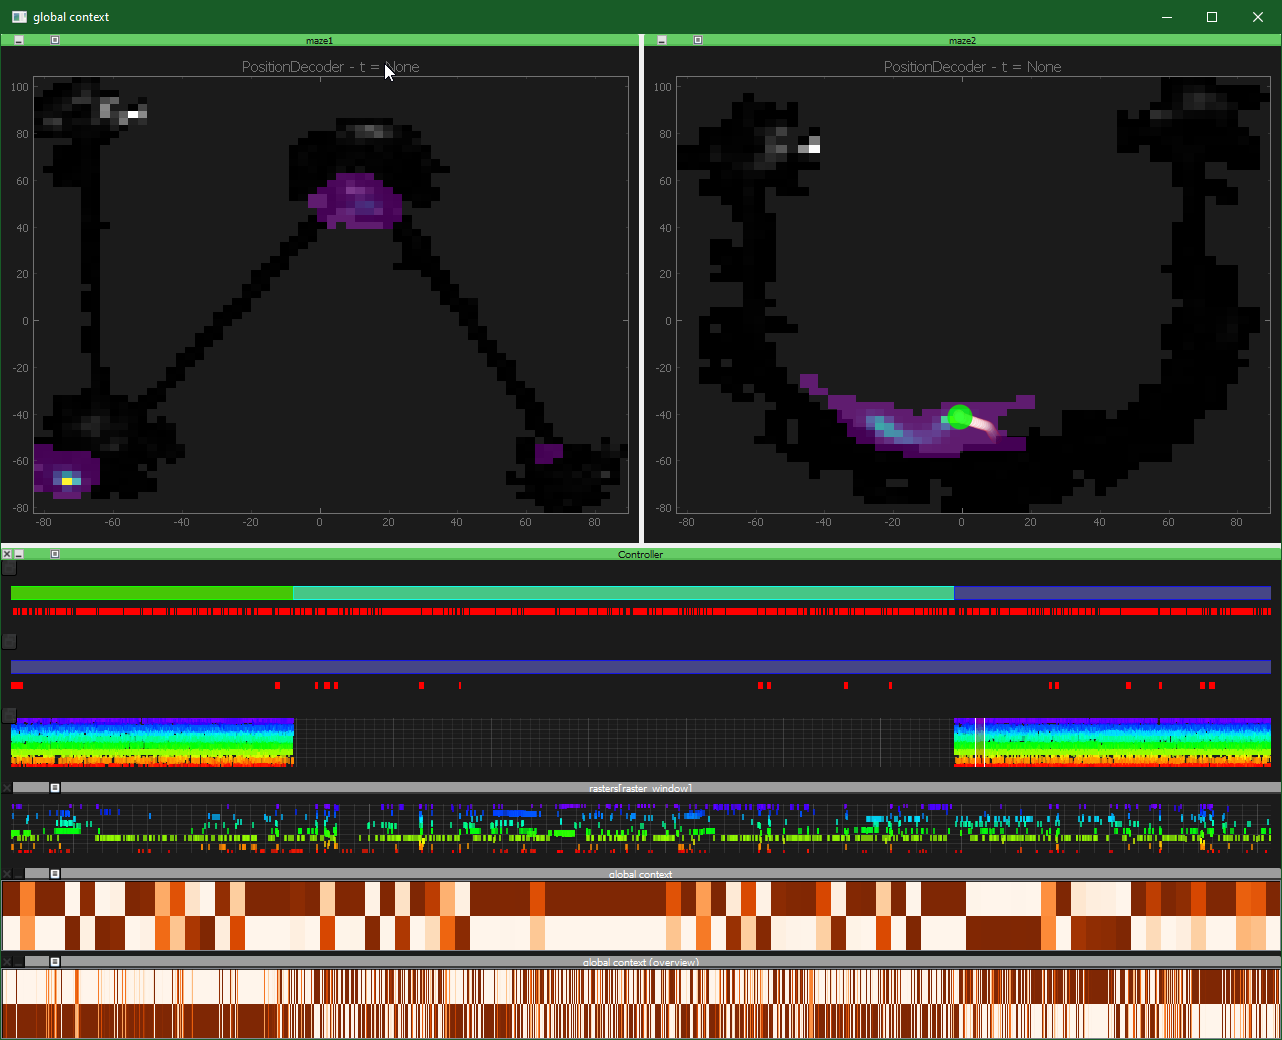

In [ ]:
_out_pbe_tracks, _out_pbe_overview_tracks = _out_container_new.add_pbes_full_result_marginals(pbes_full_result=pbes_full_result)

# grouped_dock_items_dict = _out_container_new.build_overview_and_windowed_dockgroups() ## Not quite ready

## 2025-11-25 - ROIs for track defns

In [ ]:
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.SpikeRasterWidgets.Spike2DRaster import SynchronizedPlotMode

## make sure it adds the 'lin_pos' correctly now
_out = active_2d_plot.add_new_matplotlib_render_plot_widget(name='new_lin_pos')
a_widget, fig, ax, dDisplayItem = _out

active_pos_df: pd.DataFrame = deepcopy(pos_df_dict['maze_GLOBAL'])
# active_pos_df: pd.DataFrame = deepcopy(pos_df_dict['maze1'])
active_pos_df
_out_artist = ax[0].plot(active_pos_df['t'].to_numpy(), active_pos_df['lin_pos'].to_numpy())
active_2d_plot.sync_matplotlib_render_plot_widget(identifier='new_lin_pos', sync_mode=SynchronizedPlotMode.TO_WINDOW)


In [ ]:
pos_df_dict


In [ ]:
from pyphoplacecellanalysis.Pho2D.PyQtPlots.TimeSynchronizedPlotters.Mixins.UserEditableROIMixin import UserEditableROIMixin
from pyphoplacecellanalysis.Pho2D.PyQtPlots.TimeSynchronizedPlotters.TimeSynchronizedPositionDecoderPlotter import TimeSynchronizedPositionDecoderPlotter


a_plotter.enable_user_editable_rois(parent_plot_item=a_plotter.ui.root_plot)

In [ ]:
a_sess = curr_active_pipeline.filtered_sessions[a_maze_key]
a_pos = deepcopy(a_sess.position)

all_roi_crossings = an_rois_obj.find_all_roi_crossings(x_data=a_pos.x, y_data=a_pos.y)
all_roi_crossings


In [ ]:
# a_plotter.getContentsMargins()
a_plotter.params.image_bounds_extent
a_plotter.params.x_range
a_plotter.params.y_range


In [ ]:
a_plot_item = a_plotter.ui.root_plot
vb = a_plot_item.getViewBox()
vb

In [ ]:
## print rois coordinates:
updated_defn_lines = []
for roi in rois:
    # roi.sigRegionChanged.connect(on_roi_update)
    roi_coords = get_roi_coordinates(roi)
    # (roi_coords[0], roi_coords[-1])
    updated_defn_lines.append(f"rois.append(pg.LineROI({roi_coords[0]}, {roi_coords[1]}, width=5, pen=(1,9)))")
    # vb.addItem(roi)

print('\n'.join(updated_defn_lines))


## Reorder the dock items

In [ ]:
list(active_2d_plot.dock_manager_widget.dynamic_display_dict.keys())
# original_identifier_order = ['interval_overview', 'intervals', 'rasters[raster_overview]', 'rasters[raster_window]', 'global context', 'global context (overview)', 'pbe[0.06]', 'pbe[0.06] (Overview)']
desired_identifier_order = ['interval_overview', 'rasters[raster_overview]', 'global context (overview)', 'pbe[0.06] (Overview)', 'rasters[raster_window]', 'intervals', 'global context', 'pbe[0.06]'] ## #TODO 2025-09-21 15:41: - [ ] Enforce this order programmatically?!


In [ ]:
active_2d_plot.dock_manager_widget

In [ ]:

## INPUTS: active_2d_plot
grouped_dock_items_dict = active_2d_plot.ui.dynamic_docked_widget_container.get_dockGroup_dock_dict()
nested_dock_items = {}
nested_dynamic_docked_widget_container_widgets = {}
for dock_group_name, flat_group_dockitems_list in grouped_dock_items_dict.items():
    dDisplayItem, nested_dynamic_docked_widget_container = active_2d_plot.ui.dynamic_docked_widget_container.build_wrapping_nested_dock_area(flat_group_dockitems_list, dock_group_name=dock_group_name)
    nested_dock_items[dock_group_name] = dDisplayItem
    nested_dynamic_docked_widget_container_widgets[dock_group_name] = nested_dynamic_docked_widget_container

## OUTPUTS: nested_dock_items, nested_dynamic_docked_widget_container_widgets

In [ ]:
grouped_dock_items_dict = active_2d_plot.ui.dynamic_docked_widget_container.get_dockGroup_dock_dict()
grouped_dock_items_dict

In [ ]:
grouped_dock_items_dict = build_overview_and_windowed_dockgroups(active_2d_plot)
grouped_dock_items_dict


In [ ]:
_out = active_2d_plot.dock_manager_widget.layout_dockGroups()

# ✅ 2025-12-03 - Add Trapazoid Overview indicator rect

In [30]:
from pyphoplacecellanalysis.External.pyqtgraph_extensions.trapezoid_callout import TrapezoidOverlay

_out_overlays: Dict[Tuple, TrapezoidOverlay] = TrapezoidOverlay.add_overview_indicator_trapazoids_to_timeline(active_2d_plot=active_2d_plot)



### 📈🔃❎ Exporting as video

In [ ]:
from PyQt5 import QtWidgets, QtGui, QtCore
import pyphoplacecellanalysis.External.pyqtgraph as pg
from pyqtgraph.exporters import ImageExporter
from PIL import Image
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.GraphicsWidgets.CustomGraphicsLayoutWidget import CustomGraphicsLayoutWidget

## "playback" refers to output video:
desired_playback_duration: float = 8 * 60.0 # 8m

# "session" refers to the actual recording session:
desired_session_time_range_duration: float = (16.0 * 60.0) # 1m
# session_start_t: float = 23170.37047485091 #20740.63578640229 # 11631.186907154472 # 11451.186907154472 # 11391.186907154472 # 7665.232126354053 # active_2d_plot.total_data_start_time + 4.0 * 60.0 # 4 minutes into start of recording ## Day 5
session_start_t: float = 11023.018433333335 # 10843.018433333334 # active_2d_plot.total_data_start_time + 4.0 * 60.0 # 4 minutes into start of recording
# session_start_t: float = 23170.37047485091 #20740.63578640229 # 11631.186907154472 # 11451.186907154472 # 11391.186907154472 # active_2d_plot.total_data_start_time + 4.0 * 60.0 # 4 minutes into start of recording ## day 4
desired_session_time_range: Tuple[float, float] = (session_start_t, (session_start_t + desired_session_time_range_duration))

playback_speed_factor: float = (desired_playback_duration / desired_session_time_range_duration)

print(f'playback_speed_factor: {playback_speed_factor}')
time_window_duration: float = active_2d_plot.active_window_duration
print(f'time_window_duration: {time_window_duration}')

## INPUTS: _out_container, active_2d_plot, _out_container, sync_plotters, 
desired_framerate: float = 2.0
desired_frame_duration_sec: float = 1.0/desired_framerate
print(f'desired_frame_duration_sec: {desired_frame_duration_sec}')

# ## All Frames from entire recording (too long)
# total_duration: float = active_2d_plot.total_data_duration
# desired_num_total_frames: int = int(np.ceil((total_duration * desired_framerate)))
# frame_start_indicies = np.linspace(active_2d_plot.total_data_start_time,  active_2d_plot.total_data_end_time, num=desired_num_total_frames)

## Plot only for the range of interest:
desired_num_total_frames: int = int(np.ceil((desired_session_time_range_duration * desired_framerate)))
frame_start_indicies = np.linspace(desired_session_time_range[0], desired_session_time_range[1], num=desired_num_total_frames)
frame_end_indices = frame_start_indicies + desired_frame_duration_sec

print(f'desired_num_total_frames: {desired_num_total_frames}')


In [ ]:
# ## Disable debug print to speed up animation
for a_plotter_name, a_plotter in sync_plotters.items():
    a_plotter.params.debug_print = False

In [ ]:
active_2d_plot.active_window_start_time

In [ ]:
# next_end_timestamp = next_start_timestamp + self.animation_active_time_window.window_duration

def _frame_update(frame_start_t, frame_end_t):
    active_2d_plot.update_scroll_window_region(frame_start_t, frame_end_t, block_signals=True)
    active_2d_plot.window_scrolled.emit(frame_start_t, frame_end_t)
    QtWidgets.QApplication.processEvents()
    win.repaint()


_frame_update(desired_session_time_range[0], (desired_session_time_range[0]+time_window_duration))


In [ ]:
for i, (frame_start_t, frame_end_t) in enumerate(zip(frame_start_indicies, frame_end_indices)):
    print(f'frame[{i}]: ({frame_start_t}, {frame_end_t}):')
    # active_2d_plot.on_window_changed(frame_start_t, frame_end_t)
    # active_2d_plot.update_scroll_window_region(frame_start_t, frame_end_t, block_signals=True)
    # active_2d_plot.window_scrolled.emit(frame_start_t, frame_end_t)
    # pg.SignalProxy(driver.window_scrolled, delay=0.2, rateLimit=60, slot=drivable.on_window_changed_rate_limited)
    # QtWidgets.QApplication.processEvents()
    # win.repaint()
    # _frame_update(frame_start_t, frame_end_t)
    _frame_update(frame_start_t, (frame_start_t + time_window_duration))


##### NOT WORKING YET: Export both to a multi-page PDF or video


In [ ]:
from pyphoplacecellanalysis.General.Mixins.ExportHelpers import FigureToImageHelpers

all_tracks_export_path = curr_active_pipeline.get_output_path().joinpath('2025-09-19_910pm_time_synch_dual_plotters.pdf')

## INPUTS: 
_out_container: GenericPyQtGraphContainer
active_2d_plot: Spike2DRaster = _out_container.ui.controlling_widget
sync_plotters = _out_container.ui.sync_plotters

saved_output_pdf_path = FigureToImageHelpers.export_wrapped_tracks_to_paged_df(active_2d_plot, output_pdf_path=all_tracks_export_path)
print(f'saved_output_pdf_path: {saved_output_pdf_path}')


In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.DecoderPredictionError import _temp_debug_two_step_plots_animated_pyqtgraph

# Simple plot type 1:
# plotted_variable_name = kwargs.get('variable_name', 'p_x_given_n') # Tries to get the user-provided variable name, otherwise defaults to 'p_x_given_n'
plotted_variable_name = 'p_x_given_n' # Tries to get the user-provided variable name, otherwise defaults to 'p_x_given_n'
_temp_debug_two_step_plots_animated_pyqtgraph(active_one_step_decoder, active_two_step_decoder, active_computed_data.extended_stats.time_binned_position_df, variable_name=plotted_variable_name) # Works

### OLD EXPLORE ONLY

In [ ]:
a_plotter.params.trajectory_path_marker_max_fill_opacity

In [ ]:
a_plotter.params.recent_position_trajectory_max_seconds_ago

In [ ]:
a_plotter.curr_recent_trajectory

In [ ]:
# a_plotter.ui.im
import pyphoplacecellanalysis.External.pyqtgraph as pg

# from PyQt5 import QtGui
# import pyphoplacecellanalysis.External.pyqtgraph.Qt as pg

from PyQt5.QtGui import QPainter


traj_curve_item: pg.PlotDataItem = a_plotter.ui.trajectory_curve
# traj_curve_item.show()



traj_curve_item.setAlpha(1.0, auto=False)
traj_curve_item.setSymbolBrush((50, 50, 50, 25))


# from QtGui.QPainter import 
# pg.QtGui.QPainter

# from pg import QtGui
# from PyQt5.QtGui.QPainter import CompositionMode

# from pg.QtGui.QPainter import CompositionMode
# QPainter.CompositionMode.CompositionMode_Overlay


In [ ]:


# a_plotter.ui.imv.setCompositionMode(QPainter.CompositionMode_Multiply)
# a_plotter.ui.imv.setCompositionMode(QPainter.CompositionMode_Overlay)
a_plotter.ui.imv.setCompositionMode(QPainter.CompositionMode_Plus)



In [ ]:
a_plotter.active_one_step_decoder.time_window_centers


In [ ]:
# a_plotter.ui.trajectory_curve.
a_plotter.params.recent_position_trajectory_path_shadow_pen
a_plotter.params.recent_position_trajectory_path_pen



In [ ]:
a_plotter.params.recent_position_trajectory_symbol_pen

pg.mkPen(a_plotter.params.recent_position_trajectory_symbol_pen.color(), 

In [ ]:
a_plotter.params.recent_position_trajectory_symbol_pen.color().setAlphaF(0.1)

pg.mkBrush(

In [ ]:
a_plotter.params

In [ ]:
a_plotter.ui.trajectory_curve.setPen(a_plotter.params.recent_position_trajectory_symbol_pen)

In [ ]:
sync_plotters

### Build Marginals over track context and plot them on the timeline

In [ ]:
from pyphoplacecellanalysis.Analysis.Decoder.reconstruction import DecodedFilterEpochsResult, SingleEpochDecodedResult
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import _add_context_marginal_to_timeline, _add_context_decoded_epoch_marginals_to_timeline


In [ ]:
# decoded_epochs_track_name: str = f'{epochs_name}[{decoding_time_bin_size}]'

_out = _add_context_marginal_to_timeline(active_2d_plot, a_filter_epochs_decoded_result=all_context_filter_epochs_decoder_result, name='global context')
_out_pbe_tracks = _add_context_decoded_epoch_marginals_to_timeline(active_2d_plot=active_2d_plot, decoded_epochs_result=pbe_decoder_result, name=f"pbe[{decoding_time_bin_size}]")


In [ ]:
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.SpikeRasterWidgets.Spike2DRaster import SynchronizedPlotMode

_out_new = _add_context_marginal_to_timeline(active_2d_plot, a_filter_epochs_decoded_result=all_context_filter_epochs_decoder_result, name='global context (overview)')
_out_new

identifier_name, widget, matplotlib_fig, matplotlib_fig_axes, dock_item = _out_new

# ⚓✅💾 Export ALL tracks (both plotting backends)

In [ ]:
active_2d_plot.dock_manager_widget.get_leaf_only_flat_dock_identifiers_list() # ['interval_overview', 'intervals', 'rasters[raster_overview]', 'rasters[raster_window]', 'new_curves_separate_plot']

In [ ]:
from pyphoplacecellanalysis.Pho2D.PyQtPlots.TimeSynchronizedPlotters.PyqtgraphTimeSynchronizedWidget import PyqtgraphTimeSynchronizedWidget
from pyphoplacecellanalysis.Pho2D.matplotlib.MatplotlibTimeSynchronizedWidget import MatplotlibTimeSynchronizedWidget
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.image as mimage
from pyphoplacecellanalysis.General.Mixins.ExportHelpers import FigureToImageHelpers
from pyphoplacecellanalysis.General.Model.Configs.LongShortDisplayConfig import DisplayColorsEnum

# relative_data_output_parent_folder = Path('data').resolve()

relative_data_output_parent_folder = curr_active_pipeline.get_output_path().resolve()
Assert.path_exists(relative_data_output_parent_folder)

## INPUTS: im_posterior_x_stack, track_labels, 
output_pdf_path: Path = relative_data_output_parent_folder.joinpath('2025-12-03_all_timeline_tracks_exported_stack.pdf')

included_track_dock_identifiers = None
# included_track_dock_identifiers = [
# 	# 'interval_overview',
# 	'intervals',
# 	# 'rasters[raster_overview]',
# 	'rasters[raster_window]',
# 	'new_curves_separate_plot',
# 	# 'mpl_position_curves',
# 	#  'MenuCommand_display_plot_marginal_1D_most_likely_position_comparisons',
# 	 'global context',
# 	#  'global context (overview),
# ]


# track_labels: List[str] = list(included_track_dock_identifiers_to_track_labels_dict.values())
track_labels = None
saved_output_pdf_path = FigureToImageHelpers.export_wrapped_tracks_to_paged_df(active_2d_plot, output_pdf_path=output_pdf_path, included_track_dock_identifiers=included_track_dock_identifiers, track_labels=track_labels,
																			    debug_max_num_pages=250)

## OUTPUTS: output_pdf_path, included_track_dock_identifiers

PDF saved to H:\Data\Bapun\RatS\Day5TwoNovel\output\2025-12-03_all_timeline_tracks_exported_stack.pdf


In [ ]:
from pyphoplacecellanalysis.General.Model.Configs.LongShortDisplayConfig import DisplayColorsEnum

formatted_title_strings_dict = DisplayColorsEnum.get_matplotlib_formatted_title_dict()
decoder_names_list: List[str] = list(formatted_title_strings_dict.keys())

## get the whole stack
# active_dockGroup_dock_dict = active_2d_plot.get_dockGroup_dock_dict()
# _curr_active_dock_group = active_dockGroup_dock_dict['ContinuousDecode_ - t_bin_size: 0.025'] # {'long_LR': 'Long◀', 'long_RL': 'Long▶', 'short_LR': 'Short◀', 'short_RL': 'Short▶'}
# _curr_decoders_dock_item_names_list: List[str] = [v.name() for v in _curr_active_dock_group] # ['ContinuousDecode_long_LR - t_bin_size: 0.025', 'ContinuousDecode_long_RL - t_bin_size: 0.025', 'ContinuousDecode_short_LR - t_bin_size: 0.025', 'ContinuousDecode_short_RL - t_bin_size: 0.025']
_curr_decoders_dock_item_names_list: List[str] = deepcopy(included_track_dock_identifiers)
_curr_decoders_dock_item_names_list

_curr_decoder_name_to_decoders_dock_item_name_map = {}
_remaining_dock_names = set(_curr_decoders_dock_item_names_list)

# _curr_decoders_dock_item_names_list
for a_decoder_name in decoder_names_list:
	for a_dock_name in _remaining_dock_names: #_curr_decoders_dock_item_names_list:
		if (a_decoder_name in a_dock_name):
			_curr_decoder_name_to_decoders_dock_item_name_map[a_decoder_name] = a_dock_name
			_remaining_dock_names.remove(a_dock_name)
			break

assert len(_curr_decoder_name_to_decoders_dock_item_name_map) == len(decoder_names_list), f"decoder_names_list: {decoder_names_list} != list(_curr_decoder_name_to_decoders_dock_item_name_map.keys()): {_curr_decoder_name_to_decoders_dock_item_name_map}"
track_labels: List[str] = [formatted_title_strings_dict[a_decoder_name] for a_decoder_name, a_dock_name in _curr_decoder_name_to_decoders_dock_item_name_map.items()]
track_labels

In [ ]:
found_heterogeneous_stack, normalized_track_heights, included_track_dock_identifiers = FigureToImageHelpers.perform_export_wrapped_tracks_to_paged_df(active_2d_plot, included_track_dock_identifiers=None)



#### Testing multiple matplotlib tracks at the same time

In [ ]:
# formatted_title_strings_dict = DisplayColorsEnum.get_matplotlib_formatted_title_dict()
# decoder_names_list: List[str] = list(formatted_title_strings_dict.keys())

# ## get the whole stack
# active_dockGroup_dock_dict = active_2d_plot.get_dockGroup_dock_dict()
# _curr_active_dock_group = active_dockGroup_dock_dict['ContinuousDecode_ - t_bin_size: 0.025'] # {'long_LR': 'Long◀', 'long_RL': 'Long▶', 'short_LR': 'Short◀', 'short_RL': 'Short▶'}
# _curr_decoders_dock_item_names_list: List[str] = [v.name() for v in _curr_active_dock_group] # ['ContinuousDecode_long_LR - t_bin_size: 0.025', 'ContinuousDecode_long_RL - t_bin_size: 0.025', 'ContinuousDecode_short_LR - t_bin_size: 0.025', 'ContinuousDecode_short_RL - t_bin_size: 0.025']
# im_posterior_x_stack = [v.widgets[0].plots.im_posterior_x for v in _curr_active_dock_group]

# _curr_decoder_name_to_decoders_dock_item_name_map = {}
# _remaining_dock_names = set(_curr_decoders_dock_item_names_list)

# # _curr_decoders_dock_item_names_list
# for a_decoder_name in decoder_names_list:
# 	for a_dock_name in _remaining_dock_names: #_curr_decoders_dock_item_names_list:
# 		if (a_decoder_name in a_dock_name):
# 			_curr_decoder_name_to_decoders_dock_item_name_map[a_decoder_name] = a_dock_name
# 			_remaining_dock_names.remove(a_dock_name)
# 			break

# assert len(_curr_decoder_name_to_decoders_dock_item_name_map) == len(decoder_names_list), f"decoder_names_list: {decoder_names_list} != list(_curr_decoder_name_to_decoders_dock_item_name_map.keys()): {_curr_decoder_name_to_decoders_dock_item_name_map}"
# track_labels: List[str] = [formatted_title_strings_dict[a_decoder_name] for a_decoder_name, a_dock_name in _curr_decoder_name_to_decoders_dock_item_name_map.items()]
# track_labels

## OUTPUTS: im_posterior_x_stack, track_labels
FigureToImageHelpers.export_wrapped_axesimage_to_paged_pdf(ax_image=found_matplotlib_stack, x_extent=(active_2d_plot.total_data_start_time, active_2d_plot.total_data_end_time), chunk_width=active_2d_plot.active_window_duration, output_pdf_path=output_pdf_path, figsize=(8, 11), dpi=150,
        												rows_per_page=5, debug_max_num_pages=3,		    
                                                        # rows_per_page=15, debug_max_num_pages=3,
														# track_labels=track_labels,
                                                    )



# 2025-11-24 - New Stuff

In [ ]:
## INPUTS: _out_container_new, active_2d_plot, sync_plotters, win
active_2d_plot.active_window_start_time

In [ ]:
active_2d_plot.active_time_window # (11175.598695527338, 11367.566595040325)


In [ ]:
active_2d_plot.active_time_window = active_2d_plot.active_time_window + 0.01

In [ ]:
active_2d_plot.playback_controller

In [ ]:
# Set both start and end times
new_start_time = 100.0
new_end_time = new_start_time + active_2d_plot.render_window_duration
active_2d_plot.update_scroll_window_region(new_start_time, new_end_time, block_signals=True)

In [ ]:
active_2d_plot.update_scroll_window_region(11175.598695527338, 11367.566595040325, block_signals=False)

In [ ]:
# Assuming you have active_2d_plot as your SpikeRaster2D instance
new_start_time = 100.0  # seconds
active_2d_plot.spikes_window.timeWindow.active_window_start_time = new_start_time

In [ ]:
# Get current time
current_time = active_2d_plot.active_window_start_time

# Advance by 10 seconds
new_time = current_time + 10.0
active_2d_plot.update_scroll_window_region(new_time, new_time + active_2d_plot.render_window_duration, block_signals=True)

In [ ]:
results1D.


# 2025-11-25 - `traja` trajectory analysis for determining runs

In [ ]:
import traja
from neuropy.core.position import Position, PositionAccessor

sess = deepcopy(curr_active_pipeline.sess)
# sess.active_maze_epochs_df
pos: Position = deepcopy(sess.position)
pos.compute_speed_info()
pos_df: pd.DataFrame = pos.to_dataframe()
pos_df

In [ ]:
# anim = traja.plotting.animate(pos_df, polar=False, save=False) # save=True saves to 'trajectory.mp4'

pos_df['time_sec'] = deepcopy(pos_df['t'])
trj = traja.TrajaDataFrame(pos_df)
trj = traja.smooth_sg(trj, w=5) #.head()
fast_pos_intervals = traja.speed_intervals(trj, faster_than=12.0, slower_than=100.0)
fast_pos_intervals

In [ ]:
trj = traja.smooth_sg(trj, w=5) #.head()
trj

In [ ]:
from neuropy.core.laps import LapsAccessor, Laps

lap_only_linear_pos_df, lap_only_pos_df, (lap_dir_2D_dict, lap_dir_1D_dict) = LapsAccessor.non_kdiba_laps_determine_directions(sess=curr_active_pipeline.sess)


In [ ]:
lap_only_linear_pos_df

In [ ]:
lap_1D_start_end_epochs = deepcopy(lap_only_linear_pos_df).groupby(['lap']).agg(t_first=('t', 'first'), t_last=('t', 'last'), t_idxmin=('t', 'idxmin'), t_idxmax=('t', 'idxmax')).reset_index().astype({'t_idxmin': 'uint64', 't_idxmax': 'uint64'})
lap_1D_start_end_epochs = lap_1D_start_end_epochs.rename(columns={'t_first': 'start', 't_last': 'stop'})
lap_1D_start_end_epochs['label'] = deepcopy(lap_1D_start_end_epochs['lap'])
lap_1D_start_end_epochs = lap_1D_start_end_epochs.epochs.to_dataframe()
lap_1D_start_end_epochs



In [ ]:
# lap_dir_1D_dict
_lap_1D_intervals_out = active_2d_plot.add_rendered_intervals(lap_1D_start_end_epochs, name='lap_1D', debug_print=True)


In [ ]:
lap_only_pos_df

In [ ]:
# Build velocity widget ______________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________ #
_out = active_2d_plot.add_new_matplotlib_render_plot_widget(name='velocity', sync_mode=None)
a_widget, fig, ax, dDisplayItem = _out

# 1. Extract columns as numpy arrays
# x = pos_df['t'].astype(float).to_numpy()
# y = pos_df['speed_xy'].astype(float).to_numpy()
clean_df: pd.DataFrame = pos_df[['t', 'speed_xy']].dropna(inplace=False, how='any')
t_clean = pd.to_numeric(clean_df['t'], errors='coerce').to_numpy()
speed_clean = pd.to_numeric(clean_df['speed_xy'], errors='coerce').to_numpy()

# t_clean = pd.to_numeric(pos_df['t'], errors='coerce').to_numpy()
# speed_clean = pd.to_numeric(pos_df['speed_xy'], errors='coerce').to_numpy()

# print(pos_df[['t', 'speed_xy']].dtypes)

_out_line = ax[0].plot(t_clean, speed_clean, label='speed_xy')

# Find fast periods __________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________ #
## find periods over 10.0
is_fast = (speed_clean > 10.0)
is_fast

fast_only_speed = deepcopy(speed_clean)
fast_only_speed[np.logical_not(is_fast)] = np.nan ## NaN out the slow values
fast_only_t = deepcopy(t_clean) #

_out_line_fast_only = ax[0].plot(fast_only_t, fast_only_speed, label='speed_xy_fast', c='r')

## Sync to update
active_2d_plot.sync_matplotlib_render_plot_widget(identifier='velocity')


In [ ]:
plt.hist(speed_clean, bins=150)


In [ ]:
active_2d_plot.sync_matplotlib_render_plot_widget(identifier='velocity')

# 2025-11-25 - Testing

In [ ]:
_out = dict()
_out['_display_trial_to_trial_reliability'] = curr_active_pipeline.display(display_function='_display_trial_to_trial_reliability', active_session_configuration_context=None) # _display_trial_to_trial_reliability


In [ ]:
_out = dict()
_out['_display_placefield_stable_formation_time_distribution'] = curr_active_pipeline.display(display_function='_display_placefield_stable_formation_time_distribution', active_session_configuration_context=None) # _display_placefield_stable_formation_time_distribution


In [ ]:
_out = dict()
_out['_display_trial_to_trial_reliability'] = curr_active_pipeline.display(display_function='_display_trial_to_trial_reliability', active_session_configuration_context=None) # _display_trial_to_trial_reliability


# 2025-11-25 - Export entire timeline efficiently

In [ ]:
def export_video(_out_container_new, output_path: str, start_t: Optional[float] = None, end_t: Optional[float] = None, fps: float = 30.0, progress_print: bool = True, debug_print: bool = False):
    """Efficiently export a video from the TimeSynchronizedPositionDecoderPlotter instance (faster than real-time playback)
    
    This method iterates through time points, updates the plotter, captures frames using
    pyqtgraph's ImageExporter, and saves them as a video using OpenCV.
    
    Args:
        output_path: Path to save the output video file (e.g., 'output/videos/decoder_video.avi')
        start_t: Start time for video export. If None, uses the first available time window center.
        end_t: End time for video export. If None, uses the last available time window center.
        fps: Frames per second for the output video (default: 30.0)
        width: Width of exported frames in pixels. If None, uses current widget width.
        height: Height of exported frames in pixels. If None, uses current widget height.
        progress_print: Whether to print progress messages (default: True)
        debug_print: Whether to print debug information (default: False)
        
    Returns:
        Path: Path to the saved video file
        
    Usage:
        plotter = TimeSynchronizedPositionDecoderPlotter(...)
        video_path = plotter.export_video('output/videos/decoder.avi', start_t=100.0, end_t=200.0, fps=30.0)
    """
    from pyphoplacecellanalysis.External.pyqtgraph.exporters.ImageExporter import ImageExporter
    from pyphoplacecellanalysis.External.pyqtgraph import functions as fn
    from pathlib import Path
    import cv2
    import sys
    

    active_2d_plot: Spike2DRaster = _out_container_new.ui.controlling_widget
    sync_plotters: Dict[str, TimeSynchronizedPositionDecoderPlotter] = _out_container_new.ui.sync_plotters
    win: PhoDockAreaContainingWindow = _out_container_new.ui.root_dockAreaWindow

    assert output_path.is_dir(), f"output_path: {output_path} should be a directory to output to."
    _out_paths = {}
    for a_plotter_key, a_plotter in sync_plotters.items():
        a_plotter.ui.root_graphics_layout_widget.setBackground('w')
        
        a_out_vid_path = output_path.joinpath(f'{a_plotter_key}.avi')
        a_vid_file_path = a_plotter.export_video(output_path=a_out_vid_path, start_t=start_t, end_t=end_t, fps=fps, progress_print=progress_print, debug_print=debug_print)
        _out_paths[a_plotter_key] = a_vid_file_path
    
    return _out_paths

parent_export_path = curr_active_pipeline.get_output_path().resolve().joinpath('videos', '2025-11-25')
parent_export_path.mkdir(exist_ok=True, parents=True)
_out_paths = export_video(_out_container_new, output_path=parent_export_path)
_out_paths


# Continue

In [ ]:
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import plot_attached_BinByBinDecodingDebugger, add_continuous_decoded_posterior
## Plot one of the continuous results for the most recently computed time_bin_size:

curr_active_pipeline.reload_default_computation_functions()
(nested_dock_items, nested_dynamic_docked_widget_container_widgets), (a_continuously_decoded_dict, pseudo2D_decoder, all_directional_pf1D_Decoder_dict) = add_continuous_decoded_posterior(spike_raster_window=spike_raster_window, curr_active_pipeline=curr_active_pipeline, desired_time_bin_size=0.05, debug_print=True)


In [ ]:
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import plot_attached_BinByBinDecodingDebugger, add_continuous_decoded_posterior

# all_directional_pf1D_Decoder_dict
# a_decoder_name: str = 'long'
# a_decoder = results1D.decoders[a_decoder_name]
# a_decoded_result = results1D.continuous_results[a_decoder_name]

## INPUTS: all_directional_pf1D_Decoder_dict

# a_decoder_name: str = 'long_LR'


# a_decoder_name: str = 'short_LR'
a_decoder_name: str = 'maze1'
a_decoder = all_directional_pf1D_Decoder_dict[a_decoder_name]
# a_decoded_result = a_continuously_decoded_dict[a_decoder_name]
a_decoded_result = a_continuously_decoded_dict['pseudo2D']

## INPUTS: a_decoder, a_decoded_result
bin_by_bin_debugger, win, out_pf1D_decoder_template_objects, (plots_container, plots_data), _on_update_fcn = plot_attached_BinByBinDecodingDebugger(spike_raster_window, curr_active_pipeline, a_decoder=a_decoder, a_decoded_result=a_decoded_result, n_max_debugged_time_bins=50, name_suffix=a_decoder_name)

In [ ]:
all_directional_pf1D_Decoder_dict

In [ ]:
from pyphoplacecellanalysis.Analysis.Decoder.reconstruction import BasePositionDecoder, DecodedFilterEpochsResult, SingleEpochDecodedResult
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import DirectionalDecodersContinuouslyDecodedResult

## Uses the `global_computation_results.computed_data['DirectionalDecodersDecoded']`
directional_decoders_decode_result: DirectionalDecodersContinuouslyDecodedResult = curr_active_pipeline.global_computation_results.computed_data['DirectionalDecodersDecoded']
# all_directional_pf1D_Decoder_dict: Dict[str, BasePositionDecoder] = directional_decoders_decode_result.pf1D_Decoder_dict
pseudo3D_decoder: BasePositionDecoder = directional_decoders_decode_result.pseudo2D_decoder
all_directional_pf1D_Decoder_dict: Dict[str, BasePositionDecoder] = directional_decoders_decode_result.pf1D_Decoder_dict
continuously_decoded_result_cache_dict = directional_decoders_decode_result.continuously_decoded_result_cache_dict
continuously_decoded_pseudo2D_decoder_dict = directional_decoders_decode_result.continuously_decoded_pseudo2D_decoder_dict
# continuously_decoded_result_cache_dict

## Unpacking a result:
all_context_filter_epochs_decoder_result: SingleEpochDecodedResult = list(continuously_decoded_pseudo2D_decoder_dict.values())[-1]
marginal_z: NDArray = all_context_filter_epochs_decoder_result.marginal_z.p_x_given_n

time_bin_size: float = list(directional_decoders_decode_result.continuously_decoded_result_cache_dict.keys())[0] ## get the first 
print(f'time_bin_size: {time_bin_size}')
a_continuously_decoded_dict = directional_decoders_decode_result.continuously_decoded_result_cache_dict.get(time_bin_size, None)
info_string: str = f" - t_bin_size: {time_bin_size}"


In [ ]:
a_continuously_decoded_dict['pseudo2D'].marginal_x

In [ ]:
all_context_filter_epochs_decoder_result.marginal_x

active_plot_2d.add_

In [ ]:
all_directional_pf1D_Decoder_dict

In [ ]:
from pyphoplacecellanalysis.General.Model.Configs.LongShortDisplayConfig import DisplayColorsEnum
from pyphoplacecellanalysis.GUI.PyQtPlot.DockingWidgets.DynamicDockDisplayAreaContent import CustomDockDisplayConfig, DockDisplayColors
from pyphoplacecellanalysis.Analysis.Decoder.reconstruction import DecodedFilterEpochsResult


# search_context = IdentifyingContext(pfND_ndim=1, decoder_identifier='pseudo2D', known_named_decoding_epochs_type='global') # , data_grain= 'per_time_bin -- not really relevant: ['masked_time_bin_fill_type', 'known_named_decoding_epochs_type', 'data_grain']
# flat_context_list, flat_result_context_dict, flat_decoder_context_dict, flat_decoded_marginal_posterior_df_context_dict = a_new_fully_generic_result.get_results_matching_contexts(context_query=search_context, return_multiple_matches=True, debug_print=True)
# # a_context, a_result, a_decoder, _ = a_new_fully_generic_result.get_results_matching_contexts(context_query=search_context, return_multiple_matches=False, debug_print=True)
# # a_decoder
# flat_context_list
# flat_decoder_context_dict

a_target_context: IdentifyingContext = IdentifyingContext(trained_compute_epochs='laps', pfND_ndim=1, decoder_identifier='pseudo2D', time_bin_size=0.025, masked_time_bin_fill_type='ignore', data_grain='per_time_bin', known_named_decoding_epochs_type= 'global') # , known_named_decoding_epochs_type='laps'
flat_context_list, flat_result_context_dict, flat_decoder_context_dict, flat_decoded_marginal_posterior_df_context_dict = a_new_fully_generic_result.get_results_matching_contexts(context_query=a_target_context, return_multiple_matches=True, debug_print=True)
# print(f'flat_context_list: {flat_context_list}')
flat_decoded_marginal_posterior_df_context_dict

unique_decoder_names_map: Dict = {'laps': ['long_LR', 'long_RL', 'short_LR', 'short_RL'], 'non_pbe': ['long', 'short']}


for a_ctxt, a_result in flat_result_context_dict.items():
    ## INPUTS: laps_pseudo2D_continuous_specific_decoded_result: DecodedFilterEpochsResult
    a_decoder = flat_decoder_context_dict[a_ctxt]
    
    unique_decoder_names = unique_decoder_names_map[a_ctxt.get('trained_compute_epochs', None)] # ['long', 'short']
    unique_decoder_names = [f"{a_ctxt}[{k}]" for k in unique_decoder_names]
    
    a_pseudo2D_split_to_1D_continuous_results_dict: Dict[types.DecoderName, DecodedFilterEpochsResult] = a_result.split_pseudo2D_result_to_1D_result(pseudo2D_decoder_names_list=unique_decoder_names)    
    a_pseudo2D_split_to_1D_continuous_results_dict = {k:v for k, (_o, v) in zip(unique_decoder_names, a_pseudo2D_split_to_1D_continuous_results_dict.items())} ## change to the long unique indicies so they match the decoders
    
    # a_pseudo2D_split_to_1D_continuous_results_dict
    
    active_time_bin_size: float = a_result.decoding_time_bin_size
    info_string: str = f'{active_time_bin_size:.3f}'
    dock_group_sep_character: str = '_'
    showCloseButton = True
    _common_dock_config_kwargs = {'dock_group_names': [dock_group_sep_character.join([f'LapsDecode', info_string])], 'showCloseButton': showCloseButton, 'showTimelineSyncModeButton': True}

    # dock_configs: Dict[str, CustomDockDisplayConfig] = {k:deepcopy(CustomDockDisplayConfig(custom_get_colors_callback_fn=DisplayColorsEnum.Epochs.get_global_dock_colors, **_common_dock_config_kwargs)) for k in unique_decoder_names}
    dock_configs: Dict[str, CustomDockDisplayConfig] = {k:deepcopy(CustomDockDisplayConfig(custom_get_colors_callback_fn=DockDisplayColors.get_random_dock_colors_for_key_fn(key=k), **_common_dock_config_kwargs)) for k in unique_decoder_names}
    
    # flat_decoder_context_dict

    # pf1D_Decoder_dict = {k:deepcopy(v) for k, v in a_decoder.items() if k in unique_decoder_names}

    pf1D_Decoder_dict = {k:deepcopy(a_decoder) for k in unique_decoder_names} ## this is dumb, but it provides xlims!

    output_dict = active_2d_plot.add_docked_decoded_results_dict_tracks(name=f'LapsDecode', a_decoded_result_dict=a_pseudo2D_split_to_1D_continuous_results_dict, dock_configs=dock_configs,
                                                                                                pf1D_Decoder_dict=pf1D_Decoder_dict,
                                                                                                measured_position_df=deepcopy(curr_active_pipeline.sess.position.to_dataframe()),
                                                                                                extended_dock_title_info=info_string)


    # # pf1D_Decoder_dict = {k:deepcopy(v) for k, v in a_decoder.items() if k in unique_decoder_names}

    # ## a_1D_continuous_decoded_result: SingleEpochDecodedResult
    # a_dock_config = dock_configs[a_decoder_name]
    # a_1D_decoder: BasePositionDecoder = pf1D_Decoder_dict[a_decoder_name]
    # _out_tuple = self.add_docked_decoded_posterior_track_from_result(name=f'{name}[{a_decoder_name}]', a_dock_config=a_dock_config, a_1D_decoded_result=a_1D_decoded_result,
    #                                                                                         xbin = deepcopy(a_1D_decoder.xbin), measured_position_df=deepcopy(measured_position_df), **kwargs) # , should_defer_render=False
    # identifier_name, widget, matplotlib_fig, matplotlib_fig_axes, dDisplayItem = _out_tuple
    # ## Add `a_decoded_result` to the plots_data
    # widget.plots_data.a_decoded_result = a_1D_decoded_result
    # widget.plots_data.a_decoder = deepcopy(a_1D_decoder)
    # output_dict[a_decoder_name] = (identifier_name, widget, matplotlib_fig, matplotlib_fig_axes, dDisplayItem) ## add again


# output_dict = active_2d_plot.add_docked_decoded_results_dict_tracks(name=f'LapsDecode', a_decoded_result_dict=a_pseudo2D_split_to_1D_continuous_results_dict, dock_configs=dock_configs, pf1D_Decoder_dict=flat_decoder_context_dict,
#                                                                                             measured_position_df=deepcopy(curr_active_pipeline.sess.position.to_dataframe()),
#                                                                                             extended_dock_title_info=info_string)



# 📈🎨🖼️ 2025-02-10 - 2D Decoded Posterior frames/snapshots by subdivision

NOTE: ## INPUTS: test_epoch_specific_decoded_results2D_dict, continuous_specific_decoded_results2D_dict, new_decoder2D_dict, new_pf2Ds_dict # NOTE: 2D results

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.EpochComputationFunctions import ComputeGlobalEpochBase
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.EpochComputationFunctions import DecodingResultND

a_new_global_epoch_base_obj: ComputeGlobalEpochBase = ComputeGlobalEpochBase.init_from_pipeline(curr_active_pipeline=curr_active_pipeline)
global_only_epoch = deepcopy(a_new_global_epoch_base_obj.single_global_epoch_df)
global_only_epoch

In [ ]:
# epochs_decoding_time_bin_size=0.100
# frame_divide_bin_size=0.500

# epochs_decoding_time_bin_size = 1.0
epochs_decoding_time_bin_size = 0.25 # 250ms
frame_divide_bin_size = 4.0

# with VizTracer(output_file=f"viztracer_{get_now_time_str()}-ComputeGlobalEpochBase_compute_all.json", min_duration=200, tracer_entries=30000000, ignore_frozen=True) as tracer:
# results1D, results2D = ComputeGlobalEpochBase.compute_all(curr_active_pipeline, single_global_epoch=global_only_epoch, epochs_decoding_time_bin_size=epochs_decoding_time_bin_size, frame_divide_bin_size=frame_divide_bin_size, compute_1D=False, compute_2D=True)

## Compute results1D
results1D, _ = ComputeGlobalEpochBase.compute_all(curr_active_pipeline, single_global_epoch=global_only_epoch, epochs_decoding_time_bin_size=epochs_decoding_time_bin_size, frame_divide_bin_size=frame_divide_bin_size, compute_1D=True, compute_2D=False)

# results1D, results2D = ComputeGlobalEpochBase.compute_all(curr_active_pipeline, single_global_epoch=global_only_epoch, epochs_decoding_time_bin_size=0.050, frame_divide_bin_size=0.50, compute_1D=False, compute_2D=True)

### Save `results2D` to pickle

In [ ]:
parent_export_path = curr_active_pipeline.get_output_path().resolve()
# an_export_basepath = parent_export_path.joinpath(f'{BATCH_DATE_TO_USE}_{epochs_decoding_time_bin_size}_results1D.pkl')
an_export_basepath = parent_export_path.joinpath(f'{BATCH_DATE_TO_USE}_{epochs_decoding_time_bin_size}_results2D.pkl')
print(f'an_export_basepath: {an_export_basepath}')
out_PKL_export_path: Path = an_export_basepath.with_suffix('.pkl').resolve()
out_HDF5_export_path: Path = an_export_basepath.with_suffix('.hdf').resolve()
print(f'out_PKL_export_path: {out_PKL_export_path}')


In [ ]:

results2D.save(pkl_output_path=out_PKL_export_path)
# results1D.save(pkl_output_path=out_PKL_export_path)


### Load `results1D` from pickle

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.EpochComputationFunctions import DecodingResultND

parent_export_path = curr_active_pipeline.get_output_path().resolve()
out_PKL_export_path: Path = parent_export_path.joinpath("2025-11-25_Apogee_0.25_results1D.pkl").resolve()
Assert.path_exists(out_PKL_export_path)
results1D = DecodingResultND.from_file(pkl_path=out_PKL_export_path)

In [ ]:
results1D.continuous_results
results1D.

### Load `results2D` from pickle

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.EpochComputationFunctions import DecodingResultND

parent_export_path = curr_active_pipeline.get_output_path().resolve()
out_PKL_export_path: Path = parent_export_path.joinpath("2025-11-25_Apogee_0.25_results2D.pkl").resolve()
Assert.path_exists(out_PKL_export_path)
results2D = DecodingResultND.from_file(pkl_path=out_PKL_export_path)

# out_PKL_export_path: Path = parent_export_path.joinpath("2025-11-25_Apogee_0.25_results1D.pkl").resolve()
# Assert.path_exists(out_PKL_export_path)
# results1D = DecodingResultND.from_file(pkl_path=out_PKL_export_path)

In [ ]:
results2D

In [ ]:
epochs_decoding_time_bin_size = 0.25 # 250ms
frame_divide_bin_size = 4.0

In [ ]:
frame_divided_epochs_specific_decoded_results2D_dict, test_epoch_specific_decoded_results2D_dict, continuous_specific_decoded_results2D_dict, new_decoder2D_dict, new_pf2Ds_dict # NOTE: 2D results
## `frame_divided_epochs_specific_decoded_results2D_dict` is most important

## 🔝🚧 2025-02-10 - Single Artist Approach

In [ ]:
## 🔝🚧 2025-02-10 - Single Artist Approach

assert 'global_subdivision_idx' in global_pos_df

#### Standalone Figure

In [ ]:
#### Test Multi `DecodedTrajectoryMatplotlibPlotter` side-by-side
from pyphoplacecellanalysis.Pho2D.track_shape_drawing import LinearTrackInstance, _perform_plot_matplotlib_2D_tracks
from pyphoplacecellanalysis.PhoPositionalData.plotting.mixins.decoder_plotting_mixins import DecodedTrajectoryMatplotlibPlotter
from neuropy.utils.matplotlib_helpers import build_or_reuse_figure

## Figure Setup:
fig = build_or_reuse_figure(fignum='Single Artist Approach', figsize=(10, 4), constrained_layout=True, clear=True) # 
gs = plt.GridSpec(1, 1, figure=fig)
ax = plt.subplot(gs[0])

# subfigs = fig.subfigures(actual_num_subfigures, 1, wspace=0.07)

#### Spike2DRaster track-based Figure

In [ ]:
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.SpikeRasterWidgets.Spike2DRaster import SynchronizedPlotMode

spike_raster_plt_2d: Spike2DRaster = spike_raster_window.spike_raster_plt_2d
track_dock_identifier: str = 'Frames2D'
ts_widget, fig, ax_list, dDisplayItem = spike_raster_plt_2d.add_new_matplotlib_render_plot_widget(name=track_dock_identifier, sync_mode=SynchronizedPlotMode.TO_WINDOW)
track_ax = ax_list[0]


In [ ]:
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.SpikeRasterWidgets.Spike2DRaster import SynchronizedPlotMode

track_shapes_dock_identifier: str = 'TrackFrames2D'
track_shapes_dock_items = spike_raster_plt_2d.add_new_matplotlib_render_plot_widget(name=track_shapes_dock_identifier, sync_mode=SynchronizedPlotMode.TO_WINDOW)
track_shapes_dock_ts_widget, track_shapes_dock_fig, track_shapes_dock_ax_list, track_shapes_dDisplayItem = track_shapes_dock_items
track_shapes_dock_track_ax = track_shapes_dock_ax_list[0]

## sync up the widgets
# spike_raster_plt_2d.sync_matplotlib_render_plot_widget(track_shapes_dock_identifier, sync_mode=SynchronizedPlotMode.TO_WINDOW)


In [ ]:
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.SpikeRasterWidgets.Spike2DRaster import SynchronizedPlotMode

measured_pos_dock_identifier: str = 'MeasuredPosFrames2D'
measured_pos_dock_items = spike_raster_plt_2d.add_new_matplotlib_render_plot_widget(name=measured_pos_dock_identifier, sync_mode=SynchronizedPlotMode.TO_WINDOW)
measured_pos_dock_ts_widget, measured_pos_dock_fig, measured_pos_dock_ax_list, measured_pos_dock_item = measured_pos_dock_items
measured_pos_dock_track_ax = measured_pos_dock_ax_list[0]

## sync up the widgets
# spike_raster_plt_2d.sync_matplotlib_render_plot_widget(track_shapes_dock_identifier, sync_mode=SynchronizedPlotMode.TO_WINDOW)


In [ ]:
spike_raster_plt_2d.remove_display_dock(identifier='Frames2D')

#### Plotting

#### 2025-02-14 - FINAL END OF DAY - `SingleArtistMultiEpochBatchHelpers`-based full ax plotting:

In [ ]:
from pyphoplacecellanalysis.PhoPositionalData.plotting.mixins.decoder_plotting_mixins import SingleArtistMultiEpochBatchHelpers
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.SpikeRasterWidgets.Spike2DRaster import SynchronizedPlotMode

spike_raster_plt_2d: Spike2DRaster = spike_raster_window.spike_raster_plt_2d

# track_ax = track_shapes_dock_track_ax
# active_track_identifier: str = 'NEW!! 2D repeat Tracks'
# print(f'track_dock_identifier: "{track_dock_identifier}"')
# track_ax
# subdivide_bin_size: float = results2D.pos_df.attrs['subdivide_bin_size']
# subdivide_bin_size: float = results2D.pos_df.attrs.get('subdivide_bin_size', 10.0)
subdivide_bin_size: float = results2D.pos_df.attrs.get('subdivide_bin_size', 4.0)
desired_epoch_start_idx: int = 0
# desired_epoch_end_idx: int = int(round(1/subdivide_bin_size)) * 60 * 8 # 8 minutes
desired_epoch_end_idx: Optional[int] = None

## INPUTS: subdivide_bin_size, results2D
batch_plot_helper: SingleArtistMultiEpochBatchHelpers = SingleArtistMultiEpochBatchHelpers(results2D=results2D, active_ax=track_ax, frame_divide_bin_size=subdivide_bin_size,
																						    desired_epoch_start_idx=desired_epoch_start_idx, desired_epoch_end_idx=desired_epoch_end_idx,
																						   active_epoch_name='maze1')



In [ ]:
track_ax.set_facecolor('#333333')
# track_ax

In [ ]:
plots_data = batch_plot_helper.add_all_track_plots(global_session=curr_active_pipeline.sess, posterior_masking_value=1e-32)

# 8.5m, produced no outputs

In [ ]:
plots_data

# df["y_scaled"] = (df["y_scaled"] - df["y_scaled"].min()) / (df["y_scaled"].max() - df["y_scaled"].min())


In [ ]:
plots_data.measured_pos_line_artist.set_alpha(0.85)
plots_data.measured_pos_line_artist.get_sizes()
plots_data.measured_pos_line_artist.set_sizes([14])


In [ ]:
plots_data

In [ ]:
batch_plot_helper.clear_all_artists()

In [ ]:
batch_plot_helper.shared_build_flat_stacked_data(force_recompute=True, debug_print=True)

In [ ]:


print_keys_if_possible('batch_plot_helper', batch_plot_helper, max_depth=1)
# batch_plot_helper: pyphoplacecellanalysis.PhoPositionalData.plotting.mixins.decoder_plotting_mixins.SingleArtistMultiEpochBatchHelpers  = SingleArtistMultiEpochBatchHelpers(results2D=DecodingResultND(ndim=2, pos_df=                 t           x           y     lin_pos      speed  lap  lap_dir        dt  velocity_x  acceleration_x  velocity_y  acceleration_y    x_smooth    y_smooth  velocity_x_smo...
# │   ├── results2D: pyphoplacecellanalysis.SpecificResults.PendingNotebookCode.DecodingResultND  = DecodingResultND(ndim=2, pos_df=                 t           x           y     lin_pos      speed  lap  lap_dir        dt  velocity_x  acceleration_x  velocity_y  acceleration_y    x_smooth    y_smooth  velocity_x_smooth  acceleration_x_smooth  velocity_y_smooth...
# │   ├── active_ax: matplotlib.axes._axes.Axes  = Axes(0,0;1x1)
# │   ├── subdivide_bin_size: float  = 0.5
# │   ├── rotate_to_vertical: bool  = True
# │   ├── desired_epoch_start_idx: int  = 0
# │   ├── desired_epoch_end_idx: int  = 960
# │   ├── stacked_flat_global_pos_df: pandas.core.frame.DataFrame (children omitted) - (14381, 22)
# │   ├── n_xbins: int  = 59
# │   ├── n_ybins: int  = 8
# │   ├── n_tbins: int  = 960
# │   ├── flattened_n_xbins: int  = 59
# │   ├── flattened_n_ybins: int  = 7680
# │   ├── flattened_n_tbins: int  = 7680
# │   ├── stacked_p_x_given_n: numpy.ndarray  = [[[0 0 0 ... 0.00272521 0.0027264 0.00272731]<br>  [0 0 0 ... 0.00271789 0.00272121 0.00272371]<br>  [0 0 0 ... 0.00269868 0.00270771 0.00271443]<br>  ...<br>  [1.7565e-18 2.1432e-17 2.30041e-16 ... 0.00272702 0.00272792 0.00272849]<br>  [2.60737e-21 3.18769e-20 3.42699e-19 ..... - (1, 59, 7680)
# │   ├── stacked_flat_time_bin_centers: numpy.ndarray  = [[0.0125 0.0125 0.0125 ... 25.2375 25.2375 25.2375]] - (1, 7680)
# │   ├── stacked_flat_xbin_centers: numpy.ndarray  = [2.43873 7.31618 12.1936 17.0711 21.9485 26.826 31.7035 36.5809 41.4584 46.3358 51.2133 56.0907 60.9682 65.8456 70.7231 75.6005 80.478 85.3554 90.2329 95.1104 99.9878 104.865 109.743 114.62 119.498 124.375 129.253 134.13 139.007 143.885 148.762 153.64 158.517 163.395 168.272 1... - (59,)
# │   ├── stacked_flat_ybin_centers: numpy.ndarray  = [93.5252 93.5252 93.5252 ... 194.245 194.245 194.245] - (7680,)
# │   ├── xbin_edges: numpy.ndarray  = [0 4.87745 9.75491 14.6324 19.5098 24.3873 29.2647 34.1422 39.0196 43.8971 48.7745 53.652 58.5294 63.4069 68.2844 73.1618 78.0393 82.9167 87.7942 92.6716 97.5491 102.427 107.304 112.181 117.059 121.936 126.814 131.691 136.569 141.446 146.324 151.201 156.079 160.956 165.833 170... - (60,)
# │   ├── ybin_edges: numpy.ndarray  = [86.3309 100.719 115.108 129.496 143.885 158.273 172.662 187.05 201.439] - (9,)
# │   ├── inverse_xbin_width: numpy.float64  = 287.7697841726619
# │   ├── inverse_xbin_height: numpy.float64  = 115.10791366906471
# │   ├── x0_offset: numpy.float64  = 0.0
# │   ├── y0_offset: numpy.float64  = 86.33093525179856
# │   ├── x1_offset: numpy.float64  = 287.7697841726619
# │   ├── y1_offset: numpy.float64  = 201.43884892086328

# [86.33093525179856, 201.43884892086328], how can I map each value of this column to a range [0.0, 1.0]?

# y_range = [self.y0_offset, self.y1_offset]


In [ ]:
track_shape_patch_collection_artists = batch_plot_helper.add_track_shapes(global_session=global_session, override_ax=None) ## does not seem to successfully synchronize to window
# track_shape_patch_collection_artists = batch_plot_helper.add_track_shapes(global_session=global_session, override_ax=track_shapes_dock_track_ax) ## does not seem to successfully synchronize to window

In [ ]:
measured_pos_line_artist, subdivision_epoch_separator_vlines = batch_plot_helper.add_track_positions(override_ax=None)
# measured_pos_line_artist, subdivision_epoch_separator_vlines = batch_plot_helper.add_track_positions(override_ax=measured_pos_dock_track_ax)

In [ ]:
curr_artist_dict, image_extent, plots_data = batch_plot_helper.add_position_posteriors(posterior_masking_value=0.0025, override_ax=None, debug_print=True, defer_draw=False)


In [ ]:
batch_plot_helper.redraw()


In [ ]:
# Mapping between `dict(ymin=self.xbin_edges[0], ymax=self.xbin_edges[-1])` and (0.0, 1.0)
self.results2D.frame_divided_epochs_df['start'].to_numpy()


self.stacked_flat_global_pos_df['global_subdivision_x_data_offset']

In [ ]:
(batch_plot_helper.x0_offset, batch_plot_helper.x1_offset)


In [ ]:
stacked_flat_global_pos_df = deepcopy(batch_plot_helper.stacked_flat_global_pos_df)

stacked_flat_global_pos_df['x_scaled'] = (stacked_flat_global_pos_df['x'] - batch_plot_helper.y0_offset) / (batch_plot_helper.y1_offset - batch_plot_helper.y0_offset)
# stacked_flat_global_pos_df['x_smooth_scaled'] = (stacked_flat_global_pos_df['x_smooth'] - batch_plot_helper.y0_offset) / (batch_plot_helper.y1_offset - batch_plot_helper.y0_offset)
stacked_flat_global_pos_df['y_scaled'] = (stacked_flat_global_pos_df['y'] - batch_plot_helper.x0_offset) / (batch_plot_helper.x1_offset - batch_plot_helper.x0_offset)


# stacked_flat_global_pos_df['y_scaled'] = (stacked_flat_global_pos_df['y'] - batch_plot_helper.y0_offset) / (batch_plot_helper.y1_offset - batch_plot_helper.y0_offset)
# stacked_flat_global_pos_df['x_smooth_scaled'] = (stacked_flat_global_pos_df['x_smooth'] - batch_plot_helper.y0_offset) / (batch_plot_helper.y1_offset - batch_plot_helper.y0_offset)
# stacked_flat_global_pos_df['x_scaled'] = (stacked_flat_global_pos_df['x'] - batch_plot_helper.x0_offset) / (batch_plot_helper.x1_offset - batch_plot_helper.x0_offset)

## swap axes:
stacked_flat_global_pos_df['y_temp'] = deepcopy(stacked_flat_global_pos_df['y'])
stacked_flat_global_pos_df['y'] = deepcopy(stacked_flat_global_pos_df['x'])
stacked_flat_global_pos_df['x'] = deepcopy(stacked_flat_global_pos_df['y_temp'])
stacked_flat_global_pos_df.drop(columns=['y_temp'], inplace=True)

stacked_flat_global_pos_df['y_scaled_temp'] = deepcopy(stacked_flat_global_pos_df['y_scaled'])
stacked_flat_global_pos_df['y_scaled'] = deepcopy(stacked_flat_global_pos_df['x_scaled'])
stacked_flat_global_pos_df['x_scaled'] = deepcopy(stacked_flat_global_pos_df['y_scaled_temp'])
stacked_flat_global_pos_df.drop(columns=['y_scaled_temp'], inplace=True)


stacked_flat_global_pos_df

In [ ]:
stacked_flat_global_pos_df.plot(x='x', y='y')

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.EpochComputationFunctions import DecodingResultND

In [ ]:
# type(results2D.decoders['global'])
a_result2D = results2D.frame_divided_epochs_results['global']
a_new_global2D_decoder = results2D.decoders['global']

In [ ]:
results2D.decoders['global']

In [ ]:
results2D.a_result2D

In [ ]:
n_timebins, flat_time_bin_containers, flat_timebins_p_x_given_n = deepcopy(a_result2D).flatten()


In [ ]:
desired_total_n_timebins, updated_is_masked_bin, updated_time_bin_containers, updated_timebins_p_x_given_n = deepcopy(a_result2D).flatten_to_masked_values()
desired_total_n_timebins
updated_time_bin_containers

In [ ]:
# time_cmap='viridis'

time_cmap_start_end_colors = [(0, 0.6, 0), (0, 0, 0)]  # first is green, second is black
time_cmap = LinearSegmentedColormap.from_list("GreenToBlack", time_cmap_start_end_colors, N=25) # Create a colormap (green to black).

stacked_flat_global_pos_df = SingleArtistMultiEpochBatchHelpers.add_color_over_global_subdivision_idx_positions_to_stacked_flat_global_pos_df(stacked_flat_global_pos_df=stacked_flat_global_pos_df, time_cmap=time_cmap)
# stacked_flat_global_pos_df
new_stacked_flat_global_pos_df = SingleArtistMultiEpochBatchHelpers.add_nan_masked_rows_to_stacked_flat_global_pos_df(stacked_flat_global_pos_df=stacked_flat_global_pos_df)
# new_stacked_flat_global_pos_df, color_formatting_dict = add_nan_masked_rows_to_stacked_flat_global_pos_df(stacked_flat_global_pos_df=stacked_flat_global_pos_df)
new_stacked_flat_global_pos_df

In [ ]:
# active_stacked_flat_global_pos_df = deepcopy(stacked_flat_global_pos_df)
active_stacked_flat_global_pos_df = deepcopy(new_stacked_flat_global_pos_df)
# extracted_colors_arr_flat: NDArray = active_stacked_flat_global_pos_df['color'].to_numpy()
extracted_colors_arr: NDArray = np.array(active_stacked_flat_global_pos_df['color'].to_list()).astype(float) # .shape # (16299, 4)


# extracted_colors_arr.T.shape # (16299,)
# a_time_bin_centers = deepcopy(active_stacked_flat_global_pos_df['t'].to_numpy().astype(float))
# a_time_bin_centers

In [ ]:
a_meas_pos_line, _meas_pos_out_markers = DecodedTrajectoryMatplotlibPlotter._perform_plot_measured_position_line_helper(an_ax, a_measured_pos_df, a_time_bin_centers, fake_y_lower_bound=None, fake_y_upper_bound=None, rotate_to_vertical=True, debug_print=True)

In [ ]:
# Get measured time bins from the dataframe
a_measured_time_bin_centers: NDArray = np.atleast_1d([np.squeeze(a_measured_pos_df['t'].to_numpy())])
# Determine X and Y positions based on dimensionality.
if rotate_to_vertical is False:
    # 1D: construct fake y values.
    measured_fake_y_num_samples: int = len(a_measured_pos_df)
    measured_fake_y_arr = np.linspace(fake_y_lower_bound, fake_y_upper_bound, measured_fake_y_num_samples)
    x = np.atleast_1d([a_measured_pos_df['x'].to_numpy()])
    y = np.atleast_1d([measured_fake_y_arr])
else:
    # 2D: take columns as is.
    x = np.squeeze(a_measured_pos_df['x'].to_numpy())
    y = np.squeeze(a_measured_pos_df['y'].to_numpy())

# If in single-time-bin mode, restrict positions to those with t <= current time bin center.
# n_time_bins: int = len(a_time_bin_centers)
# Here, the caller is expected to ensure that time_bin_index is valid.
# (This helper would be called after the check for single-time-bin mode.)
# In a full implementation, one may pass time_bin_index as an argument.
# For now, we only handle the non-restricted case.

# Squeeze arrays down to rank 1.
a_measured_time_bin_centers = np.squeeze(a_measured_time_bin_centers)
x = np.squeeze(x)
y = np.squeeze(y)
if debug_print:
    print(f'\tFinal Shapes:')
    print(f'\tnp.shape(x): {np.shape(x)}, np.shape(y): {np.shape(y)}, np.shape(a_measured_time_bin_centers): {np.shape(a_measured_time_bin_centers)}')

# Set pos_kwargs according to orientation.
if not rotate_to_vertical:
    pos_kwargs = dict(x=x, y=y)
else:
    pos_kwargs = dict(x=y, y=x)  # swap if vertical

add_markers = True
colors = [(0, 0.6, 0), (0, 0, 0)]  # first is green, second is black
# Create a colormap (green to black).
time_cmap = LinearSegmentedColormap.from_list("GreenToBlack", colors, N=25)

# Use the helper to add a gradient line.
a_meas_pos_line, _meas_pos_out_markers = cls._helper_add_gradient_line(an_ax, t=a_measured_time_bin_centers, **pos_kwargs, add_markers=add_markers, time_cmap=time_cmap, zorder=0)


In [ ]:
DecodedTrajectoryMatplotlibPlotter._helper_add_gradient_line(ax=ax_dict["scaled_ax"],
    t=np.linspace(curr_lap_time_range[0], curr_lap_time_range[-1], len(laps_position_traces[curr_lap_id][0,:]))
    x=laps_position_traces[curr_lap_id][0,:],
    y=laps_position_traces[curr_lap_id][1,:]
)

In [ ]:
fig = plt.figure(num='xy-pos-test', layout="constrained", clear=True)
ax_dict = fig.subplot_mosaic(
    [
        ["ax",], # "ax_LONG_activity_v_time", "ax_SHORT_activity_v_time", "ax_SHORT_pf_tuning_curve"],
		['scaled_ax'],
    ],
    height_ratios=[1,1], # set the height ratios between the rows
    # sharey=True,
    gridspec_kw=dict(wspace=0, hspace=0.15) # `wspace=0`` is responsible for sticking the pf and the activity axes together with no spacing
)
ax_dict["ax"].scatter(active_stacked_flat_global_pos_df["x"], active_stacked_flat_global_pos_df["y"], color=active_stacked_flat_global_pos_df["color"].tolist())
# ax_dict["scaled_ax"].scatter(active_stacked_flat_global_pos_df["x_scaled"], active_stacked_flat_global_pos_df["y_scaled"])
# active_stacked_flat_global_pos_df.plot(x='x', y='y', c=extracted_colors_arr, ax=ax_dict["ax"])
# active_stacked_flat_global_pos_df.plot(x='x_scaled', y='y_scaled', ax=ax_dict["scaled_ax"])



a_meas_pos_line, _meas_pos_out_markers = DecodedTrajectoryMatplotlibPlotter._perform_plot_measured_position_line_helper(ax_dict["scaled_ax"],
																														 a_measured_pos_df=active_stacked_flat_global_pos_df, a_time_bin_centers=None, fake_y_lower_bound=None, fake_y_upper_bound=None, rotate_to_vertical=True, debug_print=True)

In [ ]:
fig = plt.figure(num='xy-pos-xfirst-test', layout="constrained", clear=True)
ax_dict = fig.subplot_mosaic(
    [
        ["ax",], # "ax_LONG_activity_v_time", "ax_SHORT_activity_v_time", "ax_SHORT_pf_tuning_curve"],
		['scaled_ax'],
    ],
    height_ratios=[1,1], # set the height ratios between the rows
    # sharey=True,
    gridspec_kw=dict(wspace=0, hspace=0.15) # `wspace=0`` is responsible for sticking the pf and the activity axes together with no spacing
)
# active_stacked_flat_global_pos_df.plot(x='x', y='y', ax=ax_dict["ax"])
# active_stacked_flat_global_pos_df.plot(x='x_scaled', y='y_scaled', ax=ax_dict["scaled_ax"])
ax_dict["ax"].scatter(active_stacked_flat_global_pos_df["x"], active_stacked_flat_global_pos_df["y"], color=active_stacked_flat_global_pos_df["color"].tolist())
ax_dict["scaled_ax"].scatter(active_stacked_flat_global_pos_df["x_scaled"], active_stacked_flat_global_pos_df["y_scaled"], color=active_stacked_flat_global_pos_df["color"].tolist())


In [ ]:
fig = plt.figure(num='xy-pos-real-fig-like-test', layout="constrained", clear=True)
ax_dict = fig.subplot_mosaic(
    [
        ["ax",], # "ax_LONG_activity_v_time", "ax_SHORT_activity_v_time", "ax_SHORT_pf_tuning_curve"],
		['scaled_ax'],
    ],
    height_ratios=[1,1], # set the height ratios between the rows
    # sharey=True,
    gridspec_kw=dict(wspace=0, hspace=0.15) # `wspace=0`` is responsible for sticking the pf and the activity axes together with no spacing
)
# active_stacked_flat_global_pos_df.plot(x='global_subdivision_x_data_offset', y='y_scaled', c='color', ax=ax_dict["ax"])
# active_stacked_flat_global_pos_df.plot(x='global_subdivision_x_data_offset', y='y_scaled', ax=ax_dict["scaled_ax"])
ax_dict["ax"].scatter(active_stacked_flat_global_pos_df["global_subdivision_x_data_offset"], active_stacked_flat_global_pos_df["y_scaled"], color=active_stacked_flat_global_pos_df["color"].tolist())
ax_dict["scaled_ax"].scatter(active_stacked_flat_global_pos_df["global_subdivision_x_data_offset"], active_stacked_flat_global_pos_df["y_scaled"], color=active_stacked_flat_global_pos_df["color"].tolist())
plt.show()

In [ ]:
measured_pos_dock_track_ax.set_facecolor('white')

In [ ]:
_out_artist = measured_pos_dock_track_ax.scatter(active_stacked_flat_global_pos_df["global_subdivision_x_data_offset"], active_stacked_flat_global_pos_df["y_scaled"], color=active_stacked_flat_global_pos_df["color"].tolist())
_out_artist

In [ ]:
measured_pos_dock_track_ax.get_figure().canvas.draw_idle()

In [ ]:
ax_dict["ax"].sharex(measured_pos_dock_track_ax)  # Explicitly synchronize x-axis
ax_dict["scaled_ax"].sharex(measured_pos_dock_track_ax)

In [ ]:
(measured_pos_dock_track_ax.get_xlim(), measured_pos_dock_track_ax.get_ylim())

ax_dict["ax"].set_xlim(*measured_pos_dock_track_ax.get_xlim())
ax_dict["scaled_ax"].set_xlim(*measured_pos_dock_track_ax.get_xlim())

In [ ]:
stacked_flat_global_pos_df['y_scaled'].hist() #.plot()
stacked_flat_global_pos_df['x_scaled'].hist()

In [ ]:
batch_plot_helper.custom_image_extent = [batch_plot_helper.desired_start_time_seconds, batch_plot_helper.desired_end_time_seconds, 0.0, 1.0] ## n
batch_plot_helper.custom_image_extent

In [ ]:
track_all_rect_arr_dict = {k:v[(desired_epoch_start_idx*3):(desired_epoch_end_idx*3), :] for k, v in batch_plot_helper.track_all_normalized_rect_arr_dict.items()}
track_all_rect_arr_dict

In [ ]:
batch_plot_helper.track_all_normalized_rect_arr_dict
batch_plot_helper.inverse_normalized_track_all_rect_arr_dict

In [ ]:
track_single_rects_tuples_list_dict = deepcopy(batch_plot_helper.track_single_rects_dict)
track_single_rects_tuples_list_dict

# np.array(track_single_rects_dict['long'])

track_single_rects_dict = {a_name:np.array([a_tuples_list[:4] for a_tuples_list in a_track_single_rects_tuples]) for a_name, a_track_single_rects_tuples in track_single_rects_tuples_list_dict.items()}
track_single_rects_dict

In [ ]:
observed_t_axis_range = [0.0, 18.0] ## along t-axis 
expected_t_axis_range = [0.0, 480.0]
## INPUTS: batch_plot_helper.custom_image_extent

In [ ]:
batch_plot_helper.desired_start_time_seconds
batch_plot_helper.desired_end_time_seconds

In [ ]:
active_ax = track_shapes_dock_track_ax
track_all_normalized_rect_arr_dict = SingleArtistMultiEpochBatchHelpers.track_dict_all_stacked_rect_arr_normalization(batch_plot_helper.track_single_rects_dict, num_horizontal_repeats=batch_plot_helper.num_horizontal_repeats)
# inverse_normalized_track_all_rect_arr_dict = SingleArtistMultiEpochBatchHelpers.track_dict_all_stacked_rect_arr_inverse_normalization_from_custom_extent(batch_plot_helper.track_all_normalized_rect_arr_dict, custom_image_extent=batch_plot_helper.custom_image_extent, num_active_horizontal_repeats=batch_plot_helper.num_horizontal_repeats)

track_all_rect_arr_dict = {k:v[(batch_plot_helper.desired_epoch_start_idx*3):(batch_plot_helper.desired_epoch_end_idx*3), :] for k, v in track_all_normalized_rect_arr_dict.items()} ## just filter `track_all_normalized_rect_arr_dict` for the relevant active items

filtered_epoch_range: NDArray = np.arange(start=batch_plot_helper.desired_epoch_start_idx, stop=batch_plot_helper.desired_epoch_end_idx)
filtered_num_horizontal_repeats: int = len(filtered_epoch_range)
filtered_num_output_rect_total_elements: int = filtered_num_horizontal_repeats * 3 # 3 parts to each track plot
print(f'batch_plot_helper.num_horizontal_repeats: {batch_plot_helper.num_horizontal_repeats}')
print(f'filtered_num_horizontal_repeats: {filtered_num_horizontal_repeats}')

inverse_normalized_track_all_rect_arr_dict = SingleArtistMultiEpochBatchHelpers.track_dict_all_stacked_rect_arr_inverse_normalization_from_custom_extent(track_all_rect_arr_dict, custom_image_extent=batch_plot_helper.custom_image_extent, num_active_horizontal_repeats=filtered_num_horizontal_repeats)

track_all_rect_arr_dict
inverse_normalized_track_all_rect_arr_dict




In [ ]:

track_all_normalized_rect_arr_dict
inverse_normalized_track_all_rect_arr_dict

In [ ]:
track_all_normalized_rect_df_dict =  {a_track_name:pd.DataFrame(arr, columns=['x0', 'y0', 'width', 'height']) for a_track_name, arr in batch_plot_helper.track_all_normalized_rect_arr_dict.items()}
inverse_normalized_track_all_rect_df_dict =  {a_track_name:pd.DataFrame(arr, columns=['x0', 'y0', 'width', 'height']) for a_track_name, arr in batch_plot_helper.inverse_normalized_track_all_rect_arr_dict.items()}

track_all_normalized_rect_df_dict
inverse_normalized_track_all_rect_df_dict

In [ ]:
track_all_normalized_rect_df_dict['long']
inverse_normalized_track_all_rect_df_dict['long']

In [ ]:
# batch_plot_helper.track_all_normalized_rect_arr_dict['long'].shape

# batch_plot_helper.track_all_normalized_rect_arr_dict['long']
np.shape(batch_plot_helper.track_all_normalized_rect_arr_dict['short'])


In [ ]:

for k, an_artist in track_shape_patch_collection_artists.items():
	an_artist.remove()
batch_plot_helper.redraw()

In [ ]:
spikes_window: SpikesDataframeWindow = spike_raster_window.spike_raster_plt_2d.spikes_window #.update_window_start_end(min_t, max_t)
spikes_window.active_time_window # (75.38501800005326, 224.23115536324383)

In [ ]:
# right_sidebar_widget: Spike3DRasterRightSidebarWidget = spike_raster_window.right_sidebar_widget
bottom_playback_bar_widget: Spike3DRasterBottomPlaybackControlBar = spike_raster_window.bottom_playback_control_bar_widget
bottom_playback_bar_widget.on_window_changed(start_t=

In [ ]:
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.SpikeRasterWidgets.Spike2DRaster import SynchronizedPlotMode

sync_connection = spike_raster_plt_2d.sync_matplotlib_render_plot_widget(identifier='NEW!! 2D repeat Tracks', sync_mode=SynchronizedPlotMode.TO_WINDOW)

In [ ]:
track_shape_patch_collection_artists['long'].set_visible(False)
track_shape_patch_collection_artists['short'].set_visible(False)

In [ ]:
batch_plot_helper.inverse_xbin_width

In [ ]:
measured_pos_line_artist.get_bbox() # measured_pos_line_artist.get_bbox()

In [ ]:
line_xy: NDArray = measured_pos_line_artist.get_xydata()

np.min(line_xy, axis=0)

np.max(line_xy, axis=0)



In [ ]:
subdivision_epoch_separator_vlines.get_y() # measured_pos_line_artist.get_bbox() # LineCollection

In [ ]:
# batch_plot_helper.active_ax.remove(subdivision_epoch_separator_vlines)
subdivision_epoch_separator_vlines.remove()

measured_pos_line_artist.remove()

In [ ]:
batch_plot_helper.active_ax.set_autoscaley_on(True)

In [ ]:
batch_plot_helper.active_ax.autoscale(axis='y', enable=True, tight=True)

In [ ]:
batch_plot_helper.active_ax.set_ylim(0.0, 1.0)

In [ ]:
batch_plot_helper.redraw()

In [ ]:

total_start_t, total_end_t, y_axis_min, y_axis_max = spike_raster_plt_2d.get_render_intervals_plot_range()

t_window_duration: float = 18.0548 - 3.054774
print(f't_window_duration: {t_window_duration}')
## Compute the appopriate timeline width in seconds given the `t_window_duration` and `subdivide_bin_size`

# t_window_duration: float = 0.5 # half-second
num_subdivisions_per_window: int = int(round(t_window_duration/subdivide_bin_size))
print(f'num_subdivisions_per_window: {num_subdivisions_per_window}')
percent_window_subdivision_width: float = subdivide_bin_size / t_window_duration
print(f'percent_window_subdivision_width: {percent_window_subdivision_width}') # percent_window_subdivision_width: what percentage of the window should each subdivisions axes take up? 
subdivide_bin_size
percent_window_subdivision_width
## INPUTS: track_ax
# track_ax = ax
## Build axes locators for each subdivision
axes_inset_locators_list = deepcopy([(a_result2D.time_bin_containers[epoch_idx].edge_info.variable_extents[0], track_ax.get_ylim()[0], (a_result2D.time_bin_containers[epoch_idx].edge_info.variable_extents[-1] - a_result2D.time_bin_containers[epoch_idx].edge_info.variable_extents[0]), np.diff(track_ax.get_ylim())[0]) for epoch_idx in np.arange(a_result2D.num_filter_epochs-1)]) # [x0, y0, width, height], where [x0, y0] is the lower-left corner -- can do data_coords by adding `, transform=existing_ax.transData`
axes_inset_locators_list



In [ ]:
from neuropy.utils.mixins.dict_representable import overriding_dict_with # required for safely_accepts_kwargs
from pyphocorehelpers.geometry_helpers import point_tuple_mid_point, BoundsRect, is_point_in_rect
from pyphoplacecellanalysis.PhoPositionalData.plotting.mixins.decoder_plotting_mixins import SingleArtistMultiEpochBatchHelpers
from pyphoplacecellanalysis.General.Model.Configs.LongShortDisplayConfig import LongShortDisplayConfigManager, long_short_display_config_manager
from pyphoplacecellanalysis.Pho2D.track_shape_drawing import LinearTrackInstance, _perform_plot_matplotlib_2D_tracks

rotate_to_vertical: bool = True
perform_autoscale: bool = False
## INPUTS: track_ax, rotate_to_vertical, perform_autoscale

long_track_inst, short_track_inst = LinearTrackInstance.init_tracks_from_session_config(deepcopy(global_session.config))

long_short_display_config_manager = LongShortDisplayConfigManager()
long_epoch_matplotlib_config = long_short_display_config_manager.long_epoch_config.as_matplotlib_kwargs()
long_kwargs = deepcopy(long_epoch_matplotlib_config)
long_kwargs = overriding_dict_with(lhs_dict=long_kwargs, **dict(linewidth=2, zorder=-99, alpha=0.5, facecolor='#0099ff07', edgecolor=long_kwargs['facecolor'], linestyle='dashed'))
short_epoch_matplotlib_config = long_short_display_config_manager.short_epoch_config.as_matplotlib_kwargs()
short_kwargs = deepcopy(short_epoch_matplotlib_config)
short_kwargs = overriding_dict_with(lhs_dict=short_kwargs, **dict(linewidth=2, zorder=-98, alpha=0.5, facecolor='#f5161607', edgecolor=short_kwargs['facecolor'], linestyle='dashed'))
track_kwargs_dict = {'long': long_kwargs, 'short': short_kwargs}

# BEGIN PLOTTING _____________________________________________________________________________________________________ #
# long_out_tuple = long_track_inst.plot_rects(plot_item=track_ax, matplotlib_rect_kwargs_override=long_kwargs, rotate_to_vertical=rotate_to_vertical, offset=None)
# short_out_tuple = short_track_inst.plot_rects(plot_item=track_ax, matplotlib_rect_kwargs_override=short_kwargs, rotate_to_vertical=rotate_to_vertical, offset=None)
# long_combined_item, long_rect_items, long_rects = long_out_tuple
# short_combined_item, short_rect_items, short_rects = short_out_tuple

long_rects = long_track_inst.build_rects(include_rendering_properties=False, rotate_to_vertical=rotate_to_vertical)
short_rects = short_track_inst.build_rects(include_rendering_properties=False, rotate_to_vertical=rotate_to_vertical)
track_single_rects_dict = {'long': long_rects, 'short': short_rects}

# long_path = _build_track_1D_verticies(platform_length=22.0, track_length=170.0, track_1D_height=1.0, platform_1D_height=1.1, track_center_midpoint_x=long_track.grid_bin_bounds.center_point[0], track_center_midpoint_y=-1.0, debug_print=True)
# short_path = _build_track_1D_verticies(platform_length=22.0, track_length=100.0, track_1D_height=1.0, platform_1D_height=1.1, track_center_midpoint_x=short_track.grid_bin_bounds.center_point[0], track_center_midpoint_y=1.0, debug_print=True)

# ## Plot the tracks:
# long_patch = patches.PathPatch(long_path, **long_track_color, alpha=0.5, lw=2)
# ax.add_patch(long_patch)

# short_patch = patches.PathPatch(short_path, **short_track_color, alpha=0.5, lw=2)
# ax.add_patch(short_patch)
# if perform_autoscale:
#     track_ax.autoscale()
 
# x_offset: float = -131.142
# long_rect_arr = SingleArtistMultiEpochBatchHelpers.rect_tuples_to_NDArray(long_rects, x_offset=x_offset)
# short_rect_arr = SingleArtistMultiEpochBatchHelpers.rect_tuples_to_NDArray(short_rects, x_offset=x_offset)

num_horizontal_repeats: int = (a_result2D.num_filter_epochs-1)
# num_horizontal_repeats: int = 20 ## hardcoded
track_all_normalized_rect_arr_dict = SingleArtistMultiEpochBatchHelpers.track_dict_all_stacked_rect_arr_normalization(track_single_rects_dict, num_horizontal_repeats=num_horizontal_repeats)
## INPUTS: filtered_num_horizontal_repeats
inverse_normalized_track_all_rect_arr_dict = SingleArtistMultiEpochBatchHelpers.track_dict_all_stacked_rect_arr_inverse_normalization(track_all_normalized_rect_arr_dict, ax=track_ax, num_active_horizontal_repeats=num_horizontal_repeats)

## OUTPUTS: track_all_normalized_rect_arr_dict, inverse_normalized_track_all_rect_arr_dict
# track_all_normalized_rect_arr_dict

## Slice a subset of the data epochs:
desired_epoch_start_idx: int = 0
# desired_epoch_end_idx: int = 20
desired_epoch_end_idx: int = int(round(1/subdivide_bin_size)) * 60 * 8 # 8 minutes
print(f'desired_epoch_start_idx: {desired_epoch_start_idx}, desired_epoch_end_idx: {desired_epoch_end_idx}')

filtered_epoch_range = np.arange(start=desired_epoch_start_idx, stop=desired_epoch_end_idx)
filtered_num_horizontal_repeats: int = len(filtered_epoch_range)
filtered_num_output_rect_total_elements: int = filtered_num_horizontal_repeats * 3 # 3 parts to each track plot
## OUTPUTS: filtered_epoch_range, filtered_num_horizontal_repeats, filtered_num_output_rect_total_elements
filtered_num_output_rect_total_elements

track_all_rect_arr_dict = {k:v[(desired_epoch_start_idx*3):(desired_epoch_end_idx*3), :] for k, v in track_all_normalized_rect_arr_dict.items()}
# track_all_rect_arr_dict = {k:v[desired_epoch_start_idx:desired_epoch_end_idx, :] for k, v in track_all_rect_arr_dict.items()}
# track_all_rect_arr_dict

## INPUTS: filtered_num_horizontal_repeats
inverse_normalized_track_all_rect_arr_dict = SingleArtistMultiEpochBatchHelpers.track_dict_all_stacked_rect_arr_inverse_normalization(track_all_rect_arr_dict, ax=track_ax, num_active_horizontal_repeats=filtered_num_horizontal_repeats)
## OUTPUTS: inverse_normalized_track_all_rect_arr_dict
## INPUTS: track_kwargs_dict, inverse_normalized_track_all_rect_arr_dict
track_shape_patch_collection_artists = SingleArtistMultiEpochBatchHelpers.add_batch_track_shapes(ax=track_ax, inverse_normalized_track_all_rect_arr_dict=inverse_normalized_track_all_rect_arr_dict, track_kwargs_dict=track_kwargs_dict) # start (x0: 0.0, 20 of them span to exactly x=1.0)
# track_shape_patch_collection_artists = SingleArtistMultiEpochBatchHelpers.add_batch_track_shapes(ax=ax, inverse_normalized_track_all_rect_arr_dict=inverse_normalized_track_all_rect_arr_dict, track_kwargs_dict=track_kwargs_dict, transform=ax.transData) # start (x0: 31.0, 20 of them span to about x=1000.0)
# track_shape_patch_collection_artists = SingleArtistMultiEpochBatchHelpers.add_batch_track_shapes(ax=ax, inverse_normalized_track_all_rect_arr_dict=inverse_normalized_track_all_rect_arr_dict, track_kwargs_dict=track_kwargs_dict, transform=ax.transAxes) # start (x0: 31.0, 20 of them span to about x=1000.0)
track_ax.get_figure().canvas.draw_idle()

In [ ]:
track_ax.get_figure().canvas.draw_idle()

In [ ]:
inverse_normalized_track_all_rect_arr_dict

In [ ]:
ax.autoscale()

In [ ]:
# ax.clear()
ax.autoscale(True)
fig.canvas.draw_idle()

In [ ]:
ax.clear()
fig.canvas.draw_idle()

In [ ]:
# axes_inset_locators_list = np.vstack(deepcopy([(a_result.time_bin_containers[epoch_idx].edge_info.variable_extents[0], track_ax.get_ylim()[0], (a_result.time_bin_containers[epoch_idx].edge_info.variable_extents[-1] - a_result.time_bin_containers[epoch_idx].edge_info.variable_extents[0]), np.diff(track_ax.get_ylim())[0]) for epoch_idx in np.arange(a_result.num_filter_epochs-1)])) # [x0, y0, width, height], where [x0, y0] is the lower-left corner -- can do data_coords by adding `, transform=existing_ax.transData`
# axes_inset_locators_list

# repeated_axes_inset_locators_list = np.repeat(axes_inset_locators_list, 3, axis=0)
# repeated_axes_inset_locators_list


In [ ]:
track_fig.canvas.draw_idle()

In [ ]:
from matplotlib.collections import PolyCollection

# verts = np.stack((np.column_stack((all_long_rect_arr[:,0],all_long_rect_arr[:,1])),
#                    np.column_stack((all_long_rect_arr[:,0]+all_long_rect_arr[:,2],all_long_rect_arr[:,1])),
#                    np.column_stack((all_long_rect_arr[:,0]+all_long_rect_arr[:,2],all_long_rect_arr[:,1]+all_long_rect_arr[:,3])),
#                    np.column_stack((all_long_rect_arr[:,0],all_long_rect_arr[:,1]+all_long_rect_arr[:,3]))), axis=1)

# pc = PolyCollection(verts, edgecolors='k', facecolors='none', transform=ax.transData)
# ax.add_collection(pc)


long_pc: PolyCollection = SingleArtistMultiEpochBatchHelpers.add_rectangles(ax=track_ax, rect_arr=all_long_rect_arr, facecolors='red')
# short_pc: PolyCollection = SingleArtistMultiEpochBatchHelpers.add_rectangles(ax=track_ax, rect_arr=all_short_rect_arr, facecolors='blue')


# plt.show()
track_fig.canvas.draw_idle()

In [ ]:

long_pc.remove()
track_fig.canvas.draw_idle()

In [ ]:
long_rect_arr = SingleArtistMultiEpochBatchHelpers.rect_tuples_to_NDArray(long_rects)
x0s = long_rect_arr[:, 0] # x0
widths = long_rect_arr[:, 2] # w
heights = long_rect_arr[:, 3] # w

x1s = x0s + widths
x0s
widths
x1s

single_subdiv_width: float = np.max(widths)
single_subdiv_height: float = np.max(heights)
padding_x: float = 0.0
single_subdiv_offset_x: float = single_subdiv_width + padding_x


## OUTPUTS: single_subdiv_width, single_subdiv_height, single_subdiv_offset_x
all_long_rect_arr = np.vstack(deepcopy([((epoch_idx * single_subdiv_offset_x), 0, single_subdiv_width, single_subdiv_height) for epoch_idx in np.arange(a_result.num_filter_epochs-1)])) # [x0, y0, width, height], where [x0, y0] is the lower-left corner -- can do data_coords by adding `, transform=existing_ax.transData`
all_long_rect_arr



In [ ]:
long_rect_arr = SingleArtistMultiEpochBatchHelpers.rect_tuples_to_NDArray(long_rects, offset=)
np.shape(long_rect_arr)
long_rect_arr


In [ ]:
xlim = track_ax.get_xlim(); ylim = track_ax.get_ylim(); track_ax.clear(); track_ax.set_xlim(xlim); track_ax.set_ylim(ylim)

In [ ]:


n_axes: int = 1
## INPUTS: directional_laps_results, decoder_ripple_filter_epochs_decoder_result_dict, a_new_global_decoder2D
xbin = deepcopy(a_new_global_decoder2D.xbin)
xbin_centers = deepcopy(a_new_global_decoder2D.xbin_centers)
ybin_centers = deepcopy(a_new_global_decoder2D.ybin_centers)
ybin = deepcopy(a_new_global_decoder2D.ybin)
num_filter_epochs: int = a_result2D.num_filter_epochs


assert len(xbin_centers) == np.shape(a_result2D.p_x_given_n_list[an_epoch_idx])[0], f"np.shape(a_result.p_x_given_n_list[an_epoch_idx]): {np.shape(self.a_result.p_x_given_n_list[an_epoch_idx])}, len(xbin_centers): {len(self.xbin_centers)}"

a_p_x_given_n = a_result2D.p_x_given_n_list[an_epoch_idx] # (76, 40, n_epoch_t_bins)
a_most_likely_positions = a_result2D.most_likely_positions_list[an_epoch_idx] # (n_epoch_t_bins, n_pos_dims) 
a_time_bin_edges = a_result2D.time_bin_edges[an_epoch_idx] # (n_epoch_t_bins+1, )
a_time_bin_centers = a_result2D.time_bin_containers[an_epoch_idx].centers # (n_epoch_t_bins, )
has_measured_positions: bool = hasattr(a_result2D, 'measured_positions_list')
if has_measured_positions:
    a_measured_pos_df: pd.DataFrame = a_result2D.measured_positions_list[an_epoch_idx]
    # assert len(a_measured_pos_df) == len(a_time_bin_centers)
else:
    a_measured_pos_df = None


a_p_x_given_n = deepcopy(stacked_p_x_given_n)
a_measured_pos_df = None
a_most_likely_positions = None
a_measured_pos_df = None


curr_artist_dict = {}
## Perform the plot:
curr_artist_dict['prev_heatmaps'], (a_meas_pos_line, a_line), (_meas_pos_out_markers, _out_markers) = DecodedTrajectoryMatplotlibPlotter._perform_add_decoded_posterior_and_trajectory(ax, xbin_centers=xbin_centers, a_p_x_given_n=a_p_x_given_n,
                                                                    a_time_bin_centers=a_time_bin_centers, a_most_likely_positions=a_most_likely_positions, a_measured_pos_df=a_measured_pos_df, ybin_centers=ybin_centers,
                                                                    include_most_likely_pos_line=None, time_bin_index=None, rotate_to_vertical=True) # , allow_time_slider=True



In [ ]:
fig.canvas.draw_idle()

In [ ]:
a_decoded_traj_plotter = DecodedTrajectoryMatplotlibPlotter(a_result=a_result2D, xbin=xbin, xbin_centers=xbin_centers, ybin=ybin, ybin_centers=ybin_centers, rotate_to_vertical=True)
fig, axes, decoded_epochs_pages = a_decoded_traj_plotter.plot_decoded_trajectories_2d(global_session, curr_num_subplots=n_axes, active_page_index=0, plot_actual_lap_lines=False, use_theoretical_tracks_instead=True, fixed_columns=n_axes)
# a_decoded_traj_plotter.fig = fig
# a_decoded_traj_plotter.axs = axes

for i in np.arange(n_axes):
    print(f'plotting epoch[{i}]')
    ax = a_decoded_traj_plotter.axs[0][i]
    # a_decoded_traj_plotter.plot_epoch(an_epoch_idx=i, include_most_likely_pos_line=None, time_bin_index=None)
    a_decoded_traj_plotter.plot_epoch(an_epoch_idx=i, include_most_likely_pos_line=None, time_bin_index=None, override_ax=ax)
    
a_decoded_traj_plotter.fig.canvas.draw_idle()

In [ ]:
ax_list

## 2025-01-30 - Multi-Axes, Multi-Artist Approach

### Test Visualizing Result

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import DirectionalDecodersContinuouslyDecodedResult
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.SpikeRasterWidgets.Spike2DRaster import SynchronizedPlotMode
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.DecoderPredictionError import plot_1D_most_likely_position_comparsions
from pyphoplacecellanalysis.General.Model.Configs.LongShortDisplayConfig import DecoderIdentityColors
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import _perform_plot_multi_decoder_meas_pred_position_track
from pyphoplacecellanalysis.Analysis.Decoder.reconstruction import DecodedFilterEpochsResult
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import DirectionalDecodersContinuouslyDecodedResult
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.DecoderPredictionError import plot_1D_most_likely_position_comparsions, plot_slices_1D_most_likely_position_comparsions
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import AddNewDecodedPosteriors_MatplotlibPlotCommand
from pyphoplacecellanalysis.General.Model.Configs.LongShortDisplayConfig import DisplayColorsEnum


In [ ]:
results2D.frame_divided_epochs_results

In [ ]:
from pyphoplacecellanalysis.PhoPositionalData.plotting.mixins.decoder_plotting_mixins import DecodedTrajectoryMatplotlibPlotter


## INPUTS: test_epoch_specific_decoded_results2D_dict, continuous_specific_decoded_results2D_dict, new_decoder2D_dict, new_pf2Ds_dict # NOTE: 2D results

## INPUTS: frame_divided_epochs_specific_decoded_results_dict, new_decoder2D_dict, global_pos_df
# a_result = test_epoch_specific_decoded_results_dict['global']
# a_result2D = frame_divided_epochs_specific_decoded_results2D_dict['global']
a_result2D = results2D.a_result2D
a_new_global_decoder2D = results2D.a_new_global2D_decoder
# delattr(a_result, 'measured_positions_list')
a_result2D.measured_positions_list = deepcopy([global_pos_df[global_pos_df['global_subdivision_idx'] == epoch_idx] for epoch_idx in np.arange(a_result2D.num_filter_epochs)]) ## add a List[pd.DataFrame] to plot as the measured positions

#### Test Multi `DecodedTrajectoryMatplotlibPlotter` side-by-side

In [ ]:
results2D.continuous_results

In [ ]:
from pyphoplacecellanalysis.Pho2D.track_shape_drawing import LinearTrackInstance, _perform_plot_matplotlib_2D_tracks
from pyphoplacecellanalysis.PhoPositionalData.plotting.mixins.decoder_plotting_mixins import DecodedTrajectoryMatplotlibPlotter
from neuropy.utils.matplotlib_helpers import perform_update_title_subtitle
from pyphoplacecellanalysis.PhoPositionalData.plotting.mixins.decoder_plotting_mixins import multi_DecodedTrajectoryMatplotlibPlotter_side_by_side

n_axes: int = 10
posterior_masking_value: float = 0.02 # for 2D

global_session = deepcopy(curr_active_pipeline.sess)
a_decoded_traj_plotter, (fig, axs, decoded_epochs_pages) = multi_DecodedTrajectoryMatplotlibPlotter_side_by_side(a_result2D=results2D.a_result2D, a_new_global_decoder2D=results2D.a_new_global2D_decoder,
																												  global_session=global_session, n_axes=n_axes, posterior_masking_value=posterior_masking_value)



![image.png](attachment:image.png)

## 🖼️ Test Single Epoch/Axes `DecodedTrajectoryMatplotlibPlotter` with slider to choose epoch

In [ ]:
from pyphocorehelpers.gui.Qt.color_helpers import ColormapHelpers

transparent_suitable_cmap = ColormapHelpers.create_transparent_colormap(color_literal_name='red', lower_bound_alpha=0.1)
transparent_suitable_cmap

In [ ]:
from pyphoplacecellanalysis.PhoPositionalData.plotting.mixins.decoder_plotting_mixins import DecodedTrajectoryMatplotlibPlotter

# epoch_name_key: str = 'global'
epoch_name_key: str = 'maze1'

global_session = deepcopy(curr_active_pipeline.sess)
a_result2D: DecodedFilterEpochsResult = results2D.frame_divided_epochs_results[epoch_name_key]
a_new_global_decoder2D = results2D.decoders[epoch_name_key]
# a_result2D = results2D.a_result2D
# a_new_global_decoder2D = results2D.a_new_global_decoder2D
## INPUTS: directional_laps_results, decoder_ripple_filter_epochs_decoder_result_dict
xbin = deepcopy(a_new_global_decoder2D.xbin)
xbin_centers = deepcopy(a_new_global_decoder2D.xbin_centers)
ybin_centers = deepcopy(a_new_global_decoder2D.ybin_centers)
ybin = deepcopy(a_new_global_decoder2D.ybin)
num_filter_epochs: int = a_result2D.num_filter_epochs
a_decoded_traj_plotter = DecodedTrajectoryMatplotlibPlotter(a_result=a_result2D, xbin=xbin, xbin_centers=xbin_centers, ybin=ybin, ybin_centers=ybin_centers, rotate_to_vertical=True, cmap=transparent_suitable_cmap)
fig, axs, decoded_epochs_pages = a_decoded_traj_plotter.plot_decoded_trajectories_2d(global_session, curr_num_subplots=1, active_page_index=0, plot_actual_lap_lines=False, use_theoretical_tracks_instead=False, fixed_columns=1, cmap=transparent_suitable_cmap)

ax = axs[0][0]
ax.set_aspect('auto')  # Adjust automatically based on data limits
ax.set_adjustable('datalim')  # Ensure the aspect ratio respects the data limits
ax.autoscale()  # Autoscale the view to fit data

# axs[0][0].set_aspect(1)
# axs[0][0].set_aspect('equal')  # Preserve aspect ratio
integer_slider = a_decoded_traj_plotter.plot_epoch_with_slider_widget(an_epoch_idx=0, include_most_likely_pos_line=False)
integer_slider

In [ ]:
a_decoded_traj_plotter.close()

In [ ]:
# cmap
a_decoded_traj_plotter.params.cmap = deepcopy(transparent_suitable_cmap)


![image.png](attachment:image.png)

In [ ]:
a_decoded_traj_plotter.num_filter_epochs
an_epoch_idx = 125
a_decoded_traj_plotter.plot_epoch(an_epoch_idx=an_epoch_idx, include_most_likely_pos_line=None, time_bin_index=None)

In [ ]:
from pyphoplacecellanalysis.PhoPositionalData.plotting.laps import plot_lap_trajectories_2d
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.ContainerBased.PhoContainerTool import GenericMatplotlibContainer
# Complete Version:
out_lap_traj_container: GenericMatplotlibContainer = plot_lap_trajectories_2d(curr_active_pipeline.sess, curr_num_subplots=len(curr_active_pipeline.sess.laps.lap_id), active_page_index=0)
# fig, axs, laps_pages

In [ ]:
active_2d_plot

# 2025-12-03 - Custom Debugger for 2D Placecells (Bapun)

In [20]:
""" Renders a `6 x n_cols` grid of subplots, each showing a heatmap of 2D place cells colored according to that' cells identity color, sorted according to their peak linearized 1D position (`lin_pos`) along the track.
"""

from pyphoplacecellanalysis.Pho2D.PyQtPlots.TimeSynchronizedPlotters.TimeSynchronizedPlacefieldActivityDebugPlotter import TimeSynchronizedPlacefieldActivityDebugPlotter
from pyphoplacecellanalysis.Pho2D.PyQtPlots.TimeSynchronizedPlotters.Mixins.helpers import connect_time_synchronized_plotter

# Required: decoder objects (typically from a computation pipeline)
active_config_name = 'maze2'
active_one_step_decoder = curr_active_pipeline.computation_results[active_config_name].computed_data.get('pf2D_Decoder', None)
active_two_step_decoder = curr_active_pipeline.computation_results[active_config_name].computed_data.get('pf2D_TwoStepDecoder', None)

# Create the plotter
plotter = TimeSynchronizedPlacefieldActivityDebugPlotter(
    active_one_step_decoder=active_one_step_decoder,
    # active_two_step_decoder=active_two_step_decoder
)

# Connect directly using SignalProxy
sync_connection = pg.SignalProxy(
    active_2d_plot.window_scrolled, 
    delay=0.2, 
    rateLimit=60, 
    slot=plotter.on_window_changed_rate_limited
)


# Show the window
plotter.show()

" Renders a `6 x n_cols` grid of subplots, each showing a heatmap of 2D place cells colored according to that' cells identity color, sorted according to their peak linearized 1D position (`lin_pos`) along the track.\n"

TimeSynchronizedPlacefieldActivityDebugPlotter: params.debug_print is True, so debugging info will be printed!
TimeSynchronizedPlacefieldActivityDebugPlotter._update_plots()
WARN: TimeSynchronizedPlacefieldActivityDebugPlotter._update_plots: curr_t is None


In [21]:
plotter.time_window_centers

array([20756.1, 20756.2, 20756.3, ..., 24003.8, 24003.9, 24004])

In [22]:
active_2d_plot.active_window_start_time

20756.000766666668

In [23]:
plotter.update(t=active_2d_plot.active_window_start_time, defer_render=False)

TimeSynchronizedPlacefieldActivityDebugPlotter._update_plots()


In [ ]:
_out = dict()
_out['_display_trial_to_trial_reliability'] = curr_active_pipeline.display(display_function='_display_trial_to_trial_reliability', active_session_configuration_context=None) # _display_trial_to_trial_reliability


In [ ]:
curr_active_pipeline.perform_specific_computation(computation_functions_name_includelist=['split_to_directional_laps'], enabled_filter_names=None, fail_on_exception=True, debug_print=False)


TimeSynchronizedPlacefieldActivityDebugPlotter.on_window_changed(start_t: 20756.000766666668, end_t: 20907.778662316075)
TimeSynchronizedPlacefieldActivityDebugPlotter._update_plots()
	Finished calling _update_plots()
TimeSynchronizedPlacefieldActivityDebugPlotter.on_window_changed(start_t: 20756.000766666668, end_t: 20875.918579264307)
TimeSynchronizedPlacefieldActivityDebugPlotter._update_plots()
	Finished calling _update_plots()
TimeSynchronizedPlacefieldActivityDebugPlotter.on_window_changed(start_t: 20756.000766666668, end_t: 20861.758542352407)
TimeSynchronizedPlacefieldActivityDebugPlotter._update_plots()
	Finished calling _update_plots()
TimeSynchronizedPlacefieldActivityDebugPlotter.on_window_changed(start_t: 20756.000766666668, end_t: 20842.288491598545)
TimeSynchronizedPlacefieldActivityDebugPlotter._update_plots()
	Finished calling _update_plots()
TimeSynchronizedPlacefieldActivityDebugPlotter.on_window_changed(start_t: 20756.000766666668, end_t: 20829.898459300635)
TimeSyn

In [ ]:
curr_active_pipeline.perform_specific_computation(computation_functions_name_includelist=['trial_by_trial_metrics'], enabled_filter_names=None, fail_on_exception=True, debug_print=False)

TimeSynchronizedPlacefieldActivityDebugPlotter.on_window_changed(start_t: 21906.880897423314, end_t: 21955.621393796544)
TimeSynchronizedPlacefieldActivityDebugPlotter._update_plots()
	Finished calling _update_plots()
TimeSynchronizedPlacefieldActivityDebugPlotter.on_window_changed(start_t: 21910.571759317252, end_t: 21955.621393796544)
TimeSynchronizedPlacefieldActivityDebugPlotter._update_plots()
	Finished calling _update_plots()
TimeSynchronizedPlacefieldActivityDebugPlotter.on_window_changed(start_t: 21912.417190264223, end_t: 21955.621393796544)
TimeSynchronizedPlacefieldActivityDebugPlotter._update_plots()
	Finished calling _update_plots()
TimeSynchronizedPlacefieldActivityDebugPlotter.on_window_changed(start_t: 21917.95348310513, end_t: 21955.621393796544)
TimeSynchronizedPlacefieldActivityDebugPlotter._update_plots()
	Finished calling _update_plots()
TimeSynchronizedPlacefieldActivityDebugPlotter.on_window_changed(start_t: 21917.95348310513, end_t: 21955.621393796544)
TimeSynch